In [1]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm, halfnorm
%matplotlib inline

In [2]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
#         print(yerr, scatter, bias)
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [34]:
days = np.linspace(0, 4000, num=2000)

In [35]:
sample = draw_samp(days, 0.0, .67, 0.0, .01, 0.0, .25, .6)
print(sample)

[ 0.48904027  0.60179228  0.61709316 ...,  0.58041175  0.50549668
  0.6573595 ]


In [36]:
def lnlike(theta, x, y):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    BN_lim = 200
    #number in variable name is the gaussian j
    m = 0
    y_mod1 = m*x + b - delty1
    y_mod2 = m*x + b - delty2
    chisq1 = (1/sigsq1) * np.matmul(y-y_mod1, (y-y_mod1).T)
    chisq2 = (1/sigsq2) * np.matmul(y-y_mod2, (y-y_mod2).T)
    if chisq1 > BN_lim:
        chisq1 = BN_lim
    if chisq2 > BN_lim:
        chisq2 = BN_lim
    H = [np.exp(-chisq1/2), np.exp(-chisq2/2)]

    beta1 = -2.0*np.log(a1/np.sqrt(2*np.pi*sigsq1))
    beta2 = -2.0*np.log(a2/np.sqrt(2*np.pi*sigsq2))
    M = []
    for i in range(len(days)):
        if i == 0:
            temp_y = y[i+1:]
            temp_x = x[i+1:]
        else:
            temp_y = np.concatenate((y[:i],y[i+1:]))
            temp_x = np.concatenate((x[:i],x[i+1:]))
        temp_y_mod1 = m*temp_x + b - delty1
        temp_y_mod2 = m*temp_x + b - delty2
        minor_chisq1 = sigsq1 * np.matmul(temp_y-temp_y_mod1, (temp_y-temp_y_mod1).T)
        minor_chisq2 = sigsq2 * np.matmul(temp_y-temp_y_mod2, (temp_y-temp_y_mod2).T)
        M.append([np.exp(-.5*(beta1 - minor_chisq1)), np.exp(-.5*(beta2 - minor_chisq2))])
    
    MxH = np.matmul(np.matrix(M), np.matrix(H).T)
    
    #calc optimal lambda
    full_a = np.array([[a1, a2],]*len(x))
    full_H = np.array([H,]*len(x))
    N = np.multiply(np.divide(M,full_a),full_H)
    NxH = np.matmul(np.matrix(N), np.matrix(H).T)
    lambda_star = -0.5*np.sum(np.divide(NxH,MxH))
    print(lambda_star)
    
    return np.log(MxH).sum() + L*(a1+a2-1)

In [37]:
def lnprior(theta):
    m, b, delty1, delty2, sigsq1, sigsq2, a1, a2, L = theta
    if 0.0 < b < 1.0 and delty2 > 0 and 0.0 < a1 < 1.0 and 0.0 < a2 < 1.0 and sigsq1 > 0.0 and sigsq2 > 0.0 and L > 0.0:
#         pri_m = norm.logpdf(m, 0.0, .01)
        pri_delty1 = norm.logpdf(delty1, 0.0, 0.5)
        pri_delty2 = norm.logpdf(delty2, 0.3, 0.5)
        pri_sigsq1 = norm.logpdf(sigsq1, .01, .01)
        pri_sigsq2 = norm.logpdf(sigsq2, .04, .01)
        pri_a1 = norm.logpdf(a1, 0.5, .5/3.0)
        pri_a2 = norm.logpdf(a2, 0.5, .5/3.0)
        pri_L = norm.logpdf(L, -2.04976186279e-41, 10**-5)
        return pri_delty1 + pri_delty2 + pri_sigsq1 + pri_sigsq2 + pri_a1 + pri_a2 + pri_L
    return -np.inf

In [38]:
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [39]:
ndim, nwalkers = 9, 200
pos = [np.random.randn(ndim)*1e-4*[0.00001, .6, 0.0, 0.3, .01, .04, .5, .5, 1.0] for i in range(nwalkers)]

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, sample), threads=4, a=2.0)

-1.58734493294e-36
-2.12054568032e-36
-6.57568234992e-37
-3.59607527018e-36
-6.56310737219e-37
-7.40005041945e-37
-1.08740544433e-36
-3.72791821792e-36
-4.57097167227e-36
-6.09021680775e-37
-1.08746484659e-36
-2.12190996814e-36
-2.92156766225e-36
-2.96126901208e-37
-3.86264170559e-36
-2.62042841708e-37
-6.35461760736e-37
-2.32291174797e-36
-2.52729557056e-37
-1.69187197303e-36
-1.6765012435e-37
-1.6133790405e-36
-4.46079770343e-37
-1.23312825687e-35
-1.24755218686e-37
-3.66089856005e-37
-2.33757457751e-36
-2.06993277921e-36
-2.25320433527e-37
-3.00548077368e-37
-1.80251122222e-37
-4.68599686985e-37
-3.4172781851e-36
-8.69054932119e-37
-7.51838385414e-36
-3.60802985396e-37
-2.06395705816e-37
-5.59718301064e-36
-8.05261314667e-37
-1.35514595216e-36
-2.39080340838e-37
-3.17542382448e-37
-2.60293852275e-36
-3.92079960548e-37
-2.08574950667e-36
-2.69572162543e-37
-1.03823475271e-36
-2.33334110477e-36
-1.11014916031e-36
-4.60851953449e-37
-1.85187737482e-37
-2.20636677406e-36
-1.35957913146e

-3.2835049428e-37
-1.0320514042e-37
-1.64668258528e-38
-1.06683125624e-37
-1.59852430086e-36
-2.84026702818e-37
-1.10697020183e-37
-4.45618778069e-38
-6.13890623338e-37
-1.8408028799e-37
-4.1921508394e-37
-1.8208808694e-37
-2.36164992359e-37
-1.60061751443e-37
-2.09566011805e-37
-1.56983517676e-37
-5.70137415302e-37
-1.2955830486e-37
-1.23703092536e-37
-1.92261972623e-37
-1.24605028658e-37
-2.1267354081e-37
-8.79067430667e-38
-2.01467162051e-37
-7.82818291427e-38
-2.8059740679e-37
-1.16919972756e-37
-1.64062461748e-37
-9.36348997737e-38
-9.89194497974e-38
-1.23223717378e-37
-3.88477116078e-37
-3.09278894124e-37
-1.07250737806e-36
-3.80948194595e-37
-1.6168785861e-37
-2.12366063701e-38
-8.04579754843e-38
-3.33983675788e-37
-1.0591071323e-37
-1.70186071469e-37
-4.48891708458e-38
-3.79863998563e-38
-1.01795213815e-36
-4.19519895368e-37
-1.0804137604e-37
-1.73951348886e-37
-4.34493963553e-37
-2.30513485477e-37
-1.50687085052e-37
-3.96216892346e-37
-1.97086630784e-37
-1.60181148557e-37
-6.7

-2.64504250551e-37
-3.89183842647e-37
-1.89348475863e-37
-3.71412394351e-37
-1.6384108893e-37
-3.6707802936e-37
-4.97315236008e-38
-2.09560868917e-37
-3.02993779221e-37
-2.81827586468e-37
-2.03742879753e-38
-2.085125431e-38
-9.00826511342e-38
-1.66633033857e-37
-1.62027869954e-36
-2.57723322226e-38
-4.11940508954e-38
-5.47172213843e-38
-5.46448662958e-38
-9.32723935441e-38
-3.05924144524e-38
-1.28453049657e-37
-5.39295895499e-38
-9.81312149459e-38
-3.44298518978e-37
-6.36288892841e-38
-2.19152453632e-37
-1.73524233004e-37
-7.71617875627e-38
-1.69927275792e-37
-3.43514245336e-38
-5.75295280844e-38
-1.03311019908e-37
-4.68881921895e-38
-2.70605821878e-37
-1.76408802506e-37
-4.59132988926e-38
-2.51408353728e-37
-7.56724442267e-38
-2.38127753802e-37
-3.83388563164e-38
-6.35563250648e-38
-3.37867926842e-37
-3.44669173009e-38
-1.43045208435e-36
-7.11785583951e-38
-4.84933854087e-37
-1.25412015467e-37
-6.34662471809e-38
-5.71819241936e-37
-6.86764533313e-38
-1.16761953309e-37
-3.86134599064e-

-7.33140598656e-38
-4.77673628793e-37
-3.07036582777e-37
-5.33019554594e-37
-2.77416162947e-37
-6.41904276478e-38
-1.91627725534e-37
-3.2293257015e-37
-9.75451217355e-38
-1.39223622099e-36
-3.25441092625e-38
-7.9054832957e-38
-3.84394150904e-38
-1.02912165199e-37
-4.37797378283e-37
-1.98005518411e-38
-6.91521473214e-37
-3.80752812479e-38
-7.00455579656e-38
-1.43957972836e-37
-6.81201826905e-38
-1.03828812129e-37
-1.34108688815e-38
-1.667928171e-37
-1.88809300714e-37
-7.54112158469e-37
-3.3622500353e-37
-8.21554953306e-38
-7.27066326776e-38
-6.275948887e-38
-1.71647681679e-37
-4.92531168622e-37
-1.42976501327e-37
-5.17924661864e-38
-1.42473187108e-37
-3.01349114105e-37
-8.59008164597e-38
-1.76803746912e-37
-4.16418496652e-37
-2.62477225485e-37
-2.20013088292e-37
-7.33231665011e-37
-1.36215400567e-38
-4.52471036593e-38
-1.59448471396e-37
-1.73591174328e-36
-2.33696990767e-37
-2.14928485636e-38
-5.64260383738e-38
-4.6338922286e-38
-4.39600537151e-38
-2.61230252455e-36
-5.18848705827e-38
-

-6.99179072576e-38
-1.47889140551e-37
-1.79983072075e-38
-1.68797260125e-37
-7.37219609999e-38
-1.05752396095e-37
-1.96341870148e-37
-4.567441257e-37
-2.86085728438e-38
-5.80888312329e-38
-5.59215037134e-38
-2.7933013851e-38
-2.29535661667e-38
-7.91982670421e-38
-1.26930780165e-38
-4.86065110099e-38
-9.52199057943e-38
-4.24720544947e-37
-2.93129314777e-37
-3.39098010891e-38
-5.31073500233e-38
-8.30607670788e-39
-1.59767986562e-38
-7.90821557793e-38
-9.4236951523e-38
-1.50182094743e-37
-3.55354546499e-37
-9.70634578607e-38
-5.1123723241e-37
-1.12555200924e-37
-1.1480512335e-37
-1.06756578903e-37
-8.44039597917e-38
-7.1945366351e-38
-2.39454091506e-38
-1.21892461773e-37
-1.80439764694e-37
-9.58564587309e-38
-2.24383938229e-37
-1.43060732745e-37
-5.90704336391e-38
-1.54084079387e-37
-3.70351956756e-38
-1.80643080421e-37
-3.56135886626e-38
-3.0381676691e-38
-3.09457823008e-37
-3.91988816845e-38
-6.90681187686e-38
-6.98810494409e-38
-1.21579072239e-38
-4.65472088266e-38
-2.37527450777e-38
-

-1.44295977008e-37
-1.00843553446e-37
-1.58840977377e-37
-3.08078819788e-38
-6.17056035217e-38
-2.70728054395e-38
-1.92851742077e-37
-8.8702456605e-38
-6.04539158667e-38
-2.43318148682e-37
-6.75779858804e-38
-3.20489243924e-38
-4.90930452437e-38
-7.27255261409e-38
-1.11408995823e-37
-8.14147049312e-38
-6.97672819714e-38
-4.0027249773e-38
-2.99605229567e-37
-2.65922741099e-38
-1.41941202048e-37
-8.98149716846e-38
-2.41398461663e-38
-7.10498062187e-38
-3.13805105655e-38
-5.47425399094e-38
-4.24225144567e-38
-1.3980138611e-38
-3.0061251142e-38
-2.46001129518e-38
-1.78518167951e-39
-3.70533998356e-38
-2.11203491987e-37
-1.078042513e-37
-8.12123109448e-38
-2.97402384899e-38
-5.88442741662e-38
-2.58912808443e-38
-1.15036505506e-37
-1.99483227058e-37
-4.33656075357e-37
-1.66728365186e-38
-9.66516441931e-38
-7.36679346652e-38
-6.51492199686e-38
-8.22597878882e-38
-2.56414283496e-37
-1.25720672348e-37
-6.98803324881e-38
-8.18583731656e-38
-1.20779072027e-37
-2.01085070409e-38
-1.32089270311e-37

-5.67421594114e-38
-8.59591638971e-38
-3.3090435911e-39
-1.37903703302e-37
-8.72905960917e-38
-6.42432366094e-38
-2.95457609574e-38
-3.22066025608e-38
-7.261555727e-38
-5.70471012278e-37
-5.63768775212e-38
-1.54187243076e-37
-2.10571190144e-38
-4.14223829559e-38
-9.7293879575e-38
-3.02597504762e-38
-1.42633242895e-38
-1.41105290505e-38
-1.00207791249e-37
-1.40143843835e-38
-2.0655966206e-37
-1.77319539824e-37
-7.09150368503e-38
-1.78624649958e-37
-2.91757246237e-38
-1.80896807407e-38
-1.36334861704e-37
-1.81410713205e-38
-3.77016991776e-38
-7.87878293821e-39
-1.0776996606e-38
-8.72961587355e-38
-7.84205610452e-38
-2.93320240743e-38
-4.54290494017e-38
-3.72421758306e-38
-1.68489497166e-37
-9.99203042027e-38
-1.03406846173e-38
-3.2383678755e-38
-4.02167704563e-38
-2.43224020487e-38
-5.88706028719e-38
-9.20664171032e-38
-1.54811415779e-37
-1.96294577826e-38
-7.70101718615e-38
-3.96155424703e-38
-1.52625549004e-38
-5.7423530153e-38
-9.87842427266e-38
-1.47985669496e-37
-1.51661056197e-37
-

-3.66394363345e-37
-3.13186402231e-38
-5.00213274763e-38
-3.49836125395e-38
-3.99962253246e-38
-1.21762072327e-37
-1.56681261272e-38
-2.13639421176e-37
-1.28093236266e-37
-2.8237165016e-38
-4.64740891652e-38
-5.98779798825e-38
-6.43873987779e-40
-2.66884021537e-38
-8.14790484658e-38
-5.49829445541e-38
-1.02218670505e-38
-2.23614905322e-38
-5.30633514986e-39
-1.41517893461e-38
-1.93456394394e-38
-2.49706842625e-38
-6.19194443346e-38
-2.61260472374e-37
-3.84967932078e-38
-5.90443916474e-38
-2.07087799689e-38
-3.77307042668e-38
-2.13651654924e-38
-4.69511219381e-38
-3.73178033807e-38
-1.36821501132e-38
-4.41492606459e-38
-4.88689969988e-38
-2.22246539378e-38
-8.59098303364e-38
-4.68271220265e-38
-1.46109372518e-39
-1.1617893035e-38
-1.42425170924e-37
-2.00023543904e-38
-5.09500513079e-39
-3.64303618854e-38
-3.61820582008e-38
-3.15192328603e-38
-3.09540574003e-38
-7.58458683699e-39
-8.49591252165e-39
-3.76396439604e-38
-1.75557351357e-38
-1.73661735791e-38
-1.95992609156e-37
-6.33757399473

-4.77281462791e-39
-3.74067199656e-38
-1.50483655064e-38
-5.1981371334e-38
-2.31791153689e-38
-2.67657813534e-38
-3.49267041845e-38
-1.69045004962e-39
-3.34731854615e-38
-5.52743328685e-38
-1.00156565948e-38
-2.35458508798e-38
-2.44775607372e-38
-5.53212840449e-39
-5.85073209365e-38
-1.84131569491e-38
-1.81876632485e-38
-2.30442179419e-39
-4.42616690146e-38
-1.12895429744e-37
-8.24615005479e-38
-1.30011676952e-37
-1.70765215177e-38
-6.95794892399e-38
-5.77804188698e-39
-1.06992414423e-38
-4.67363047817e-38
-1.57283998571e-38
-7.47520063029e-38
-2.00528805072e-39
-2.68188142346e-38
-3.99285759712e-38
-7.26783356593e-37
-6.00562861967e-39
-8.0473254073e-39
-4.59980749386e-37
-4.66740767144e-38
-1.47012149775e-38
-2.65632057225e-38
-2.66491182446e-38
-1.47991575828e-38
-3.12601206049e-38
-1.69063260497e-37
-2.58098302003e-39
-2.67452614113e-38
-3.84281717657e-39
-2.21464437086e-37
-4.62875063435e-39
-2.85365307816e-38
-3.04133674987e-38
-3.62389106459e-39
-5.73363173833e-39
-1.06897584223

-1.89580046353e-39
-4.20363304992e-39
-1.81702040425e-38
-1.12343066248e-37
-2.23392051094e-38
-3.0685983574e-39
-1.90345208578e-38
-2.4142531282e-39
-1.31899297263e-38
-2.08085817175e-39
-8.73514578947e-39
-1.9803603598e-38
-4.85202230139e-38
-2.18187798931e-38
-5.09818784264e-38
-4.85971129721e-38
-1.62284747212e-38
-1.03914648437e-37
-3.90987569438e-38
-3.02152608148e-39
-9.36160521355e-39
-3.64748032824e-38
-1.64214982271e-38
-4.94738873978e-38
-2.90391999423e-38
-1.25148816369e-37
-1.73289946981e-38
-2.86063786012e-38
-3.63275655762e-38
-9.73072497299e-38
-7.22576314587e-39
-4.74210672027e-39
-6.47067371479e-39
-6.97017734589e-38
-2.32493071977e-38
-2.31531581314e-38
-1.64831249142e-39
-5.19773603721e-39
-3.98234582177e-39
-9.11152011982e-39
-1.87139594295e-38
-9.03018268222e-39
-3.12975868769e-38
-8.23255031272e-39
-1.46460924038e-38
-5.43728832729e-38
-2.20813804084e-40
-1.42262204071e-38
-5.08775450181e-39
-3.93144403408e-38
-7.43999463725e-38
-1.07122787651e-38
-2.48150491191e

-3.60844693921e-38
-9.78526639333e-39
-1.01170897328e-38
-1.08691741852e-39
-4.16219658469e-39
-8.78240909622e-39
-5.76586131894e-39
-6.28632644513e-39
-2.9573652096e-39
-2.02570808301e-38
-1.18557344379e-38
-3.15109426079e-38
-1.72475524278e-40
-1.15217699306e-38
-1.55113179225e-38
-3.13901999032e-39
-2.74262278119e-38
-3.76089193512e-39
-1.76151609221e-39
-1.89235139221e-38
-3.44125310029e-39
-9.38019157355e-39
-6.70329439845e-39
-1.57492028702e-38
-1.82342180992e-39
-2.33984697525e-39
-1.30057869111e-38
-4.73891172012e-39
-1.62404708158e-38
-2.40096995531e-38
-7.5807631846e-38
-9.61544973856e-39
-7.23767237375e-39
-1.52113098663e-39
-1.27682097981e-38
-8.79025011519e-39
-1.15612877044e-39
-2.65537331633e-38
-3.76690788116e-39
-2.03618795506e-38
-1.84278314469e-38
-1.549563791e-38
-1.54792614235e-38
-2.06327285742e-39
-3.62435965597e-39
-9.03536811385e-40
-1.39037049638e-38
-6.19324186236e-40
-1.32982942878e-38
-2.49987971875e-38
-5.36730365398e-39
-1.16906828745e-38
-1.02131638351e-

-6.07515770433e-39
-3.43409421307e-40
-1.52065193783e-38
-1.3852771307e-38
-4.53406394791e-39
-1.5898974392e-39
-4.18110617173e-39
-1.71170727458e-39
-2.75900929632e-39
-1.56602944338e-38
-2.25049714026e-38
-4.73992779274e-40
-2.3457696425e-39
-8.1611932051e-40
-7.07587308447e-38
-2.56233497491e-39
-2.63272628144e-39
-5.6231089162e-38
-9.245597712e-39
-2.81033001368e-38
-1.08128641738e-39
-7.53739229225e-40
-3.43838541581e-40
-5.09090088248e-38
-8.39783990424e-39
-1.0292610099e-38
-1.91071569753e-39
-4.3531683211e-39
-1.1854583471e-38
-1.1014957938e-37
-7.53843526631e-39
-3.74430568806e-38
-2.78394564483e-39
-5.78723799074e-39
-2.27230357864e-39
-6.57328339335e-39
-2.37137327109e-39
-7.47448376567e-40
-1.12105342899e-39
-1.02945359072e-37
-1.84020174085e-39
-1.72830635383e-38
-8.12268401245e-40
-3.48496359495e-38
-1.49563139623e-39
-8.68346464183e-39
-7.84134902754e-38
-3.67658022333e-39
-5.75069247569e-39
-1.49043048506e-39
-7.15696002729e-38
-5.97040074059e-39
-4.21502394241e-39
-9.6

-1.69175101116e-39
-1.60398593111e-40
-3.10558920474e-39
-1.74350140485e-39
-4.1425820326e-39
-4.89654166055e-39
-2.45833835187e-39
-1.79354740876e-39
-4.80935979245e-39
-1.82815238183e-39
-4.62614285307e-39
-4.19289208291e-38
-2.08179170615e-40
-2.97605078752e-40
-5.98610885703e-39
-3.10739061921e-40
-1.25339466607e-39
-5.8028576428e-39
-2.93054685779e-39
-1.84679875028e-39
-3.44188092487e-39
-6.61090419325e-40
-1.77202667587e-39
-2.34576403067e-38
-6.93413605095e-39
-7.72372526652e-39
-2.68418496906e-39
-5.33270388953e-40
-3.39617691411e-39
-1.36373581199e-39
-4.45541911997e-39
-9.64589830078e-39
-2.4490506101e-38
-4.35562962336e-39
-1.11254829289e-39
-5.13462406457e-40
-1.39681727463e-38
-2.44512022065e-40
-2.08947061164e-39
-1.10645333482e-39
-4.01912128458e-38
-7.12908563719e-39
-6.77810907803e-40
-2.18596634512e-39
-1.34664430559e-38
-9.18555255923e-39
-3.59739121129e-39
-2.2729308036e-38
-3.67704388531e-39
-2.09758542765e-39
-1.00470448461e-38
-1.57585243739e-38
-6.01287014019e-

-8.85529005993e-40
-4.57413135827e-41
-2.2197647302e-39
-2.72153687385e-40
-1.59525841134e-39
-2.4405712894e-39
-6.20891774564e-39
-7.95659864943e-39
-3.77975149435e-40
-8.08722894845e-39
-2.07062833973e-39
-6.58749498715e-39
-4.70266990735e-39
-8.7665703508e-40
-2.39699396619e-39
-1.81566887283e-40
-9.19057749514e-40
-8.46483766577e-40
-4.20638889404e-39
-2.8377712989e-40
-6.17924719788e-39
-1.68390087532e-39
-3.09658026775e-40
-2.28936531716e-39
-5.33758110707e-40
-8.57451907593e-39
-1.13860530603e-39
-1.06582859291e-39
-4.18251958075e-40
-1.12745892487e-39
-2.75849226891e-38
-2.35797462594e-39
-1.56863877906e-38
-3.93351808831e-39
-1.36995647093e-39
-2.62759862122e-39
-2.9229521021e-40
-8.91562408982e-40
-2.94559024117e-39
-1.48443760818e-39
-5.46366115913e-40
-6.65382666263e-39
-2.77263497055e-39
-3.58221254719e-39
-1.24711984616e-38
-6.21534625224e-40
-3.45568415843e-39
-1.73449704978e-39
-8.30724038932e-40
-2.98224953015e-40
-6.80965996319e-40
-5.95744593054e-39
-1.37762328748e-3

-1.81163029919e-39
-3.44149985903e-39
-1.56054616509e-39
-8.17839675994e-41
-1.89814472058e-39
-6.57737874543e-40
-8.94966013444e-40
-1.74365903226e-40
-3.18990107082e-40
-8.21885885873e-40
-3.7824682326e-39
-1.925915969e-40
-1.13678878523e-39
-7.76270117328e-40
-2.10298679189e-40
-3.3235442876e-40
-9.83475035362e-40
-1.5702607494e-40
-3.22552082136e-40
-1.64551374489e-39
-7.47939296439e-40
-1.54250888435e-39
-7.80506276378e-39
-3.7057886216e-40
-4.3367578935e-39
-1.48025399876e-39
-8.65522476556e-40
-5.67110418708e-40
-5.87912367141e-40
-1.68184881862e-39
-5.26591741121e-39
-2.4431864555e-40
-5.99652459706e-40
-6.88763539466e-40
-2.18832641806e-39
-3.7695023173e-40
-5.60790842484e-39
-2.92804607037e-39
-2.30014054912e-39
-3.91786508189e-40
-1.69510977352e-39
-9.53056353847e-40
-3.9330288856e-39
-1.40232704093e-39
-2.6042212247e-40
-2.08407561955e-40
-2.09126814059e-39
-4.19368450287e-40
-2.72425117727e-40
-7.10640675065e-40
-5.14784168584e-40
-7.96323585659e-39
-1.31463469881e-39
-8.4

-4.48628696249e-40
-8.03099442858e-40
-1.86640255579e-39
-6.32135159084e-40
-1.1538202504e-39
-4.85463883541e-40
-2.83470371621e-40
-2.00632112342e-40
-2.77212342525e-40
-2.75942163239e-40
-5.30863735383e-39
-5.11435605777e-40
-4.09490230411e-40
-2.80969989327e-40
-1.77210717291e-40
-5.54076562918e-40
-6.63648923784e-40
-1.17871007095e-39
-4.48679262594e-39
-2.74118254833e-40
-2.29160018238e-40
-9.21356293128e-40
-1.33939721722e-39
-2.36238051201e-40
-3.26184773744e-40
-1.71044165219e-40
-1.98480905602e-39
-3.23219061573e-40
-1.53732296367e-40
-7.83503234943e-40
-1.0136631359e-39
-1.32766897359e-40
-3.66791588233e-40
-6.06369496392e-40
-3.30851547327e-39
-2.07917050655e-40
-6.97181696822e-39
-7.02905935949e-40
-5.70117897662e-41
-1.23984808484e-40
-7.43793745261e-41
-7.41441980845e-40
-7.68243704306e-40
-8.58590545858e-40
-4.37660319811e-40
-2.95113880695e-39
-4.79666253027e-40
-6.19256643444e-40
-1.32413863389e-39
-1.85823185693e-39
-5.56960632178e-41
-1.68602051757e-40
-6.43132651318

-6.07826324939e-40
-2.52753625858e-40
-1.07496382509e-39
-1.90125938197e-40
-8.27159408673e-40
-1.13387210776e-40
-2.74209987125e-40
-1.25730653963e-40
-1.36810649706e-40
-4.64201838335e-40
-1.74030636308e-39
-6.80076654034e-40
-7.08096032699e-40
-4.15436606795e-40
-4.8056290366e-40
-5.18642879073e-40
-2.07350134933e-40
-6.81054811751e-40
-2.52894297295e-40
-3.16101879578e-39
-4.88036115571e-41
-4.79342899749e-39
-1.97172279481e-40
-1.26844892598e-39
-5.38896432893e-40
-8.03175701014e-41
-2.64809139507e-40
-5.91561205199e-40
-2.34006618069e-39
-4.90950338676e-40
-1.59675646156e-39
-8.86601808674e-40
-1.0568298076e-39
-1.96000320556e-40
-7.81394615765e-38
-1.23494807103e-39
-2.03442003282e-40
-6.55907800597e-41
-2.98565108863e-40
-2.02438367602e-40
-4.51708587527e-41
-8.23318651337e-40
-9.2210183141e-40
-5.99011565293e-40
-5.10844638348e-39
-5.86603003264e-40
-7.4729379847e-40
-1.23079731331e-39
-1.74669710658e-39
-1.06232918282e-39
-5.31027616385e-39
-9.88924713355e-40
-2.45810832231e-

-2.32613298863e-40
-1.98746420003e-40
-6.51338638807e-40
-4.20974642912e-40
-2.33088303261e-40
-1.85961936549e-39
-2.13756736528e-40
-9.93765755394e-41
-9.13748214446e-40
-4.80898219291e-40
-6.18747362158e-40
-3.47992676268e-40
-2.74941995293e-40
-1.85340326032e-40
-4.08476561236e-40
-6.05368485773e-40
-2.33316712309e-40
-5.05055517362e-41
-1.80266169842e-40
-1.2684752901e-40
-2.54359080109e-40
-7.97698743105e-40
-6.94513054516e-41
-3.4865476646e-40
-3.40461576882e-40
-3.57885664509e-40
-1.08659974029e-40
-3.46497522953e-40
-2.02171365376e-40
-9.64183346573e-41
-1.5434798962e-40
-1.51418187246e-40
-2.19290694636e-40
-1.50899770099e-40
-4.97177769602e-40
-2.86154260029e-40
-2.8539209667e-40
-2.38686549619e-40
-1.61686603435e-40
-3.14801568378e-40
-2.27502226944e-40
-8.66534445564e-40
-3.43225828811e-40
-4.99683664772e-40
-2.619377543e-39
-1.52143422123e-40
-8.31380853529e-40
-4.65276054441e-40
-3.59309373485e-40
-6.70311195754e-41
-8.68160885043e-40
-3.75030844711e-40
-5.53826263504e-40

-3.90463454745e-40
-3.57398951385e-40
-1.36497919902e-39
-2.69985388691e-40
-1.78015356455e-39
-4.10226833762e-40
-1.30605275751e-40
-3.25415953299e-40
-5.39738459898e-41
-6.5619918387e-40
-9.58891014271e-40
-1.79836744985e-40
-9.19511137664e-40
-8.99140359736e-41
-3.13270703534e-40
-1.88014401062e-40
-3.26774984754e-40
-4.25845723622e-40
-2.56168215431e-40
-8.81097077233e-40
-1.55526857229e-38
-3.52735514303e-40
-1.72708462676e-40
-4.62831689707e-40
-3.04091567681e-40
-1.69794473771e-40
-2.08945297641e-40
-7.78334545361e-39
-1.94958785403e-40
-8.05807222136e-40
-1.98448598188e-40
-1.32499331507e-40
-6.40365250562e-41
-2.02658757486e-40
-2.07289214972e-40
-2.55824831285e-40
-5.48161375828e-40
-2.09693028136e-40
-1.96520425346e-40
-7.26511919335e-41
-6.40577869736e-40
-2.29424617807e-40
-2.70063696647e-40
-1.52076751494e-40
-2.59788747528e-40
-2.62020431395e-40
-1.63539359704e-40
-3.19425225863e-40
-4.04248993046e-40
-4.28803919363e-40
-5.51923571827e-41
-1.57878419608e-40
-2.5502768909

-1.16009432842e-40
-4.75975658841e-41
-6.46904580266e-40
-2.27514793022e-40
-7.61693289144e-40
-3.92244717533e-40
-1.33503206638e-40
-1.79546676107e-40
-3.25786438729e-40
-1.58241014311e-40
-2.81029174539e-40
-4.18800845492e-40
-3.25335917853e-40
-1.90191159691e-40
-3.33310852178e-40
-3.52063629282e-40
-1.23155893949e-40
-1.15199877387e-40
-1.78274970321e-40
-4.86393398319e-41
-9.62194444754e-41
-1.36796843463e-40
-9.03163395383e-41
-2.67440678761e-40
-2.69467640181e-40
-4.88999680322e-39
-5.22131365828e-40
-1.65737911768e-40
-7.07597350387e-41
-5.25893967194e-41
-7.27967004853e-41
-2.73222416712e-40
-1.74028947434e-40
-2.75167058043e-40
-6.60356245127e-41
-4.89174156308e-40
-2.44800320829e-40
-2.12943004412e-40
-2.23765265783e-40
-6.54861629037e-40
-2.0687151834e-40
-1.09054092613e-39
-1.8442665909e-40
-2.39719366557e-40
-1.69300416112e-40
-2.41409564574e-40
-1.43548201834e-40
-1.0192202223e-40
-1.05990112031e-39
-2.78840214938e-40
-1.48855353678e-40
-6.82280948817e-41
-2.51952512304e

-1.95599918232e-40
-5.12158690357e-41
-2.68852409709e-40
-5.67455630779e-41
-1.08898788054e-40
-2.77239480953e-40
-1.41602903358e-40
-2.11140765028e-40
-2.46511009923e-40
-1.71229718144e-40
-3.27871644558e-40
-1.12607026864e-40
-1.52793183981e-40
-5.43595395325e-41
-7.27848312232e-41
-6.992954545e-40
-1.38243045145e-40
-1.48043996896e-40
-1.08295097387e-40
-4.8815511136e-41
-4.96473362226e-40
-1.63174995105e-40
-1.57361782085e-40
-6.61631522496e-40
-3.68232466798e-40
-1.38201128223e-40
-2.6334187336e-40
-6.20270468247e-41
-2.59331879094e-40
-1.90904715777e-40
-4.92551218833e-41
-2.21637999121e-40
-3.42744152808e-40
-2.42672245116e-40
-2.07604697294e-40
-1.34310142599e-40
-5.11541301752e-41
-4.78216124924e-39
-4.85648733958e-41
-1.85113982157e-40
-5.96507474884e-41
-4.42546811391e-40
-8.44837087542e-41
-2.1418267565e-40
-4.57590900209e-40
-4.36276727784e-40
-7.03489218369e-40
-3.36556065336e-40
-2.44897599995e-40
-1.51708773091e-40
-2.05537904012e-40
-3.39363760689e-40
-5.43051708074e-4

-5.03393950657e-41
-1.71250275246e-40
-2.5865902729e-40
-1.95808550485e-40
-1.83526150583e-40
-3.51306436329e-40
-6.43519028024e-41
-1.27208568365e-40
-1.24983163831e-40
-7.4702515974e-41
-2.01331411113e-40
-4.05267277375e-40
-7.40779052136e-41
-3.25262769578e-40
-1.91308939416e-40
-5.35822236212e-41
-7.3521993515e-41
-1.37639660625e-40
-6.42437744975e-41
-9.51712587475e-41
-1.2423668505e-40
-5.33760986399e-41
-1.5150020158e-40
-6.89696506606e-41
-1.23233878964e-40
-8.89162938047e-41
-6.19538683689e-41
-4.97983361244e-41
-1.18965544213e-40
-1.37156053582e-40
-1.78304594734e-40
-5.60563767545e-41
-2.47982034593e-40
-1.27991260479e-39
-5.37029287426e-41
-9.36855889531e-41
-1.04424191964e-40
-9.25151208652e-41
-2.34379015652e-40
-2.53030710218e-40
-4.794938612e-41
-1.91365406423e-40
-4.46228314518e-40
-6.56223065345e-41
-1.41065403699e-40
-2.56260346771e-40
-4.88897150932e-41
-1.30042423494e-40
-1.13721314078e-40
-2.47461178557e-40
-2.20064373141e-40
-1.38762038269e-40
-5.77479857437e-41


-5.42320922934e-41
-1.36133142909e-40
-9.71657800023e-41
-2.05045309814e-40
-1.73297598891e-40
-5.63191885184e-41
-5.61256139588e-41
-7.99285997847e-41
-5.10019617983e-41
-4.95992949876e-41
-1.02777099709e-40
-1.05265791589e-40
-2.05598951946e-40
-1.33131565536e-40
-1.73408281136e-40
-1.04978002268e-40
-6.4556801029e-41
-1.38784050515e-40
-9.51824960506e-40
-1.24532571278e-40
-9.99088261777e-41
-1.01158630153e-40
-4.70387595825e-41
-6.38207679299e-41
-1.10542316862e-40
-1.38275383483e-40
-9.44695982479e-41
-2.05546653214e-40
-1.16091296763e-40
-1.11430555087e-40
-5.60584828499e-41
-1.57620055694e-40
-1.17286764349e-40
-2.3994550402e-40
-9.7258895665e-41
-1.27177110377e-40
-2.29257543082e-40
-7.67300151026e-41
-5.39477073087e-41
-4.51538648048e-41
-2.62474490084e-40
-1.03281460687e-40
-1.21157755242e-40
-1.76101793843e-40
-1.57910422239e-40
-5.20047836112e-40
-2.60456601424e-40
-9.55374193745e-41
-6.07361084114e-41
-5.75590815891e-41
-1.15218629723e-40
-1.0297625918e-40
-1.07107570194e-

-3.99302555972e-40
-2.87423622783e-40
-5.34056490832e-41
-1.02896616133e-40
-1.69787372112e-40
-7.1408285277e-41
-1.10960497998e-40
-1.26581085525e-40
-9.42179673001e-41
-8.63881075854e-41
-7.24031631471e-41
-1.50702824921e-40
-5.09035912756e-41
-9.7220279793e-41
-1.14461920774e-40
-2.60676193085e-40
-1.19358911077e-40
-4.85890696108e-41
-2.68421590135e-40
-3.07540848378e-40
-7.76817136933e-41
-7.74435500031e-41
-7.45203767941e-41
-4.79118689771e-40
-9.7805029655e-41
-5.23407950039e-41
-5.83789764986e-41
-5.6126297852e-41
-2.85165844047e-40
-1.00394308343e-40
-1.48135072745e-40
-1.20740374725e-40
-6.78127722639e-41
-1.02999068322e-40
-7.33315628663e-41
-1.78355395265e-40
-4.84569027185e-41
-3.2896571606e-40
-1.36057459465e-40
-2.8074217597e-40
-3.03019725922e-40
-7.37602302106e-41
-1.2572541048e-40
-7.51841099694e-41
-7.95523192925e-40
-1.25128462358e-40
-2.4140620399e-40
-4.5981057431e-41
-7.35110647429e-41
-1.79991416447e-40
-1.74866453848e-40
-1.789966794e-40
-1.24592510087e-40
-1.4

-9.27213558062e-41
-9.14556724603e-41
-6.07245213533e-41
-1.03117650105e-40
-7.09088713859e-40
-7.29526797364e-41
-8.27920657688e-41
-6.02152190561e-41
-6.41961414359e-41
-4.90872362425e-41
-6.30790026695e-40
-1.13965266833e-40
-2.66554364089e-40
-1.72959140463e-40
-5.58988966133e-41
-4.43658870037e-41
-4.98991584104e-41
-7.25152118802e-41
-1.70869699059e-40
-4.35792834743e-41
-8.1406225569e-41
-2.46164597302e-40
-6.64305764784e-41
-9.55214038153e-41
-5.72677255361e-41
-5.5856694266e-41
-5.94248890734e-41
-7.68803139566e-41
-5.91329286216e-41
-4.94105458267e-41
-7.24784966892e-41
-1.35633985372e-40
-5.62409560565e-41
-7.62261670953e-41
-1.08422694449e-40
-5.25357134757e-41
-5.14416703108e-40
-7.7145855237e-41
-4.74341179981e-41
-9.45938662218e-41
-1.11934351989e-40
-7.27375663831e-41
-5.60321057029e-41
-2.10435825343e-40
-1.24484603898e-40
-7.68987383259e-41
-1.00031471402e-40
-2.86049518544e-40
-7.6914380486e-41
-1.19790295131e-40
-7.32667191812e-41
-6.48557099432e-41
-9.79329904901e-

-5.01429487399e-41
-1.37650579018e-40
-7.11934243763e-40
-4.32626767614e-41
-1.39854608726e-40
-4.75797314388e-40
-1.08622796407e-40
-5.99869387475e-41
-6.28008689069e-41
-1.8636863397e-40
-5.71668960405e-41
-5.8229959186e-41
-5.53706797642e-41
-4.69503180763e-41
-8.60622615417e-41
-1.18025812443e-40
-5.47014472803e-41
-7.85049299993e-41
-4.51481422699e-41
-3.46767175915e-39
-5.7623390416e-41
-2.90275079566e-40
-4.67741997589e-41
-2.0769499256e-40
-5.14439083707e-41
-9.04968280907e-41
-1.31034300666e-40
-8.04887855662e-41
-5.73140972053e-41
-5.11981913224e-41
-4.90030057693e-41
-8.06186459215e-41
-1.04612764808e-40
-1.18338774259e-40
-7.77713923134e-41
-1.06144736738e-40
-6.9673700052e-41
-7.26483955125e-41
-1.10496044246e-40
-4.51751197091e-41
-1.32450587455e-40
-7.58828695368e-41
-1.0934609091e-40
-9.50951931422e-41
-5.38027907411e-41
-5.64187981801e-41
-5.25546966248e-41
-2.32320420729e-40
-9.89355157041e-41
-1.34731280391e-40
-5.58313814478e-41
-6.15615993737e-41
-2.28830257158e-40

-6.20120266951e-41
-7.18542721299e-41
-5.74936210046e-41
-5.36961151836e-41
-6.74243938738e-41
-5.72010208322e-41
-5.06103239817e-41
-4.796264871e-41
-7.48847911197e-41
-4.02396285549e-41
-5.22638442892e-41
-8.8054456144e-41
-7.81713342393e-41
-5.68747844402e-41
-6.79610881904e-41
-5.69895476089e-41
-7.24576183844e-41
-4.55179538337e-41
-9.84559783141e-41
-5.54637774246e-41
-4.36204233486e-41
-7.68588939242e-41
-5.41132216887e-41
-7.32437864462e-41
-8.95424418236e-41
-2.30395033504e-40
-6.77237920691e-41
-2.39920621111e-40
-7.7188423149e-41
-7.28313762884e-41
-5.41079981678e-41
-8.4562066754e-41
-7.86530076452e-41
-6.96331572908e-41
-1.03506707073e-40
-6.4321755237e-41
-7.17956036229e-41
-9.27249973566e-41
-4.72968356517e-41
-1.91608278421e-40
-1.62388096999e-40
-4.93176282108e-41
-1.24802453789e-40
-1.53608498294e-40
-1.24842591693e-40
-7.14488802179e-41
-1.76069452888e-40
-4.64907337028e-41
-5.07276643325e-41
-2.72855851086e-40
-1.40830511854e-40
-5.41705339242e-41
-4.67378138711e-41

-4.71324595196e-41
-9.68321114615e-41
-6.93451533983e-41
-7.14777556422e-41
-6.82688506432e-41
-5.56483781673e-41
-6.13449573531e-41
-5.92064990398e-41
-1.09423393891e-39
-9.83850464402e-41
-6.61877754318e-41
-9.7534060586e-41
-8.95569255867e-41
-7.4505238938e-41
-4.81323721034e-41
-9.37376393287e-41
-6.75482600168e-41
-1.09530711642e-40
-5.01862210227e-41
-5.73171482788e-41
-7.4384009298e-41
-5.41012232545e-41
-6.13230083224e-41
-1.1168433768e-40
-5.52973085007e-41
-8.49326108594e-41
-4.62809514505e-41
-9.52308015088e-41
-6.98241976996e-41
-1.4418340926e-40
-5.22347942836e-41
-1.24320729061e-40
-8.20660949588e-41
-1.04273614194e-40
-5.31755806884e-41
-5.43140055743e-41
-5.22938000101e-41
-4.19510713484e-41
-8.3131396045e-41
-4.73904275585e-41
-4.88179522099e-41
-1.77439501149e-40
-1.69541549162e-40
-5.13151159661e-41
-1.94979006261e-40
-5.29950694705e-41
-4.88958430111e-41
-5.35621692829e-41
-4.85391773758e-41
-5.33012200244e-41
-4.8846046103e-41
-5.43674086074e-41
-8.86647294249e-41


-2.07596438697e-40
-9.38176357681e-41
-1.63570548054e-40
-5.73388045019e-41
-9.30666785408e-41
-2.77026207456e-40
-4.65942855132e-41
-5.51741569632e-41
-5.1039010642e-41
-9.58631743368e-41
-7.75466510974e-41
-5.37376385719e-41
-5.05672033197e-41
-4.84896951073e-41
-5.06557096482e-41
-8.75880015153e-41
-8.53511234787e-41
-4.82132401342e-41
-4.77718640864e-41
-7.69749281001e-41
-7.01372819459e-41
-5.0281900666e-41
-4.97609125004e-41
-1.81478072358e-40
-1.53695050781e-40
-9.07781700732e-41
-1.06678492924e-40
-8.43439016117e-41
-5.78519198622e-41
-6.19265012648e-41
-5.54506807341e-41
-5.66507001088e-41
-8.73252662106e-41
-3.94089398538e-40
-6.72483935089e-41
-2.64479254656e-40
-1.00126948503e-40
-5.7112003628e-41
-6.54518861119e-41
-5.13482566908e-41
-1.11979769122e-40
-1.30213696798e-40
-5.89675023993e-41
-1.08809710764e-40
-4.8264755286e-41
-4.70420725083e-41
-1.0986483686e-40
-2.30826635754e-40
-8.37876106366e-41
-5.36565309294e-41
-5.18200788647e-41
-5.17431449596e-41
-4.54748569142e-4

-4.75217807428e-41
-1.1697217781e-40
-7.6498399229e-41
-5.13014191905e-41
-1.04261540526e-40
-1.38252187075e-40
-9.59665470235e-41
-4.66514530112e-41
-4.30586447523e-41
-4.70994794133e-41
-5.18748424588e-41
-5.27994086869e-41
-4.43109364065e-41
-5.73201298109e-41
-5.5665901024e-41
-5.20754786476e-41
-4.40653430973e-41
-9.59713263232e-41
-5.34262545587e-41
-4.86372048757e-41
-4.71716129601e-41
-5.52505211149e-41
-5.12859967157e-41
-9.09885489848e-41
-5.32914886654e-41
-5.29421495625e-41
-5.18893368263e-41
-4.70433128815e-41
-5.00794829453e-41
-1.00204880963e-40
-3.6044271764e-40
-5.25347162514e-41
-1.52626299933e-40
-1.03745146819e-40
-1.02899267243e-40
-4.89366852438e-41
-4.82172711009e-41
-8.59905626496e-41
-5.46906319003e-40
-8.99741889319e-41
-9.35790207841e-41
-4.86311957778e-41
-1.01222209048e-40
-4.98425256191e-41
-8.23869948628e-41
-5.23033762433e-41
-5.86548468904e-41
-9.94711246136e-41
-7.28600309248e-40
-4.54618081371e-41
-4.93259051244e-41
-1.08388784314e-40
-8.32643365138e-

-1.01248880781e-40
-1.39006200956e-40
-4.77398803821e-41
-7.21560851441e-41
-1.08307959875e-40
-1.19338650463e-40
-9.57094779039e-41
-5.33403374077e-41
-5.20313823965e-41
-5.54269278133e-41
-1.2688592631e-40
-5.57634340777e-41
-9.20758246058e-41
-1.23347644773e-40
-7.22724885496e-41
-1.04359886827e-39
-1.08825282157e-40
-4.56501262904e-41
-4.13842067327e-41
-6.01230881039e-41
-5.64523330893e-41
-5.17443259611e-41
-5.35506086196e-41
-4.86872089693e-41
-2.28764039312e-40
-1.71817135481e-40
-5.12349646574e-41
-6.9665320151e-41
-1.04887328045e-40
-2.71742185425e-40
-1.65431320285e-40
-1.88846955177e-40
-5.62373307507e-41
-1.03120424457e-40
-5.02865242947e-41
-4.60584347482e-41
-8.03680922798e-41
-4.99992815283e-41
-1.41205143943e-40
-2.51150441418e-40
-5.32894230165e-41
-4.67352244502e-41
-7.70558400051e-41
-5.68479380117e-41
-1.37337365957e-40
-4.73433459569e-41
-8.15948768811e-41
-6.05585691887e-41
-2.06429664086e-40
-6.29956881185e-41
-4.37203609922e-41
-2.51486560375e-40
-9.5917645574e

-1.00526775268e-40
-5.58203441732e-41
-6.95032167997e-41
-8.31559663755e-41
-4.64275923314e-41
-1.15230875693e-40
-5.37737793661e-41
-6.07070666735e-41
-4.5930842042e-41
-5.38420801869e-41
-5.01521950991e-41
-8.77590262883e-41
-4.83682317979e-41
-7.32737170256e-41
-1.04300473688e-40
-1.92474178238e-40
-2.36351710213e-40
-9.08601694776e-41
-1.03131827947e-40
-4.8064319425e-41
-4.36134438446e-41
-5.09695897789e-41
-5.99009992929e-41
-4.45590341291e-41
-6.67899137913e-41
-5.03691225532e-41
-1.18351053818e-40
-5.09058137986e-41
-1.64566027582e-40
-5.86811945855e-41
-5.43276322995e-41
-5.33764652395e-41
-5.06699440179e-41
-1.4121471606e-40
-5.40328674678e-41
-8.6953494513e-41
-5.32190824922e-41
-8.7379496175e-41
-6.93008711709e-41
-1.35218846167e-40
-5.11907224714e-41
-1.29539307661e-40
-4.3695730485e-41
-4.97026931096e-41
-1.36225617641e-40
-3.27564211434e-40
-2.28590795155e-40
-1.37240692702e-40
-7.50907375563e-41
-6.17526109389e-41
-1.09922750216e-40
-7.51192922664e-41
-6.59444634419e-41

-3.69553118121e-40
-6.58025752229e-41
-1.87299149763e-40
-6.03858796185e-41
-9.87183209144e-41
-5.10461845789e-41
-5.20694026424e-41
-1.68710848149e-40
-5.05479528665e-41
-3.81246569224e-41
-4.7405605674e-41
-7.3099065054e-41
-5.47847674279e-41
-5.69178871664e-41
-4.57212763187e-41
-1.64277059206e-40
-6.3172540726e-41
-3.52780792324e-40
-1.42715922263e-40
-5.92139857826e-41
-6.96220123677e-41
-1.50368719055e-40
-4.5921778485e-41
-4.87676268599e-41
-3.61340631105e-40
-5.15370605645e-41
-8.28362602686e-41
-4.64620890584e-41
-4.71534584298e-41
-4.5400463559e-41
-6.39432485844e-41
-5.91187838159e-41
-4.70021833687e-41
-5.58062602475e-41
-8.51770389173e-41
-1.44546195509e-40
-8.00621970004e-41
-4.56303310761e-41
-6.08230102545e-41
-8.5920275095e-41
-1.46762179249e-40
-8.02868767334e-41
-1.23577669411e-40
-4.52318178424e-41
-4.71080127368e-41
-6.69267146145e-41
-1.5315802871e-40
-7.54251214285e-41
-4.6329486307e-41
-5.85652565569e-41
-7.70655690252e-41
-5.86890214011e-41
-5.95270724843e-41
-

-1.04429841265e-40
-8.68880896072e-41
-6.40198573184e-41
-4.24580161464e-40
-1.57806694847e-40
-6.64022770249e-41
-9.90231527421e-41
-4.79576365405e-41
-4.46211597373e-41
-1.95961400992e-40
-1.04658914791e-40
-4.5466674506e-41
-8.19322855526e-41
-5.28743962881e-41
-4.11480952758e-41
-5.03049326008e-41
-1.19288047757e-40
-8.87774604439e-41
-8.95243589308e-41
-2.64132100969e-40
-4.68387667994e-41
-4.43324768227e-41
-5.55019209514e-41
-6.66017947652e-41
-5.68572020469e-41
-4.27647174033e-41
-5.30185051634e-41
-5.15128451857e-41
-4.07818180006e-41
-8.85712120737e-41
-2.1657694401e-40
-1.92962099449e-40
-9.72834990895e-41
-4.48107080366e-41
-2.63652031678e-40
-7.15292979072e-41
-7.79180110705e-41
-7.4910014708e-41
-5.56270074512e-41
-1.04272441578e-40
-9.2667752275e-41
-4.9124741787e-41
-7.90588493678e-41
-5.22703119829e-41
-5.96490356642e-41
-1.20223294761e-40
-2.1000128803e-40
-2.21814769644e-40
-2.80364012067e-40
-1.13010655848e-40
-1.19111576432e-40
-1.78192968605e-40
-1.01049968114e-40

-4.56361464209e-41
-1.09197864713e-40
-6.9149980816e-41
-1.47380267675e-40
-5.55514570961e-41
-4.16048119977e-41
-6.4477477389e-41
-1.65377612525e-40
-4.82388219473e-41
-5.84711818062e-41
-5.42699998248e-41
-4.72582902252e-41
-3.78489905592e-40
-9.5184633196e-41
-1.69747644916e-40
-7.59381998836e-41
-7.72660679849e-41
-4.38619130065e-41
-1.16285320865e-40
-4.90167555031e-41
-5.06862465103e-41
-4.71431111825e-41
-4.99991267937e-41
-5.1664384315e-41
-9.63124047813e-41
-1.09826632178e-40
-9.51452437447e-41
-7.59264383845e-41
-4.68759708137e-41
-1.07616892425e-40
-1.04168889211e-40
-5.41254136296e-41
-2.3515561773e-40
-2.10143320064e-40
-1.06116419568e-40
-4.94135465834e-41
-1.51321753592e-40
-1.50204541089e-40
-2.67423728462e-40
-2.61810799515e-40
-4.47104577115e-41
-5.91106487145e-41
-4.30336690759e-41
-7.44171777569e-41
-6.61851402241e-41
-1.70452454487e-40
-1.38940830096e-40
-5.40886578757e-41
-4.28087826716e-41
-5.70176964173e-41
-6.70800257333e-41
-6.20809909615e-41
-4.57727013452e-4

-1.7802052742e-40
-6.90411554689e-41
-5.25709516937e-41
-5.84178361272e-41
-3.4864518093e-40
-6.60942090243e-41
-2.09931988485e-40
-2.27567990176e-40
-1.26745625361e-40
-6.42123714726e-41
-5.00908944372e-41
-5.7844627485e-41
-4.95312222567e-41
-8.88322697571e-41
-9.58185216284e-41
-9.28568782724e-41
-7.30771238404e-41
-5.20616478676e-41
-1.46165404301e-40
-7.42028219686e-41
-2.24652461124e-40
-1.17345492945e-40
-1.14154424091e-40
-1.38729881332e-40
-3.72027564911e-40
-1.59644679845e-40
-1.11214055565e-40
-1.79895763894e-40
-4.81784472429e-41
-4.92133422484e-41
-4.52570905858e-41
-4.26017471192e-41
-4.58049116557e-41
-5.02120374912e-41
-3.88248698599e-41
-5.59605585188e-41
-1.00828431282e-40
-4.34084519032e-41
-1.89655789839e-40
-5.6745092063e-41
-3.61676235619e-40
-4.76519974466e-41
-5.51654474471e-41
-5.94769044139e-41
-1.48560128331e-40
-1.11449053035e-40
-7.23409883319e-41
-5.54009911236e-41
-5.14455471193e-41
-7.91340793877e-41
-5.43195318461e-41
-1.39691610595e-40
-1.15904271609e-

-4.50218497023e-41
-6.18659541453e-41
-1.45105628014e-40
-4.9915426517e-41
-6.18293315348e-41
-1.21798215119e-40
-2.88296387135e-40
-8.84673929786e-41
-8.10240195418e-41
-1.8042700713e-40
-9.25208520668e-41
-1.37681241347e-40
-8.16342499579e-41
-1.09287791412e-40
-5.89535720255e-41
-4.10776091451e-41
-8.80288286637e-41
-7.39125005439e-41
-1.93254497682e-40
-7.13396914062e-41
-5.00076533776e-41
-1.28001402764e-40
-3.1819558094e-39
-9.97826752689e-41
-5.91677359177e-41
-1.29033426054e-40
-1.73487032064e-40
-4.3873894746e-41
-1.43547212107e-40
-9.67003796073e-41
-6.06734952166e-41
-1.88996227715e-40
-2.90198915725e-40
-4.40702854554e-41
-1.57184482213e-40
-1.05054818917e-40
-1.41005487415e-40
-1.79859874097e-40
-9.27850540613e-41
-1.22659580286e-40
-4.75322832903e-41
-5.21892962422e-41
-6.49173781331e-41
-1.39619385543e-40
-1.03260407605e-40
-9.95869575903e-41
-5.74404776735e-41
-4.90670026919e-41
-1.1664102193e-40
-1.49291554289e-40
-1.25496288167e-40
-1.08806369881e-40
-4.61952686395e-4

-7.53628201507e-41
-1.11181240286e-40
-9.81854387132e-41
-9.16028340254e-41
-4.73587298208e-41
-4.50711700226e-41
-1.07975964618e-40
-8.595268508e-41
-1.34749797181e-40
-1.09080387664e-40
-1.64750161952e-40
-1.22227309776e-40
-9.65183894074e-39
-2.63185445819e-40
-4.52454520359e-41
-1.60068844711e-40
-4.91397726497e-41
-7.34493022451e-41
-1.46629093879e-40
-9.73169721565e-41
-9.51755379185e-41
-2.56939401413e-40
-1.25561905275e-40
-1.67850636115e-40
-9.96833105421e-41
-5.42296850581e-41
-8.797414042e-41
-1.43807114022e-40
-7.6735295642e-40
-1.48713629034e-40
-1.07136401461e-40
-1.24199058491e-40
-1.02395770652e-40
-5.3593227929e-41
-9.93873413837e-41
-5.66248794918e-41
-1.62542390297e-40
-4.57819077525e-41
-1.31780726106e-40
-5.5957535979e-41
-1.72759439863e-40
-7.70896869034e-41
-1.20364907258e-40
-5.44030579235e-41
-7.38127613957e-41
-1.14447947133e-40
-6.72636356032e-41
-9.17047497445e-41
-8.76455106859e-41
-4.97790130635e-41
-1.59703421645e-40
-4.74961110788e-41
-1.25039733494e-40


-1.32511083329e-40
-6.2979011183e-41
-6.80110751632e-41
-1.44336167057e-40
-2.27736390605e-40
-1.69986708225e-40
-3.11876189446e-40
-1.7612521156e-40
-1.60905317896e-40
-4.76724243695e-41
-9.49583063459e-41
-1.1262421228e-40
-1.43328886299e-40
-1.35342776183e-40
-6.26741232062e-41
-5.37010505155e-41
-1.23045023297e-40
-1.71095041312e-40
-1.66273550685e-40
-5.35080535957e-41
-8.63438561305e-41
-1.63599817338e-40
-1.84660620895e-40
-1.82164276746e-40
-8.35590218339e-41
-1.17910505524e-40
-8.65804027305e-41
-1.49454036578e-40
-9.36805567893e-41
-1.1117710327e-40
-5.76901799986e-40
-7.85782267091e-41
-1.2317890816e-40
-9.76431850174e-41
-1.66461363987e-40
-4.53967256236e-39
-1.35644639927e-40
-9.11519721675e-41
-1.99358742435e-40
-1.87104951595e-40
-9.93126004077e-41
-1.31987740849e-40
-1.78851459297e-40
-1.43074666173e-40
-6.22445937057e-40
-7.69688122633e-41
-7.95007050609e-41
-7.72623735939e-41
-1.09739121321e-40
-8.22606919925e-41
-2.45810108827e-40
-1.73797439415e-40
-5.74811259027e-4

-6.12452452608e-41
-8.23859212708e-41
-1.18291496684e-40
-1.05798198924e-40
-1.75805505054e-40
-1.31041401079e-40
-3.76871597139e-40
-9.93757248149e-41
-1.46290335736e-40
-4.90871534074e-41
-1.52202870533e-40
-9.66535430117e-41
-1.46002584849e-40
-7.77649795816e-41
-6.6647987478e-40
-1.39929589877e-40
-7.58590732531e-41
-1.01010767192e-40
-1.72548280676e-40
-1.05348033917e-40
-1.75804796141e-40
-6.53963008545e-41
-9.96733366676e-41
-1.15065962215e-40
-1.70707118406e-40
-5.49335186418e-41
-6.30467820528e-41
-1.69300562905e-40
-8.18729663714e-41
-1.1535073229e-40
-1.23780932456e-40
-1.19788344459e-40
-1.3147137862e-40
-1.56714125945e-40
-8.60975697677e-41
-9.33897807628e-41
-5.33097648898e-41
-1.09343888785e-40
-2.08054946227e-40
-9.97672315796e-41
-1.23925569974e-40
-1.18374726668e-40
-1.28075861729e-40
-1.57067218054e-40
-1.19030410788e-40
-1.11594479337e-40
-2.20923228185e-40
-9.86211925736e-41
-1.77969259476e-40
-5.55442642472e-41
-5.71710966049e-41
-1.12172631477e-40
-1.95088843921e

-1.11032487654e-40
-1.47352540874e-40
-5.46118641363e-41
-1.22173241811e-40
-1.12627117156e-40
-8.10967673078e-41
-1.18195687878e-40
-1.00668108458e-39
-2.67528190243e-40
-1.22391157194e-40
-4.47016533414e-41
-6.609180989e-41
-1.90996939029e-40
-4.50914348549e-41
-7.63830381774e-41
-1.11871918243e-40
-9.00937906416e-41
-1.18430336113e-40
-1.15346078422e-40
-2.00788136059e-40
-2.24266676941e-40
-1.13453535501e-40
-1.72037305832e-40
-9.36529344351e-41
-4.45079516757e-40
-1.19910476567e-40
-1.2667228486e-40
-7.67129468521e-41
-2.7759684171e-40
-1.14271833243e-40
-1.88695378188e-40
-1.98391687526e-40
-1.27618465555e-40
-6.43242935807e-41
-1.4933454723e-40
-1.24525671685e-40
-4.86501903018e-41
-1.04300540722e-40
-1.48466318146e-40
-3.4373554599e-40
-1.33078554245e-40
-1.23256528412e-40
-1.3387616171e-40
-1.77995149361e-40
-1.04491591458e-40
-1.43492225455e-40
-1.1268122537e-40
-2.78921503079e-40
-6.78213495589e-41
-1.18538721563e-40
-2.01435298839e-40
-4.70825720038e-41
-1.25657749979e-40
-

-1.33469350285e-40
-1.22166609123e-40
-2.15500048869e-40
-1.88756055329e-40
-2.45425045011e-40
-8.62255495293e-41
-7.43907104634e-41
-5.41596505798e-41
-1.1677233085e-40
-1.48752841156e-40
-1.1299836663e-40
-1.46199296083e-40
-1.42199888111e-40
-1.94354929539e-40
-1.7106819931e-40
-2.36301771774e-40
-6.11307257795e-41
-5.67138892395e-41
-1.12353699714e-40
-1.00970635329e-40
-5.76236759406e-41
-2.21314658569e-40
-6.66186165137e-41
-7.8404445785e-41
-3.35747061783e-40
-1.33920463221e-40
-8.42733409821e-41
-1.29856707963e-40
-1.40737978245e-40
-2.38582404436e-40
-1.29721567385e-40
-1.15609609105e-40
-1.26637055517e-40
-9.74888800558e-41
-1.50745894247e-40
-7.17618133989e-41
-1.27295331912e-40
-6.7018404127e-40
-4.59893908981e-40
-1.13743860646e-40
-9.02144064993e-41
-8.77907217253e-41
-1.43511546961e-40
-1.18315620997e-40
-1.03890400637e-40
-1.65747290562e-40
-8.8859230676e-41
-6.35467806539e-41
-1.50872064099e-40
-7.32815643402e-41
-1.05713648245e-40
-1.62478159773e-40
-1.26816564419e-40

-9.52965815784e-41
-1.28396183103e-40
-8.35762804213e-41
-1.36314634641e-40
-1.43224100649e-40
-7.16534880644e-41
-1.33477294891e-40
-8.87074181149e-41
-2.71504053472e-40
-1.60293148224e-40
-8.32213849597e-41
-5.74563617194e-41
-2.07240417304e-40
-1.27429811064e-40
-1.2298781795e-40
-2.21056790043e-40
-9.62522624155e-41
-1.42507431262e-40
-1.47793179358e-40
-1.54299061288e-40
-9.57609192926e-41
-5.12670379948e-41
-1.10606963365e-40
-1.86155258087e-40
-5.97179148256e-41
-1.24525201404e-40
-2.44880429027e-40
-1.01686749323e-40
-1.24696466921e-40
-1.11535858898e-40
-2.96229696937e-40
-1.03036702947e-40
-1.38608042197e-40
-1.39327810747e-40
-1.19270431983e-40
-1.93759452391e-40
-1.12387426605e-40
-1.11876681728e-40
-8.68981067104e-41
-1.39243407653e-40
-1.34704268717e-40
-1.28676048931e-40
-1.11169778465e-40
-7.09018904829e-41
-1.05067248752e-40
-1.75072327759e-40
-1.29725450116e-40
-6.0511102819e-41
-1.44944202433e-40
-1.72383958457e-40
-1.55998750996e-40
-8.99080236727e-41
-6.63501155832

-1.14497262229e-40
-8.41647730144e-41
-1.98498406747e-40
-1.66714415077e-40
-1.22222717461e-40
-1.07188640682e-40
-1.33002848417e-40
-8.09910477034e-41
-7.3192972077e-41
-1.26979781897e-40
-7.84964153779e-41
-5.50485875808e-41
-9.98270441057e-41
-9.4903969218e-41
-6.01212091602e-40
-1.18287333453e-40
-7.18506091384e-41
-2.02072135165e-40
-1.1477492728e-40
-2.25429863382e-40
-1.72059478162e-40
-1.45068777837e-40
-6.67709726271e-41
-1.4051467869e-40
-1.50965024746e-40
-1.43244927189e-40
-1.92565457926e-40
-8.90492725954e-41
-9.30871196821e-41
-1.44364195647e-40
-1.14351417714e-40
-9.02013978212e-41
-7.83394005871e-41
-1.99068055248e-40
-1.32176608183e-40
-5.34657388591e-40
-1.26560442725e-40
-1.60472815818e-40
-1.24952199166e-40
-1.17804183643e-40
-8.35224004408e-41
-1.70474740949e-40
-1.36472215702e-40
-1.1887435718e-40
-1.41998716707e-40
-1.36774626732e-40
-1.11325459251e-40
-1.76122068603e-40
-1.26788382387e-40
-1.42475632377e-40
-1.5166696892e-40
-1.19732767191e-40
-1.35594710791e-40

-8.91337595375e-41
-4.93671265048e-41
-4.69896676986e-41
-8.46565568961e-41
-1.07463125314e-40
-1.08035476479e-40
-8.15710885638e-41
-1.21642382668e-40
-9.04140330912e-41
-5.20862905516e-41
-2.57605273618e-40
-9.00172294632e-41
-9.74596955557e-41
-9.53063216728e-41
-1.04884258728e-40
-1.47344786383e-40
-1.12820452625e-40
-2.57811291088e-40
-1.06690757568e-40
-1.37332458771e-40
-1.26099593609e-40
-9.61556588316e-41
-1.1078241465e-40
-9.6241625509e-41
-1.46612536957e-40
-8.94151380572e-41
-1.47140491088e-40
-1.16224082673e-40
-1.16288102459e-40
-1.53177644383e-40
-6.34748606201e-41
-6.46687002982e-41
-7.19406949636e-41
-1.32815050371e-40
-1.07533117646e-40
-1.48724175079e-40
-1.0507975495e-40
-4.39398543366e-41
-1.04513298442e-40
-1.30551808257e-40
-1.42209660016e-40
-1.49039802083e-40
-1.44069614794e-40
-1.51016150548e-40
-1.84083801141e-40
-5.83328093794e-41
-4.23254389582e-40
-1.50866323629e-40
-1.86260465986e-40
-1.42500589009e-40
-1.10294115581e-40
-9.30375270347e-41
-1.44077276038e

-1.14681997633e-40
-1.40804333125e-40
-9.88366707768e-41
-1.5135543038e-40
-1.32828554096e-40
-1.04731031793e-40
-1.0231564438e-40
-1.77893780593e-40
-1.1208864946e-40
-1.5714763659e-39
-7.73618045646e-41
-1.27679203312e-40
-1.39382712537e-40
-1.92424270604e-40
-9.42189474401e-41
-6.6651559783e-40
-1.86280568204e-40
-1.78734849519e-40
-8.19293941433e-41
-1.57706832789e-40
-1.18676555695e-40
-1.87802661781e-40
-9.41811519606e-41
-8.86697634391e-41
-8.20980234678e-41
-8.01641764961e-41
-1.40652464053e-40
-2.32526934293e-40
-1.81092899423e-40
-1.36747494163e-40
-1.15505360359e-40
-1.41632635882e-40
-1.32018172625e-40
-1.18919204407e-40
-1.35568326617e-40
-1.41285824199e-40
-4.91847801488e-41
-1.73684583147e-40
-1.24941138996e-40
-2.41214622758e-40
-1.50257168687e-40
-9.45518407532e-41
-2.5786331464e-40
-1.6812388278e-40
-1.06122622133e-40
-3.00719576376e-40
-1.45608680598e-40
-1.31929218329e-40
-1.07337934735e-40
-1.42724459735e-40
-7.88227010514e-41
-1.68757283232e-40
-9.80792594886e-41


-1.65597277314e-40
-1.155762914e-40
-1.69907565178e-40
-8.55780762722e-41
-8.88417449386e-41
-2.31847983734e-40
-7.10614628242e-41
-1.43473191851e-40
-1.16097473356e-40
-1.31981336977e-40
-1.1749821058e-40
-2.1040918831e-40
-3.15060990091e-40
-2.48649254935e-40
-9.10141792646e-41
-1.83091814101e-40
-1.00171573289e-40
-1.13062718308e-40
-1.05925963538e-40
-1.2301556894e-40
-1.17975120567e-40
-8.76835008292e-41
-1.4633597611e-40
-2.58712116271e-40
-1.34520076769e-40
-1.01677679091e-40
-1.26849098358e-40
-1.45583450543e-40
-1.41935922702e-40
-1.140528425e-40
-7.75997630904e-40
-7.39745903795e-41
-1.47753300379e-40
-1.27747239272e-40
-2.06623764139e-40
-8.92801193579e-41
-2.05986788136e-40
-1.00792325164e-40
-2.89430099876e-40
-1.18522558005e-40
-1.57019543297e-40
-1.42517600132e-40
-1.05629958063e-40
-1.38628828163e-40
-9.27136994878e-41
-5.99575703158e-40
-1.14359216585e-40
-1.26209016806e-40
-1.21502083856e-40
-1.03264956235e-40
-1.61374478046e-40
-8.48112523897e-41
-1.27029162584e-40
-

-1.49895980853e-40
-1.74484142838e-40
-1.0121492768e-40
-1.25527837916e-40
-2.30755965228e-40
-9.94833224657e-41
-1.47005577582e-40
-9.03224432542e-41
-1.50649590631e-40
-9.51619403644e-41
-1.06521502689e-40
-4.99758765986e-40
-1.18923868705e-40
-1.30587083725e-40
-7.40031303927e-41
-7.91274542608e-41
-5.82422232758e-40
-7.13487198409e-40
-1.4200215335e-40
-6.8933276685e-41
-1.52186097698e-40
-1.51655101525e-40
-1.5524079054e-40
-1.20969132304e-40
-1.29049457829e-40
-1.70192305183e-40
-1.38313650068e-40
-8.90232174862e-41
-1.18434906746e-40
-1.63702452194e-40
-1.38495321957e-40
-1.7819021898e-40
-1.46624874332e-40
-1.28876128898e-40
-8.35389004194e-41
-1.4335871568e-40
-2.08183263207e-40
-1.05578752201e-40
-8.24096898316e-41
-1.35529489484e-40
-5.11421670332e-40
-1.77153017651e-40
-1.24864108913e-40
-1.22092274177e-40
-2.57423822907e-40
-2.05223599342e-40
-1.37032977429e-40
-1.24060728794e-40
-1.12597731457e-40
-1.07613756436e-40
-9.08115586668e-40
-1.43576814285e-40
-1.16150482003e-40

-1.65227511168e-40
-1.21518069774e-40
-9.87584234385e-41
-1.41370445038e-40
-1.48761647271e-40
-1.25291897245e-40
-1.28637190985e-40
-4.48328717587e-41
-1.44960095721e-40
-9.50542616733e-41
-9.38515848957e-41
-9.11985278977e-41
-1.41987664279e-40
-1.73526512671e-40
-3.13492012236e-40
-1.02082994114e-40
-1.43497918311e-40
-1.09332715279e-40
-1.06563554914e-40
-1.43183121618e-40
-9.77203983724e-41
-1.10828011672e-40
-1.5896433339e-40
-1.13709198771e-40
-7.79210417236e-41
-1.4006792599e-40
-8.98161059763e-41
-1.3660197722e-40
-1.12227042212e-40
-1.04488128387e-40
-2.57712610714e-40
-4.69630267484e-40
-8.20216391399e-41
-1.58395045e-40
-1.23075365479e-40
-1.06226978322e-40
-2.72867989689e-40
-1.02099676128e-40
-9.75857491996e-41
-1.28364557883e-40
-1.37619262593e-40
-3.65521881028e-40
-1.75431330403e-40
-1.58905031102e-40
-1.06419556354e-40
-1.29805056774e-40
-1.08779223255e-40
-1.14601779617e-40
-1.93705544058e-40
-1.49031420792e-40
-9.54679498123e-41
-1.67589514556e-40
-1.44101100642e-40

-1.21100629839e-40
-1.49329294287e-40
-1.17057978535e-40
-1.1528982218e-40
-9.08947912091e-41
-1.63945973765e-40
-9.52851089908e-41
-1.61016802765e-39
-1.09649559772e-40
-1.09123042634e-40
-1.7481741233e-40
-1.11155200527e-40
-8.63018647733e-41
-2.08989889934e-40
-5.41254341047e-41
-1.0846135694e-40
-1.14950778064e-40
-1.37943783828e-40
-1.44244247049e-40
-1.27739684269e-40
-1.20911353034e-40
-9.88941571025e-41
-8.32284332439e-41
-8.54568161484e-41
-1.71784554076e-40
-1.93911842185e-40
-1.21383344853e-40
-9.65770360064e-41
-2.30739498753e-40
-1.81188697096e-40
-1.21074972019e-40
-1.43869921058e-40
-1.67660965103e-40
-3.47453064214e-40
-1.3042435589e-40
-1.41377979897e-40
-1.30081086098e-40
-1.70709635645e-40
-8.43425763394e-41
-1.03239896598e-40
-1.40375951101e-40
-1.40918207077e-40
-7.62925121958e-41
-8.460455958e-41
-7.40192815248e-41
-1.41780454818e-40
-1.9577865788e-40
-9.72294110815e-41
-8.23727594956e-41
-1.51476319419e-40
-9.72593095197e-41
-1.15536722356e-40
-1.07879970327e-40


-1.67064168192e-40
-3.24032563667e-40
-1.91893446547e-40
-8.85796050477e-41
-1.51898902499e-40
-1.22452619414e-40
-1.15463686969e-40
-1.22755510774e-40
-1.2374490865e-40
-1.35845524636e-40
-1.34485602916e-40
-3.82225119734e-40
-1.88136804794e-40
-4.23864806416e-40
-1.70614447448e-40
-1.3321889555e-40
-1.05487883616e-40
-1.002221168e-40
-8.45458857626e-41
-1.36194693825e-40
-9.96118844904e-41
-1.37161306677e-40
-1.6378254301e-40
-2.29423206299e-40
-2.25922665944e-40
-9.54814410132e-41
-1.40342977998e-40
-9.47539928301e-41
-9.51109357208e-41
-1.03144879735e-40
-4.20006591706e-40
-1.79530903279e-40
-1.42083460352e-40
-1.227554016e-40
-1.84869634403e-39
-1.56536018571e-40
-1.03458346704e-40
-1.05829513227e-40
-1.50751810065e-40
-1.46872490303e-40
-1.11740518626e-40
-1.9585745359e-40
-1.06654360264e-40
-1.04738940524e-40
-8.36452114685e-41
-1.33417924967e-40
-9.85647538782e-41
-1.40415407755e-40
-9.04302939709e-41
-1.262949049e-40
-1.09712741555e-40
-2.86628141193e-40
-1.26706337563e-40
-1.

-2.10341672193e-40
-1.50800921908e-40
-1.90148042336e-40
-8.05092476565e-40
-9.71703462242e-41
-9.24883839881e-41
-9.92498961379e-41
-8.83052389396e-41
-1.32649657873e-40
-7.94937304419e-41
-1.56142271888e-40
-1.3588592431e-40
-8.84794254314e-41
-1.66142629366e-40
-1.50126537803e-40
-1.32870754474e-40
-8.9051428594e-41
-1.10102540019e-40
-1.24324294355e-40
-1.8081326205e-40
-1.41155673041e-40
-6.3753810966e-40
-1.57527041077e-40
-1.3142870988e-40
-1.10295854458e-40
-2.08408789736e-40
-1.21733993884e-40
-1.08125521744e-40
-1.67961483292e-40
-2.90549804222e-40
-5.14190789219e-40
-1.28942696977e-40
-3.3052818663e-40
-1.27807793622e-40
-1.39575882498e-40
-1.12300013805e-40
-9.25633629188e-41
-1.46287281872e-40
-1.55838656166e-40
-1.28826859813e-40
-1.05442075227e-40
-1.19839299937e-40
-1.60227764221e-40
-1.38700730652e-40
-8.2572935594e-41
-9.17433475548e-41
-1.15233634146e-40
-2.0741618973e-40
-2.34848262423e-40
-1.97911584899e-40
-1.73304660115e-40
-1.44545954116e-40
-1.78755957576e-40
-

-8.35616688494e-41
-8.04559802543e-41
-1.18771670751e-40
-1.38272750299e-40
-2.2853837497e-40
-1.44390503173e-40
-1.89461801238e-40
-1.45356385616e-40
-9.30582700146e-41
-1.02793164596e-40
-7.69585527993e-41
-1.36412267386e-40
-1.3794199751e-40
-1.41800695593e-40
-7.48137430505e-41
-1.28707134646e-39
-2.00462709619e-40
-1.62782325162e-40
-8.37216414999e-41
-1.7319195619e-40
-1.1748293482e-40
-4.11970958095e-40
-1.37571118833e-40
-9.90327867599e-41
-1.38239739443e-40
-1.94263092368e-40
-3.43793309283e-40
-1.11580779638e-40
-1.19402082133e-40
-1.17449294402e-40
-1.44347365707e-40
-3.02049234992e-40
-3.23747238914e-40
-1.43571342815e-40
-3.05425782792e-40
-1.85148312032e-40
-1.34399802394e-40
-9.6295168608e-41
-7.67401323847e-41
-6.56527606059e-41
-2.5435254602e-40
-9.75245217337e-41
-1.03120290319e-40
-3.24517323492e-40
-1.55228931827e-40
-2.19126371586e-40
-2.08187346311e-40
-2.32426208376e-40
-9.57403319397e-41
-1.57459882282e-40
-1.50355378773e-40
-1.16470626291e-40
-1.34610205245e-40

-1.48860752661e-40
-1.37987850221e-40
-8.51153238995e-41
-9.30443618456e-41
-1.47753499239e-40
-2.03814551103e-40
-1.55512895065e-40
-1.00793437933e-40
-9.3061080216e-41
-1.46070532868e-40
-1.47720510543e-40
-1.56086320332e-40
-1.94511402173e-40
-2.46644530232e-40
-1.19230900824e-40
-9.80661121489e-41
-1.38913151291e-40
-1.06913379616e-40
-9.28697077269e-41
-1.97396575427e-40
-1.82583498824e-40
-1.33215537516e-40
-1.04941237923e-40
-1.03397811109e-40
-9.0279518761e-41
-7.56889315883e-41
-8.22693271267e-41
-8.09772902442e-41
-1.04165741096e-40
-1.49414223478e-40
-4.97277458231e-41
-3.77238440436e-40
-1.20851895719e-40
-1.53805166146e-40
-1.25923775538e-40
-1.50934817308e-40
-7.38607446381e-41
-1.56176172931e-40
-1.97702699506e-40
-1.74370998934e-40
-9.75870969412e-41
-1.69823925083e-40
-2.07012867639e-40
-1.17408471527e-40
-8.36774148392e-41
-1.17356187097e-40
-1.3529231221e-40
-1.46809023513e-40
-1.74293534397e-40
-2.02700122756e-40
-1.86952867197e-40
-7.26751071352e-41
-1.97101626333e

-7.75173654083e-41
-4.73932839647e-40
-1.04601888911e-40
-6.15356169441e-41
-1.24483426294e-40
-1.12277636837e-40
-1.84332705072e-40
-1.30124693034e-40
-1.49980920994e-40
-1.28915802873e-40
-1.63679191066e-40
-8.19963400251e-41
-1.06725432983e-40
-9.85417624123e-41
-1.5286387837e-40
-1.33374841002e-40
-9.74585292575e-41
-8.2917565336e-41
-1.22209665763e-40
-1.43490698609e-40
-1.00108754701e-40
-1.4825935736e-40
-7.45462512927e-41
-2.41320722564e-40
-5.46650251358e-40
-1.20395348169e-40
-1.28912165011e-40
-1.21729329887e-40
-9.52900340391e-41
-1.2217377161e-40
-1.46408894136e-40
-1.12861234209e-40
-1.40060450905e-40
-8.2885456741e-41
-4.10159311315e-40
-1.03718789813e-40
-1.15571614257e-40
-7.44368999728e-41
-9.92535449848e-41
-1.74870239401e-40
-1.489997574e-40
-2.50172718188e-40
-2.19863148958e-40
-1.51550850762e-40
-1.73004325261e-40
-1.44723523945e-40
-1.00600594118e-40
-1.16376182775e-40
-2.64208033967e-40
-1.17651777726e-40
-1.15985303164e-40
-1.05956663898e-40
-1.3780191234e-40
-

-1.14378116422e-40
-1.13033743416e-40
-1.19783370386e-40
-1.70975355167e-40
-1.42509373509e-40
-1.57358799371e-40
-1.33430576273e-40
-2.15548006599e-40
-1.07753941181e-40
-1.46524201927e-40
-1.39122048109e-40
-1.17619385601e-40
-1.32370441657e-40
-1.0021212577e-40
-1.53935742854e-40
-9.63789986203e-41
-1.69691673991e-40
-1.03857821737e-40
-9.90646453393e-41
-2.34085093457e-40
-1.14595467545e-40
-1.65136793169e-40
-1.47640191009e-40
-8.04249979009e-41
-1.18918390593e-40
-8.40901424506e-41
-1.36122862282e-40
-1.67954285874e-40
-1.06613679991e-40
-3.53087635261e-40
-2.64484516752e-40
-1.4833510773e-40
-1.61853598036e-40
-1.20650621337e-40
-2.58990772209e-40
-9.8450194989e-41
-2.65574266473e-40
-1.47574003089e-40
-1.33115420036e-40
-2.22454371969e-40
-1.43164659858e-40
-1.4540893103e-40
-1.28107128128e-40
-1.35512626978e-40
-1.50010478276e-40
-9.47026122216e-41
-1.8772067446e-40
-1.25449578837e-40
-1.39657185394e-40
-1.06187574644e-40
-8.84130576073e-41
-1.65708243855e-40
-6.02640380607e-4

-3.00989516166e-40
-1.9244057292e-40
-1.95652759724e-40
-1.83086896674e-40
-1.57686220824e-40
-1.34783448129e-40
-1.29536534991e-40
-1.11321150235e-40
-1.30145797987e-40
-5.33625786476e-40
-1.65133980566e-40
-2.38172453835e-40
-2.39567887609e-40
-1.19784669453e-40
-1.78866511363e-40
-1.88060453186e-40
-1.10989975975e-40
-1.79405684022e-40
-5.01010334057e-41
-1.57736510407e-40
-1.11954104497e-40
-9.53675536291e-41
-1.66141880665e-39
-6.0592647309e-41
-1.82752760323e-40
-2.04917593338e-40
-1.40054494373e-40
-2.91882484709e-40
-2.4450340568e-40
-9.1418572509e-41
-1.21187702478e-40
-1.72973666975e-40
-1.26910829063e-40
-3.28557827948e-40
-1.39592614083e-40
-1.36859485172e-40
-1.55006452562e-40
-1.50719108321e-40
-3.79754928092e-41
-1.7028106672e-40
-1.31792367069e-40
-1.25074024016e-40
-1.33954023581e-40
-1.9443757852e-40
-1.63180889501e-40
-8.93561665799e-41
-1.96430934162e-40
-8.71522723824e-41
-1.86744822509e-40
-1.30670838976e-40
-1.37961625697e-40
-5.59984676426e-40
-2.17306341555e-40

-1.36455419665e-40
-9.87365899919e-41
-1.55727628938e-40
-1.35282107752e-40
-3.09625543551e-40
-1.2508103901e-40
-1.18820522089e-40
-8.46935673675e-41
-2.94505547198e-40
-9.86653407918e-41
-1.25675752234e-40
-1.24684733455e-40
-2.18964571958e-40
-1.34236602412e-40
-8.46048735661e-41
-1.49323605349e-40
-6.38973453188e-41
-1.13258063709e-40
-2.55335333096e-40
-6.93264660384e-40
-2.19711615392e-40
-1.49526397616e-40
-1.06367425561e-40
-1.52214029669e-40
-1.87559894815e-40
-1.53644264286e-40
-1.92957950877e-40
-9.83321360539e-41
-1.28927064116e-40
-9.18218528393e-41
-9.86576040631e-40
-3.56148470266e-40
-2.59045063289e-40
-2.58502398078e-40
-9.84266079072e-41
-1.2449264286e-40
-1.30399920621e-40
-1.14865970561e-40
-1.04308653524e-40
-1.12239106402e-40
-9.14343572746e-41
-6.72353854795e-41
-1.15140613258e-40
-8.91123637759e-41
-2.99300331208e-40
-8.28543530285e-41
-8.16962788052e-40
-1.59392945689e-40
-2.4673066744e-40
-1.54796191714e-40
-1.03569943679e-39
-2.52612580612e-40
-1.69786147216e

-1.40245553659e-40
-1.91741563994e-40
-3.84058502142e-40
-1.30783089671e-40
-8.59029595973e-41
-7.15922846675e-41
-1.03360069313e-40
-1.48113890709e-40
-1.73398394105e-40
-1.42339440385e-40
-5.30823539153e-41
-1.36480378012e-39
-2.42005128645e-40
-9.41957325267e-41
-1.60082451525e-40
-1.03969102591e-40
-8.4664801527e-41
-9.21832585491e-41
-1.1087936153e-40
-1.22892433539e-39
-1.34371276088e-40
-1.82955563867e-40
-5.99977766876e-41
-1.63581151544e-40
-9.37881421607e-41
-1.29362666828e-40
-1.50442752301e-40
-1.82753739293e-40
-8.27930544789e-41
-1.65438278691e-40
-1.57771085798e-40
-1.87807325685e-40
-6.89729522648e-41
-8.66443312406e-41
-1.81017711005e-40
-2.00717364419e-40
-1.14536338866e-40
-9.2052716976e-41
-1.36426526871e-40
-1.2219646442e-40
-1.56758990647e-40
-6.43822440442e-41
-1.33581918613e-40
-1.77956164227e-40
-1.00385646161e-40
-2.4884842884e-40
-1.29824748842e-40
-1.51318088675e-40
-4.10317930437e-40
-2.07613882802e-40
-1.48299990213e-40
-1.02545688111e-40
-8.4336031975e-41

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-1.01693827026e-40
-1.26548637026e-40
-1.47904296909e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-1.63165990495e-40
-1.65135514257e-40
-1.45389717814e-40
-2.2534945946e-40
-1.0065325288e-40
-9.98978907654e-41
-2.0569863926e-40
-1.16133500243e-40
-2.52685787089e-40
-2.66654302206e-40
-8.27012649692e-41
-1.05253051466e-40
-1.22511344259e-40
-9.76852608003e-41
-1.27242307269e-40
-1.25683956565e-40
-1.14444214093e-40
-3.27256588129e-40
-2.02709618931e-40
-9.87539289982e-41
-6.59798380385e-41
-1.20770863254e-40
-6.41145920904e-41
-7.24558500732e-41
-1.32239564848e-40
-8.93613911282e-41
-3.30575256314e-40
-1.14191308185e-40
-1.13987391708e-40
-1.32750378618e-40
-1.05169895219e-40
-1.97689280375e-40
-6.57042758789e-41
-9.42794885348e-41
-1.16455672296e-40
-1.27808112813e-40
-1.49772586517e-40
-1.83818870411e-40
-9.48497381394e-40
-1.10347034109e-40
-9.7486375657e-41
-3.65054521755e-40
-1.53696092652e-40
-1.1224132191e-40
-3.32943214335e-40
-2.0156013641e-40
-1.4890075367e-40
-1.20782169649e-40
-2.36563300802e-40
-1.08451754581e-40
-1.10688265432e-40
-9.6174647535e-41
-1.20983936353e-

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-1.04568970316e-40
-9.7902042171e-41
-1.4448657336e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-1.63309487919e-40
-1.41942393988e-40
-4.47019385854e-40
-2.29985452054e-40
-1.0364864522e-40
-7.29703224199e-41
-5.846336203e-41
-6.44780722476e-40
-1.88906810221e-40
-4.68253572915e-40
-5.00197312038e-40
-2.99713546135e-40
-1.05610449135e-40
-1.34235920497e-40
-8.03948804863e-41
-7.90529044635e-41
-1.0186881878e-40
-9.44623978337e-41
-8.95168125761e-41
-6.87392554087e-41
-2.29020450589e-40
-1.58273653729e-40
-1.28860819378e-40
-2.61728925447e-40
-1.79152046383e-40
-9.88102449814e-41
-2.27382429402e-40
-5.79807262831e-41
-1.66999726339e-40
-9.82260065764e-41
-1.20263794615e-40
-1.088974577e-40
-1.30136140532e-40
-2.85168132572e-40
-2.05621887103e-40
-1.24852266827e-40
-1.27251510749e-40
-1.23940696645e-40
-1.90253403668e-40
-1.79078336995e-40
-1.62809501591e-40
-1.58651542145e-40
-1.42455031221e-40
-1.9274530765e-40
-2.97063627309e-40
-1.59065069318e-40
-7.49355996474e-41
-8.27083932627e-41
-1.67595930602e-40
-9.00799509106e-41
-1.71950730957e-40
-1.73746707389e-40
-2.35809398395e

-1.35717414307e-40
-1.89638590788e-40
-1.85389780742e-40
-6.06857593892e-40
-8.77659381361e-41
-1.00994253232e-40
-2.33973339271e-40
-1.04838300639e-40
-2.83265251604e-40
-1.46114637524e-40
-1.7394178164e-40
-1.75144512855e-40
-4.4873522143e-41
-5.23762439771e-41
-3.40941272014e-40
-5.21381942157e-41
-1.13310356018e-40
-1.38168197018e-40
-4.66352376169e-40
-1.19794782245e-40
-2.0564771925e-40
-6.08645860266e-41
-7.4106304855e-41
-8.42428698317e-41
-1.41140670453e-40
-1.80266035661e-40
-8.10222851426e-41
-2.29489441316e-40
-1.23159069352e-39
-6.65436302152e-41
-1.04412397357e-40
-9.03475367979e-41
-3.33074524326e-40
-2.30757100787e-40
-8.89765825909e-41
-1.03776944839e-40
-9.54080485238e-41
-1.75415242181e-39
-1.28993881216e-40
-4.47871947048e-39
-1.67908952521e-40
-7.56576111498e-41
-2.89480792723e-40
-1.0357139723e-40
-3.04126985132e-40
-1.74705654645e-40
-2.20620625563e-40
-8.44302918824e-41
-1.51210484728e-40
-1.27059814432e-40
-1.24539763823e-40
-1.35362596868e-40
-2.04383004627e-4

-1.57030839623e-40
-1.44802851205e-40
-5.15492932249e-41
-1.36037678885e-40
-9.43569233008e-41
-2.66929825955e-40
-1.45136548961e-40
-1.17799540888e-40
-5.52273779741e-41
-8.1871556499e-41
-9.68734371522e-41
-1.34205122412e-40
-1.04524038056e-40
-1.21666836178e-40
-6.37471068246e-41
-2.8028488346e-40
-6.87724337891e-41
-1.05456189902e-40
-2.04842050965e-40
-6.5106811302e-40
-6.14892689136e-41
-1.66581301932e-40
-1.75391311093e-40
-1.25001159609e-40
-1.5708250252e-40
-1.77774533666e-40
-2.6858470577e-40
-1.79666069895e-40
-1.62994348773e-40
-1.30998996915e-40
-1.34149409607e-40
-6.4616525907e-41
-1.95898763029e-40
-1.55665509603e-40
-2.92020126798e-40
-7.15277314302e-41
-8.27528018216e-41
-9.2370061941e-41
-7.27277938114e-41
-4.50290028715e-41
-1.34135636116e-40
-3.01357278513e-40
-1.74396904565e-40
-1.68024289659e-40
-1.16968563366e-40
-1.80926389395e-40
-3.21829473973e-40
-1.29148883133e-40
-8.8871158607e-41
-1.21608592387e-40
-3.93808929726e-41
-5.28771424241e-41
-1.82077113317e-39
-

-8.7500209341e-41
-1.00165666708e-40
-1.19858530348e-40
-9.68819035502e-41
-5.4874086813e-41
-6.82070806994e-41
-2.43086738312e-40
-6.17512089123e-41
-4.66140809551e-41
-1.6032269766e-40
-1.81160391731e-40
-1.26509552072e-40
-1.48992994768e-40
-1.11992397764e-40
-9.65821668547e-41
-4.33503080483e-40
-1.26424655923e-40
-1.40581128654e-40
-1.19410350242e-40
-1.86925662187e-40
-6.88044476243e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-1.59315288029e-40
-1.43311712119e-40
-7.9065977348e-41
-5.23268675149e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


nan
-1.25089367412e-40
-8.49014898859e-41
-5.80026641741e-41
-1.0587581668e-40
-5.65715305358e-41
-8.46488054336e-41
-4.81121240561e-41
-7.81457784512e-41
-8.1988516081e-41
-1.50913201888e-40
-8.15128361082e-41
-2.45886744646e-40
-1.15300564985e-40
-8.49200026957e-41
-8.84812649814e-41
-2.49732011817e-40
-2.34925303643e-40
-1.8207819359e-40
-1.16335549803e-40
-2.09791170171e-40
-1.23682629471e-40
-1.58177483515e-40
-7.12642371447e-41
-1.89505301212e-40
-6.70615645223e-41
-1.86605199904e-40
-1.21238693166e-40
-1.75721697841e-40
-4.63851823595e-41
-2.04502993786e-40
-7.78638425715e-41
-2.35251243832e-40
-7.04503363395e-41
-6.29485141135e-41
-2.03717116984e-40
-4.1328812023e-41
-4.2966681378e-40
-1.85218055312e-40
-4.28711030511e-41
-4.07498523643e-41
-1.22716361253e-40
-7.25418561489e-41
-9.82340044288e-41
-8.40703918218e-41
-1.86325487337e-40
-1.83082201788e-40
-1.1955205366e-40
-1.176533977e-40
-1.34842945143e-40
-7.82441176181e-41
-1.26167097171e-40
-3.4791707199e-40
-7.91867833618e-4

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


-1.55236272769e-40
-1.3016221277e-40


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


-1.03630599914e-40
nan
nan
-7.16877377619e-41
-1.48797780967e-40
-1.61937995631e-40
-1.26762823244e-40
-9.58464762308e-41
-4.21732255554e-41
-6.28042604994e-41
-6.33050374209e-41
-5.114949131e-41
-7.38566447281e-41
-1.41955761526e-40
-5.10612677379e-41
-1.10395379151e-40
-5.25733830046e-41
-2.17561388167e-40
-1.03359805178e-40
-6.48562856499e-40
-1.73745516697e-40
-2.28626250274e-40
-1.27234026248e-40
-2.04066254399e-40
-2.29121910367e-40
-1.63675354896e-40
-8.03429745759e-41
-1.01258459506e-40
-6.65533451063e-41
-1.68761986908e-40
-1.94792026569e-40
-1.31137546249e-40
-6.53911652578e-41
-1.3322767292e-40
-4.45801003408e-41
-1.32267999284e-40
-5.21839452707e-41
-2.18898001951e-40
-1.91913379307e-40
-1.83083908007e-40
-2.99911255806e-40
-5.67403771669e-41
-7.17887086218e-41
-1.79208757485e-40
-1.40276867976e-40
-7.04687814627e-41
-5.77977208992e-41
-4.33027935834e-41
-1.20758320125e-40
-9.7753012842e-41
-1.24104563499e-40
-1.41989028104e-40
-1.63076724042e-40
-2.37010041494e-40
-9.92795

-1.97720870918e-39
-1.00264144213e-40
-1.23712520567e-40
-6.0196062369e-41
-7.29421189022e-41
-6.43324091893e-41
-6.52916896535e-41
-1.33732104297e-40
-1.20761690739e-40
-1.38344128816e-40
-2.3510195701e-40
-1.01244162958e-40
-1.35079186364e-40
-4.25733888128e-41
-5.10839296157e-41
-1.41283218651e-40
-9.83507340786e-41
-4.36179974595e-41
nan
-7.37538464318e-41
-8.68185575138e-41
-8.04019259485e-41
-8.28303934296e-41
-6.28210604036e-41
-5.80736848771e-41
-4.98352393566e-41
-4.86806430494e-41
-9.32258575693e-41
-1.08211660154e-40
-2.36338035712e-40
-3.76954124879e-41
-1.00027853137e-40
-8.03214324785e-41
-1.09109461156e-40
-2.1724044709e-40
-8.48492825179e-41
-1.22864081565e-40
-1.71923411756e-40
-1.12744917218e-40
-1.24254094513e-40
-8.0517692241e-41
-1.45818418485e-40
-7.50448358197e-41
-6.83364475779e-41
-1.02007839257e-40
-1.89363085738e-40
-9.84539493309e-41
-1.20360321985e-40
-5.77801341324e-41
-1.50641820545e-40
-1.25959002397e-40
-4.63234376202e-41
nan
-4.35551268332e-41
-7.31263

-7.47301778335e-41
-6.88187452244e-41
-2.74742806454e-40
-7.51121643565e-41
-1.03595996086e-40
-1.17472596067e-40
-7.97673231746e-41
-7.47875020731e-41
-2.31867321604e-40
-1.33133488695e-40
-8.09159077522e-41
-7.74164016658e-41
-1.24130440018e-40
-9.00559170349e-41
nan
-2.18453163758e-40
-1.7188057376e-40
-1.15514726348e-40
-1.7737853753e-40
-9.60823924494e-41
-1.01414437826e-40
-1.47455879567e-40
-1.8064997776e-40
-5.39432913968e-41
-6.6205871731e-41
-4.93173431204e-41
-1.29004426889e-40
-5.54557995219e-41
-4.21737677727e-41
-6.20587120379e-41
-8.05812986129e-41
-5.69438386601e-41
-4.1227907951e-41
-3.10291030657e-40
-8.9925794578e-41
-1.17065967064e-40
-9.20205370679e-41
-8.92690566042e-41
-8.02305640487e-41
-1.36789276033e-40
-5.09806013439e-41
-1.68496012125e-40
-1.85463469349e-40
-1.06993529439e-40
-1.081532324e-40
-8.04635566539e-41
-1.78573402663e-40
-8.00688550372e-41
-5.85092164853e-41
-1.28379034834e-40
-9.231692298e-41
-1.60229839667e-40
-5.16525663037e-41
-1.14797130655e-40

-1.40868592143e-40
-8.26627059966e-41
-4.62631994738e-41
-4.72894436395e-41
-1.21690671978e-40
-1.21364996536e-40
-7.6526242223e-41
-7.59287831933e-41
-8.1136280639e-41
-7.87515115159e-41
-4.08508038896e-41
-7.89260702195e-41
nan
-1.96212467088e-40
-5.63107520327e-41
-6.27912163812e-41
-4.80669515596e-41
-8.83243003021e-40
-1.35014490597e-40
-1.25074615461e-40
-9.46848031333e-40
-8.98251488197e-41
-1.33135442294e-40
-8.82434037944e-41
-7.2321338043e-41
-7.02777130122e-41
-7.13577306547e-41
-9.32754102069e-41
-5.65533052703e-41
-5.11015584181e-41
-6.70177477102e-41
-7.1079349898e-41
nan
-1.15484453157e-40
-1.79509159763e-40
-8.07293304197e-41
-9.90164562579e-41
-7.22894293864e-41
-4.447873704e-41
-1.54567589103e-40
-4.2855178155e-41
-1.27234774458e-40
-5.86746317303e-41
-1.68224630456e-40
-2.02186922737e-40
-6.21391651905e-41
-6.58068925797e-41
-6.84921165537e-41
-2.35365996507e-40
-8.86892222512e-41
-4.51750265792e-41
-7.34346465844e-41
-4.05413449266e-41
-8.94563609725e-41
-1.39611228

-4.59624655183e-41
-1.63377175387e-40
-1.0597744306e-40
-9.01833289194e-41
-3.83781470144e-41
-1.85730400943e-40
-9.05153872354e-41
nan
-5.54696007434e-41
-9.09141313255e-41
-8.15723876155e-41
-6.21784263042e-41
-5.19100003005e-41
-5.90035429463e-41
-8.82529977905e-41
-8.15457453299e-41
-6.72471313704e-41
-4.03763123665e-41
-2.10090336256e-40
-2.22706938145e-40
-1.48551518583e-40
-5.83116841973e-41
-9.59626586036e-41
-4.73461631808e-41
-5.54259001693e-41
-6.00565060282e-41
-7.85057335741e-41
-5.47412809196e-41
-4.79880735119e-41
-8.4448957876e-41
-9.79208669205e-41
-8.79802756283e-41
-5.91738017982e-41
-3.5917728657e-39
-9.33714391584e-41
-6.88081362631e-41
-1.18286304062e-40
-8.7963072097e-41
-7.66895921049e-41
nan
-5.59127498289e-41
-1.4420619096e-40
-1.34015839064e-40
nan
-9.14301936343e-41
-5.51121130842e-41
-1.13122861528e-40
-3.86456214366e-41
-5.4809458914e-41
-5.24267372306e-41
nan
-4.6105853305e-41
-6.05058212494e-41
-6.91606560457e-41
-5.09055507005e-41
-5.33886295983e-41
-1.

-4.78603596018e-41
-8.0827483484e-41
-4.1254046602e-41
-4.78205517203e-41
-5.79716970297e-41
-4.17439380934e-41
-1.12065561858e-40
-5.05837912131e-41
-1.59565380787e-40
nan
-4.91124983444e-41
-4.89208811336e-41
-4.63614894877e-41
-5.31679838574e-41
-9.96640492093e-41
-4.14108079592e-41
-8.2664521039e-41
-7.99962884595e-41
-8.44177499973e-41
-4.03169926236e-41
-7.29261495921e-41
nan
-4.64232396235e-41
-6.85849755489e-41
-8.66895534675e-41
-6.45372594539e-41
-5.68361982975e-41
-5.73557701798e-41
-9.51783675741e-41
-1.1821630888e-40
-6.54910832854e-41
-9.37242481226e-41
-1.97078399716e-39
-1.17511864974e-40
-6.76624989938e-41
-1.08616581325e-40
-1.21556431328e-40
-4.6625832149e-41
-6.47975039537e-41
-1.12020713835e-40
-9.92166178441e-41
-6.28192773323e-41
-4.87774503029e-41
-5.00493757487e-41
-1.21061946509e-40
-6.07300017188e-41
-4.61109402374e-41
-5.30568323128e-41
nan
-6.21875038121e-41
-1.45516438145e-40
-4.91556796831e-41
-8.69771501477e-41
-1.11920779436e-40
-5.84199549692e-41
-8.02

nan
nan
-5.44379153776e-41
-7.24679125698e-41
-7.11726689504e-41
-6.396375974e-41
-1.80866598688e-40
-5.91271082107e-41
-6.79000889157e-41
nan
-6.82940531469e-41
-3.89803078426e-41
-9.48978372013e-41
-6.27486830778e-41
-7.6151443812e-41
-5.21093844639e-41
-6.19065504453e-41
-5.30770031644e-41
-6.77281665135e-41
-4.63891400516e-41
-7.36603370365e-41
-6.98775735295e-41
-5.11542955467e-41
-4.65076288554e-41
-8.20833628421e-41
-4.71744257565e-41
nan
-7.82217307195e-41
-6.95932697275e-41
-6.49695797224e-41
-8.18940385785e-41
-5.73471818896e-41
-7.03968449582e-41
-7.3163158433e-41
-6.47208586442e-41
-5.24433795472e-41
-8.05589175498e-41
-7.00449761563e-41
-4.37487598956e-41
-7.56760106997e-41
-7.42794548655e-41
-1.00390011527e-40
nan
-1.41263171094e-40
nan
-5.06337595302e-41
-1.39363887064e-40
-4.59257974192e-41
-4.32670076333e-41
-7.60799001297e-41
-6.44004824081e-41
-4.45980928667e-41
-5.38563734124e-41
-1.07407241837e-40
-1.13583637246e-40
-5.42924172594e-41
-1.00020170712e-40
-4.66372160

nan
-5.42642467852e-41
-5.26362989777e-41
-5.25115700958e-41
-3.83663330654e-41
-5.5197292411e-41
-8.15931587013e-41
-9.90582452224e-41
-7.86096675648e-41
-6.38167759839e-41
-8.04758824743e-41
nan
-5.58193957371e-41
-8.43235235789e-41
-2.76338574224e-40
nan
-4.17096232965e-41
nan
-6.32336646643e-41
-4.25814710206e-41
-5.25315374846e-41
-2.53799271881e-40
-5.70340973935e-41
-2.58770594818e-40
-6.78312868251e-41
nan
-7.45381865047e-41
-8.07234515942e-41
-1.78528689798e-40
-4.74856766591e-41
-5.87237291939e-41
nan
-4.76630720856e-41
nan
-1.90803588387e-40
nan
-4.50656477065e-41
-6.65451330825e-41
-1.706217106e-40
-9.27613730068e-41
nan
nan
-6.22969294405e-41
nan
-8.87085376271e-41
nan
-4.66607664642e-41
-4.99667003441e-41
-6.0687403182e-41
-4.63962857858e-40
-5.23260225377e-41
-4.80343532105e-41
-6.19124181468e-41
-6.33141169579e-41
nan
-4.7200776776e-41
-6.45411485301e-41
-5.36762054573e-41
-4.02019890683e-41
-7.01916467426e-41
-6.25503503919e-41
-6.01322204026e-41
-5.70691019892e-41
-6.

-9.38046891721e-41
-4.36989622309e-41
-8.25843416641e-41
nan
nan
nan
-1.82898238961e-40
-5.31111544177e-41
nan
-4.86901387717e-41
-1.33662153597e-40
-7.18733261654e-41
nan
-6.13143679058e-41
-1.47429473382e-40
nan
-7.13366089563e-41
-4.30229984524e-41
-5.40275523338e-41
-1.35275559787e-40
nan
nan
nan
-6.93352442949e-41
-1.14457910336e-40
-7.73674979111e-41
-4.92898734067e-41
nan
-7.02225537357e-41
-5.48013805893e-41
nan
-5.73458807345e-41
-8.10044798804e-41
-6.20877708205e-41
-4.31728823862e-41
-9.97481054044e-41
-6.82994464689e-41
-8.21393776174e-41
-5.74215679021e-41
-6.50259605114e-41
-6.37270561456e-41
-1.01025474108e-40
nan
-7.20250420543e-41
-7.06349401113e-41
-6.99703269746e-41
-6.95084791262e-41
-1.15422622659e-40
nan
-7.37987255451e-41
-6.09184176948e-41
-7.22456917533e-41
-4.16720891819e-41
nan
-6.80909123878e-41
-7.66572352572e-41
-5.06785161721e-41
-7.79944613608e-41
nan
-5.14370177691e-41
-4.89017890982e-41
nan
-4.26072239302e-41
-3.59873149056e-40
-1.89285309167e-40
-7.09

-7.02566108083e-41
-8.90560096428e-41
-4.18137276628e-41
nan
nan
-4.51722278255e-41
-5.27931932588e-41
-5.06205742638e-41
-1.31503046589e-40
-5.72048234856e-41
-1.34741254283e-40
-6.67065195814e-41
-2.98228628964e-40
-1.86519879878e-40
-5.51158026402e-41
nan
-5.73226048121e-41
-4.25569789553e-41
-5.16789875716e-41
nan
-3.98149546306e-41
-4.77467757933e-41
-1.15404900996e-40
nan
-9.57255450598e-41
-3.86418627487e-41
nan
nan
-6.02119062773e-41
-5.14988024901e-41
nan
-4.88136111685e-41
-7.57821604956e-41
-8.5664761109e-41
-4.75375939659e-41
-5.69528501499e-41
nan
-5.47789173633e-41
nan
-4.96589532392e-41
-7.9306382292e-41
nan
-6.60900855909e-41
-9.63539464935e-41
-5.90716000511e-41
nan
-4.7198149156e-41
nan
nan
-8.57177292139e-41
nan
-2.4473439197e-40
nan
nan
-9.23132246471e-41
-9.57246836373e-41
-4.90395474827e-41
-6.0514882706e-41
-5.68178654357e-41
-3.73839523659e-41
nan
-4.41735856403e-41
nan
-3.89704821596e-41
nan
nan
-4.14158678617e-41
-6.88827226733e-41
-8.60129451025e-41
-5.191908

nan
nan
nan
-3.7611250634e-41
-6.15227526225e-41
-8.05807655947e-41
-6.2678606319e-41
-3.90917950652e-41
-5.34126744458e-41
-5.24530279807e-41
nan
-4.48212559859e-41
-2.20284360918e-40
nan
-6.52791019191e-41
-6.36735224182e-41
nan
nan
nan
-4.06406780932e-41
-4.94995608458e-41
-5.244179676e-41
-5.57352120854e-41
-6.02095422474e-41
-4.0423426153e-41
-7.14880513886e-41
-4.91158792478e-41
-6.80302155471e-41
-5.49145609394e-41
-4.74498701442e-41
nan
-1.68300808752e-40
nan
-5.44040658337e-41
-1.37423956801e-40
-7.81960026684e-41
-5.06433848183e-41
nan
-2.88954581093e-39
nan
-4.57874760445e-41
-8.60869607714e-41
nan
-4.93314850054e-41
-1.7467237078e-40
-5.18789320205e-41
-5.26528997183e-41
-1.23103335589e-40
nan
-6.27152370875e-41
-7.96445836539e-41
nan
nan
nan
nan
-4.38893281656e-41
-1.0539768574e-40
nan
nan
nan
-1.29770943685e-40
-6.42821492101e-41
-5.94739523674e-41
nan
-7.02013137018e-41
-1.44621963887e-40
nan
nan
-8.15236168165e-41
nan
nan
-5.83009001126e-41
-5.91517540494e-41
-7.4133033

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-5.27385541217e-41
-inf
nan
nan
-6.53935940555e-41
-5.51611363261e-41
-4.94398004646e-41
nan
-4.06133092665e-41
-3.878649335e-41
nan
nan
-6.97539412883e-41
nan
nan
-4.16225064068e-41
-6.48350706221e-41
-5.88887360565e-41
nan
-5.74408590583e-41
-7.30078176009e-41
-6.44099251227e-41
-7.94204530341e-41
-4.7119833472e-41
-4.166948032e-41
nan
-1.29148433025e-39
nan
-1.30919466415e-40
-4.35750151052e-41
nan
-5.39238264032e-41
-1.38543966324e-40
nan
-8.84290430561e-41
nan
nan
nan
nan
nan
-5.09404181852e-41
-6.29095579271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.95304648418e-40
nan
-5.71290753456e-41
-6.0885196114e-41
-1.07417114902e-40
-8.01672405722e-41
nan
nan
-4.32909478402e-41
-5.41978214871e-41
-5.80274020425e-41
-5.15632091675e-41
-4.41007125587e-41
nan
-4.54619525243e-41
-6.64024742838e-41
-8.26737196916e-41
-6.41725040441e-41
nan
-7.17990555642e-41
-6.88385879584e-41
-8.841997784e-41
nan
-5.88045011304e-41
nan
-7.66524673286e-41
nan
nan
nan
nan
-4.99017267901e-41
-1.25759972429e-40


-5.35212198682e-41
-5.99191215393e-41
-7.0441979976e-41
-7.35512010414e-41
-6.67616519272e-41
-6.11580012285e-41
nan
nan
nan
-5.18623687738e-41
-4.94794092836e-41
nan
nan
nan
nan
nan
nan
-7.23300410051e-41
-6.0426865677e-40
nan
nan
-4.60726634838e-41
nan
-7.82621964646e-41
nan
nan
-8.92355067076e-41
nan
nan
nan
nan
nan
nan
-4.04631642698e-41
nan
nan
nan
nan
-1.86974873812e-40
-6.00223942908e-41
nan
-5.3361163646e-41
-5.68645524158e-41
-8.62767286734e-41
nan
nan
-6.50866269887e-41
nan
nan
-4.31251967708e-41
-6.55612214644e-41
-5.8894233656e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.18394759113e-41
nan
nan
nan
nan
-6.31884723081e-41
-5.06116133454e-41
nan
nan
nan
nan
-5.4238865206e-41
nan
nan
nan
nan
-5.81253259743e-41
nan
nan
nan
nan
-1.11670291055e-40
-1.46370333855e-40
nan
-4.01323715867e-41
nan
nan
-4.68494449738e-41
nan
nan
nan
nan
-4.69443557104e-41
-7.2584312377e-41
nan
nan
nan
nan
nan
-4.03689480088e-41
nan
nan
nan
nan
-7.22238228284e-41
-9.30415439124e-41
nan
-7.28673994525e-41


/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-6.71657380343e-41
-inf
nan
nan
-6.42374711513e-41
-5.06219957311e-41
-4.97021168302e-41
nan
nan
nan
-4.82188189864e-41
nan
-1.05819930776e-40
nan
-1.34828650037e-40
-6.75332781372e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.28539856329e-41
nan
-4.30535055793e-41
nan
nan
-4.29268888777e-41
nan
nan
nan
nan
-7.96242007262e-41
nan
nan
nan
-6.94142272547e-41
nan
nan
nan
nan
nan
nan
-1.22893441003e-40
nan
nan
-5.38856478124e-41
nan
-4.7408205009e-41
nan
nan
nan
nan
-1.34931904848e-40
-6.21051220849e-41
nan
nan
nan
nan
-4.62839532758e-41
-5.57030081338e-41
-9.24437497038e-41
nan
-6.13679679764e-41
nan
nan
-4.4760063695e-41
nan
nan
nan
-6.04503234287e-41
nan
nan
nan
-5.75505101211e-41
nan
nan
-6.02425880166e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.35898107847e-41
-3.78643549836e-41
-6.7277754287e-41
nan
nan
-7.5698962201e-41
-4.92240811986e-41
nan
nan
-6.49660243318e-41
-7.38348722205e-41
-4.6132391745e-41
nan
-7.0515451601e-41
nan
nan
nan
nan
-6.14807035218e-41
nan
-9.61732803227e-4

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-inf
nan
-5.16150288415e-41
nan
nan
nan
nan
nan
nan
-4.76863886114e-41
nan
nan
nan
nan
nan
nan
nan
-5.28984674969e-41
-6.86517685428e-41
nan
-8.90778564083e-41
-4.08752489325e-41
-3.58319684744e-40
nan
nan
-4.74977139931e-41
nan
nan
nan
nan
nan
nan
-5.395279324e-41
nan
nan
-5.65685601492e-41
nan
-5.14541359734e-41
-4.32630801121e-41
nan
-2.65138622156e-40
nan
nan
nan
-8.77102902664e-41
nan
nan
nan
nan
nan
-6.60809231225e-41
nan
-3.97945821526e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.09410526616e-40
nan
nan
nan
-5.80854677669e-41
-4.75784883972e-41
nan
nan
nan
nan
nan
-5.55094902771e-41
nan
nan
nan
-inf
-4.7618835467e-41
nan
-6.28722723981e-41
nan
nan
nan
nan
nan
nan
nan
-7.9019338736e-41
nan
nan
nan
nan
-inf
nan
-7.85270743788e-41
nan
-6.8081327474e-41
-5.98007729719e-41
nan
-4.09558447039e-41
nan
nan
nan
-4.04764859397e-41
-6.36278901922e-41
-7.49493128706e-41
nan
-7.07123031055e-41
nan
nan
nan
-5.94113593898e-41
nan
nan
nan
nan
nan
-8.36778246181e-41
nan
-6.78550295042e-41
nan
nan
nan


-8.16084473603e-41
nan
-1.81797177623e-39
-4.78881540109e-41
-6.48928105001e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.8679104844e-41
-5.06772811094e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.5493398981e-41
nan
-2.46326799702e-40
-1.19758497204e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.16215845376e-41
-4.46321714242e-41
nan
nan
-9.82538946685e-41
nan
nan
nan
nan
-2.58769719753e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.96531128753e-41
nan
-7.3886326692e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.58156981412e-41
-4.25898438012e-41
nan
nan
-9.88151814232e-41
nan
nan
nan
nan
-8.66555171183e-41
nan
-4.38250868446e-41
nan
nan
-3.86108807607e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.63376437453e-41
-8.81309027212e-41
nan
-1.23503621038e-40
nan
-4.77612092665e-41
nan
-4.77856994934e-41
nan
nan
nan
-6.09916186042e-41
nan
nan
-6.85408880008e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.67203749999e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.63187066296e-41
-7.12905612191e-41
nan
-6.409

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in true_divide


-inf
nan
-6.59940255665e-41
-4.56988208345e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.85945987238e-41
nan
nan
nan
-1.20913749597e-40
nan
nan
nan
-3.87471878345e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.34346441948e-41
nan
-5.54919885979e-41
nan
nan
nan
nan
nan
-4.18550491536e-41
nan
nan
nan
nan
nan
nan
nan
-5.78292409441e-41
-7.28285908237e-41
-4.10524099911e-41
nan
nan
nan
-8.85854861432e-41
-5.31557671927e-41
nan
-5.42698891602e-41
nan
-4.78013199655e-41
-1.84317274662e-40
nan
nan
nan
-5.48668449174e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.40572003616e-41
nan
-3.92270932746e-41
nan
nan
nan
nan
nan
-6.87108673326e-41
nan
nan
nan
nan
nan
nan
nan
-5.18683208272e-41
-4.79534078601e-41
nan
nan
nan
nan
nan
nan
nan
-1.09279442136e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.9105101041e-41
nan
nan
-1.05520790362e-40
nan
nan
-6.13561541698e-41
nan
nan
nan
nan
-1.73093038481e-40
-5.42395176697e-41
nan
nan
nan
nan
nan
nan
-9.74938101418e-

nan
-1.52889803091e-40
-4.95619823505e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.87714616645e-41
nan
nan
nan
nan
nan
nan
-8.72969106581e-41
nan
nan
nan
nan
nan
nan
-5.79626574797e-41
-1.28534526786e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.97144226924e-40
nan
nan
nan
-1.05910502218e-40
nan
nan
nan
nan
nan
nan
nan
-5.59136750227e-41
nan
nan
nan
nan
nan
nan
-5.54969560215e-41
nan
nan
nan
-1.08242931643e-40
-5.02718185157e-41
nan
nan
-4.93899797343e-41
nan
nan
nan
nan
nan
nan
nan
-1.24838268057e-40
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-1.05130588288e-40
nan
nan
-4.12767748072e-41
nan
nan
nan
nan
-4.28541418529e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.96866075711e-41
nan
nan
nan
nan
nan
-inf
nan
-4.42362936744e-41
-8.82466237456e-41
nan
-3.78656375155e-41
nan
nan
nan
nan
-5.99562560406e-41
nan
nan
-7.54692816114e-41
nan
-4.04673187624e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08485846627e-40
nan
-5.13145232729e-41
nan
nan
nan
nan
nan
-1.20300343684e-40
nan
n

nan
nan
-3.74953572054e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.41960830135e-41
nan
nan
nan
nan
nan
-6.32849118044e-41
-3.75383469335e-41
nan
nan
nan
nan
-5.45692027288e-41
nan
nan
nan
nan
nan
-1.7062712052e-40
nan
-4.63802871003e-41
nan
nan
nan
-8.02175753694e-41
nan
nan
nan
nan
-4.15128223174e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.67121661345e-41
-2.94002908065e-40
nan
nan
nan
nan
nan
-2.4871147352e-40
-4.71670381467e-41
nan
-3.98654820666e-41
nan
-4.7454436459e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.49421494444e-41
nan
nan
nan
nan
nan
nan
nan
-6.17501108509e-41
nan
nan
nan
nan
-5.43746703172e-41
nan
nan
nan
nan
nan
nan
-7.58026022249e-41
-9.27749581351e-41
nan
-4.89737710201e-41
nan
-5.08921767836e-41
-4.33078476285e-41
nan
nan
-6.18287065434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.91091656403e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
-5.6430044078e-41
nan
nan
nan
nan
-7.45630647503e-41
nan
nan
nan
nan
nan
nan
-6.9988263165e-41
nan
nan
-5.19549280385e-41
nan
nan
nan
-6.30454072086e-41
nan
nan
nan
nan
nan
nan
-3.08439087519e-40
nan
nan
nan
nan
nan
-9.83486477883e-41
nan
nan
nan
nan
nan
-5.51115565258e-41
nan
nan
-9.23977060959e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.78536067133e-41
nan
-5.43253411302e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.98253913147e-41
nan
-3.96569108328e-41
nan
nan
nan
-4.05070897704e-41
nan
nan
-6.24071976058e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.24211217905e-39
nan
nan
nan
nan
nan
nan
nan
nan
-4.88220598687e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04900408822e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.3658507072e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.48928791093e-40
nan
nan
nan
nan
-6.28294055754e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.1759723854e-40
nan
nan
-1.25053072325e-40
-5.6304725422e-41
-7.46

nan
-5.88168552889e-41
nan
nan
nan
nan
nan
nan
nan
-1.19297144302e-40
-7.01510765e-41
nan
-5.84495661255e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.9735992402e-41
nan
nan
-1.12398482378e-40
nan
nan
nan
nan
nan
-5.45114633331e-41
nan
nan
-6.35924407407e-41
-4.09652763148e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.34128579954e-41
-1.17613363061e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.58387029202e-40
nan
nan
nan
nan
-8.90276375836e-41
nan
nan
nan
nan
nan
nan
-5.86897472038e-41
nan
-4.87222287478e-41
-4.90116981808e-41
nan
nan
nan
nan
nan
nan
nan
-7.01271096469e-41
nan
-6.17108848803e-41
nan
-6.64947368969e-41
-4.76334180569e-41
-5.94030249356e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.11677267328e-41
-4.45625547172e-41
nan
-4.99229523656e-41
nan
nan
nan
nan
nan
nan
nan
-5.025022733e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.75836641093e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.29261429523e-41
nan
nan
nan
-4.37645550788e-41
nan
nan
nan
nan
nan
-5.0876089

nan
nan
nan
nan
-4.55559224775e-41
nan
nan
nan
nan
nan
nan
nan
-5.63929831272e-41
nan
nan
-5.92108942644e-41
nan
nan
nan
-4.6113727966e-41
-inf
nan
nan
nan
nan
nan
nan
nan
-4.67809660904e-41
-7.68861064118e-41
nan
nan
nan
nan
nan
nan
-1.60130325368e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.29939169601e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.21728133104e-41
-4.69978031509e-41
-7.26110186758e-41
nan
nan
-5.61784170574e-41
nan
-6.21999778089e-41
nan
nan
nan
nan
nan
-5.69537892507e-41
nan
nan
-4.74078910519e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.15108471006e-41
nan
nan
nan
-3.91327377703e-41
nan
nan
-4.16494692514e-41
nan
-4.17289787782e-41
nan
-4.71472375294e-41
nan
-2.15177789294e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.11423425596e-41
nan
-4.06338042901e-41
nan
-9.19146805001e-41
nan
nan
nan
nan
nan
-5.67311288042e-41
nan
-4.2979364347e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.37581001734e-41
nan
nan
nan
-5.82706365337e-41
nan
nan
nan
nan
nan
n

nan
nan
-4.88599677357e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.89945024503e-41
nan
-4.58279870586e-41
nan
-5.44819736393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.70335402749e-41
nan
nan
nan
nan
-4.37396806791e-41
nan
nan
nan
nan
nan
-9.89471778532e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.6784137827e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.90532763898e-40
-1.46129126289e-40
nan
-8.66447592699e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.44931961677e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.8274573761e-41
nan
nan
nan
nan
nan
nan
nan
-6.52010898152e-41
nan
nan
nan
nan
-1.32964944786e-40
nan
nan
-6.95244906432e-41
nan
nan
nan
-4.16690997951e-41
-5.14911721474e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.75659299972e-41
-1.43834989012e-40
-4.20840332638e-41
nan
nan
-8.25394617192e-41
nan
-4.99266735756e-41
nan
nan
nan
nan
nan
-4.24538836347e-41
nan
nan
nan
nan
nan
-2.33156042576e-40
nan
-5.47715326

nan
nan
nan
-4.44005797874e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.06529274556e-41
nan
nan
-8.31713652332e-41
-4.98236162885e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.22029270911e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.31614623366e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.60963905515e-41
nan
nan
nan
nan
nan
nan
nan
-5.41074751889e-41
nan
nan
nan
-1.20358466268e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.40317343339e-41
-4.50038782543e-41
nan
nan
-3.75379171685e-41
-3.95648490985e-41
nan
-6.33677231336e-41
-1.29421890646e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.47648364408e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.85517706243e-41
nan
-3.87791340577e-41
nan
nan
nan
-4.66767369077e-41
nan
nan
-4.30742989213e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.34346745769e-41
-4.60479583516e-41
nan
-7.78248433076e-41
nan
-5.81321366458e-41
nan
nan
-5.35192650205e-41
nan
nan
nan
-1.02180431984e-40
nan
nan
na

nan
nan
-6.74205125318e-41
-5.55749139197e-41
-8.01639917812e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.91385421502e-41
nan
nan
nan
nan
-5.05317487693e-41
nan
nan
nan
-5.73963598017e-41
nan
nan
-1.04221895201e-40
nan
nan
nan
-7.08255022809e-40
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-4.67115721097e-41
-1.34184991999e-40
nan
nan
-1.3159691088e-40
nan
nan
nan
nan
-6.10025429185e-40
-5.35688957514e-41
nan
nan
nan
nan
nan
-3.78340686323e-41
nan
nan
nan
-8.70066598402e-41
-9.86614414503e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.9111999311e-41
nan
nan
nan
nan
nan
nan
-8.17042190145e-41
nan
nan
-5.20140901191e-41
nan
-6.52296541313e-41
nan
-6.35782003515e-41
nan
nan
nan
nan
-6.41122916421e-41
nan
nan
nan
nan
-1.31207925017e-40
nan
nan
nan
nan
nan
nan
nan
-5.20541886155e-41
nan
nan
nan
-5.34065418007e-41
nan
nan
nan
-9.92076384061e-41
-4.8556398338e-41
nan
nan
-7.59316996074e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.57833645911e-41
nan
nan
nan
nan

-5.70552037043e-41
nan
nan
-3.12783640906e-40
-4.66532898806e-41
nan
nan
-4.20344573626e-41
-6.58293947667e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.15842809082e-41
nan
nan
nan
-7.98552859514e-41
nan
nan
-4.70402774801e-41
nan
nan
nan
-9.81218511745e-41
nan
-5.7647244023e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.74993109756e-41
-5.78651843177e-41
-4.56121454013e-41
-5.7713905906e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.39953834513e-41
nan
nan
nan
nan
nan
nan
-6.44630685596e-41
nan
nan
nan
nan
nan
nan
-6.55787425157e-41
nan
nan
nan
-5.10618330536e-40
nan
nan
nan
nan
-4.80674731932e-41
nan
nan
-6.79891256159e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.12201292953e-41
-4.67503337377e-41
-4.92723481745e-41
-5.07277903273e-41
nan
nan
nan
-3.91712777977e-41
nan
nan
nan
-3.91824090929e-41
-1.39041905594e-40
nan
nan
nan
nan
nan
nan
nan
nan
-7.69870978485e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.38054112608e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.25483488959e-40
nan
-1.09812

nan
nan
nan
-5.34843377057e-40
nan
nan
-4.18059315154e-41
nan
nan
-1.25892214033e-40
nan
nan
nan
nan
nan
nan
nan
-5.0191031602e-41
-4.38323775469e-41
nan
nan
-5.06663856927e-40
-4.35257326321e-41
nan
nan
nan
nan
-9.10738128558e-41
nan
-4.93157033564e-41
-7.82707137079e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.10710627568e-41
nan
nan
nan
nan
-4.16852650758e-41
nan
nan
nan
nan
nan
nan
nan
-6.80421236666e-41
nan
nan
nan
nan
nan
-7.66243522857e-41
nan
nan
nan
nan
nan
nan
nan
-6.26435299918e-41
nan
nan
nan
nan
nan
-3.08450414106e-40
nan
nan
-4.66677217365e-41
-7.19162168938e-41
nan
nan
nan
nan
-1.32562620203e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.74389780886e-41
nan
-2.04078020412e-39
nan
nan
nan
nan
nan
nan
nan
nan
-4.46513827013e-41
-4.03056946655e-41
-5.23937232731e-41
nan
nan
nan
-inf
nan
-9.55732878225e-41
nan
-1.48491870643e-40
nan
nan
nan
-5.7175186082e-41
nan
nan
nan
nan
nan
nan
nan
-3.83084221201e-41
nan
nan
-4.75205442368e-41
nan
-4.90997225913e-41
nan
-5.26157038579e-41


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.22704661268e-41
nan
nan
nan
nan
nan
-3.19074383119e-40
nan
nan
nan
nan
nan
-1.6909514676e-40
nan
nan
nan
-5.94577645517e-41
nan
nan
nan
-5.66773430715e-41
nan
nan
nan
nan
nan
nan
nan
-6.40680066186e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.84080869239e-41
nan
-5.68754947781e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.6741272784e-40
nan
nan
nan
nan
nan
nan
nan
-7.32222880679e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.10333773779e-40
-3.76062740828e-41
nan
nan
-8.90599113735e-41
-4.63704628785e-41
nan
nan
nan
nan
nan
nan
nan
-5.77858439034e-41
nan
nan
-4.19961533742e-41
-5.19630712835e-41
-5.00067530216e-41
nan
-1.05481007779e-40
nan
nan
-4.18506504794e-41
-6.65722489385e-41
-8.61543817386e-41
nan
-5.62966527167e-41
nan
nan
-4.51932965079e-40
-3.78635457006e-41
nan
-5.23292925956e-41
-8.09306998641e-41
nan
nan
nan
nan
-inf
nan
nan
-5.09582388718e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.06325099474e-41
-3.83216982463e-41
nan
nan
nan

nan
nan
nan
nan
nan
nan
-9.81277875354e-41
-5.46411244814e-41
-4.83004596173e-41
-7.30975028683e-41
nan
nan
nan
nan
-3.97780084709e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.48719735309e-40
nan
nan
-5.71146601503e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.73120593595e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.56010758165e-41
nan
-6.1439829655e-41
-7.72761469064e-41
nan
-5.26770580867e-41
nan
-3.83307255598e-41
nan
nan
-7.01474319296e-41
nan
-6.91664879553e-41
nan
-6.00877708449e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.69409697556e-41
nan
nan
nan
-7.22828894355e-41
nan
nan
nan
nan
nan
-6.97036196567e-41
-2.90881195882e-40
nan
nan
-7.33473779039e-41
nan
nan
nan
nan
-5.01853049654e-41
nan
nan
nan
nan
-6.75118417278e-41
nan
nan
nan
-6.5870957186e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.33107325947e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.49342993372e-41
-7.31768663111e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
-7.64535536281e-41
nan
nan
nan
nan
nan
-7.04841013335e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.78167474756e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.8926159978e-41
-3.96895644766e-41
nan
nan
nan
nan
nan
nan
-1.15799246292e-40
nan
nan
nan
nan
-6.04087802688e-41
nan
nan
nan
-4.1084084176e-41
nan
nan
nan
-1.28530904626e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.09330853341e-41
nan
-9.72999071522e-41
-6.40445680973e-41
nan
nan
nan
nan
-5.43888156345e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.9463424089e-41
nan
nan
nan
nan
-5.92549750713e-41
nan
nan
nan
nan
-6.6458596461e-41
nan
nan
-6.10768733575e-41
nan
nan
nan
nan
nan
-3.85893868717e-41
nan
nan
nan
nan
-4.84034524367e-41
nan
nan
nan
-5.25843963606e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.36673155832e-40
nan
nan
-1.16972607151e-40
-2.00374628412e-40
nan
-5.02822229613e-41
nan
nan
nan
nan
nan
-3.8566903658e-41
nan
-8.40800008127e-41
nan
nan

nan
nan
nan
nan
-5.78446156739e-41
nan
nan
nan
-6.98400488131e-41
nan
nan
nan
nan
-4.98784284575e-41
nan
-6.62551656772e-41
-5.66127038835e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.33124318741e-41
nan
nan
-4.24166420495e-41
-6.49598137026e-41
nan
nan
nan
nan
nan
-4.2135171368e-41
nan
nan
nan
nan
nan
nan
-4.05724394495e-41
-6.11956611329e-41
nan
nan
nan
-6.80330996674e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.71924099097e-41
nan
nan
nan
-4.3846137881e-41
nan
nan
nan
nan
nan
nan
-5.63113056257e-41
nan
nan
-1.16733342339e-40
nan
nan
nan
nan
nan
nan
nan
-1.68929644242e-40
nan
nan
nan
nan
nan
-6.10415639203e-41
nan
-5.91891431007e-41
nan
nan
nan
nan
-1.27056659483e-40
-7.94002862267e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.74755730173e-40
nan
-6.63963751744e-41
-1.60522677848e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.03364759353e-41
nan
-5.2933846094e-41
nan
nan
-7.32312940404e-41
nan
nan
nan
-5.00273443433e-41
nan
-1.13324654622e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.84397297641e-41
nan
nan
-5.48420243273e-41
-4.03393034978e-41
nan
nan
-5.00306043643e-41
nan
nan
nan
nan
-8.76126842299e-41
nan
nan
-4.45041812403e-41
nan
nan
-5.16225969201e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.01154623518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.31691046872e-41
-7.31417957382e-41
nan
nan
nan
nan
nan
-4.51006408134e-41
nan
nan
-4.25726907397e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.18454467979e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.71848490632e-41
nan
nan
nan
nan
nan
nan
nan
-1.49038718149e-40
nan
nan
-6.57977757433e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06078327443e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.83210183635e-40
nan
-3.81659457283e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.19059090

-5.80532229901e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.5339539006e-41
nan
nan
nan
nan
nan
nan
nan
-3.76238357649e-41
nan
nan
nan
nan
nan
nan
nan
-3.7877773132e-41
nan
-9.01844447189e-41
-4.95444503271e-41
-4.25064093977e-41
nan
nan
nan
-4.46869010106e-41
nan
-1.46458679278e-40
-1.06498472893e-40
nan
nan
nan
nan
nan
nan
-5.85174738892e-41
nan
nan
nan
nan
nan
nan
-3.92112709592e-41
nan
nan
nan
nan
nan
nan
nan
-4.41261435418e-41
nan
nan
nan
nan
-4.11926741973e-41
nan
nan
nan
nan
nan
-8.20181113958e-41
nan
nan
-4.31797998466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.09597536095e-41
-1.07540173828e-40
nan
nan
nan
nan
nan
-4.6963095161e-41
nan
-4.20186038467e-41
nan
-4.04836768466e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.09119977859e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.73112418263e-41
nan
nan
nan
-5.25015914312e-41
nan
nan
-4.08210751557e-41
nan
nan
nan
nan
nan
nan
nan
-4.89385084754e-41
nan
nan
nan
nan
nan
-1.54018521472e-40
-8.77531477452e-41
nan
nan
nan

nan
nan
nan
nan
nan
nan
nan
nan
-4.28150082553e-41
nan
-8.71244676454e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.14279216312e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.72552723272e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-4.8457674038e-41
nan
nan
nan
nan
nan
-1.49380329772e-40
nan
nan
nan
nan
nan
-6.53957688516e-41
-9.44501287138e-41
nan
nan
-4.20394369277e-41
-7.57041754159e-41
-5.97409095962e-41
nan
nan
-5.21209033431e-41
-4.32558292162e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.09963941846e-41
nan
nan
nan
nan
nan
-4.05512634673e-41
nan
nan
nan
-7.4572981112e-41
-4.58999196057e-41
nan
nan
nan
-6.12777536182e-41
nan
-1.19895604047e-40
nan
nan
nan
nan
nan
nan
-8.24993340138e-41
-5.2205593971e-41
nan
nan
nan
nan
nan
-6.67456167006e-41
-5.03192718844e-41
nan
-6.25603283169e-41
nan
nan
nan
nan
-4.57273887443e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.84524209902e-40
-7.83607171141e-41
nan
nan
nan
nan
nan
nan
-3.81923233258e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.74520164434

nan
nan
nan
nan
nan
nan
nan
nan
-3.89650145876e-41
nan
nan
-7.15496487915e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.96357705461e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.12788392498e-41
nan
nan
nan
-5.4686207427e-41
nan
nan
nan
nan
nan
nan
-3.87929896722e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04547416275e-40
-4.21894412432e-41
nan
-1.12718835334e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.00848179476e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.51302597232e-41
-7.81064099516e-41
-5.58142794806e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.63426067001e-41
nan
nan
nan
nan
nan
-8.20075567732e-41
nan
nan
nan
nan
nan
-5.35344100852e-41
nan
-5.37309126254e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.76301620558e-41
nan
nan
nan
nan
nan
-1.24387251557e-39
nan
nan
nan
nan
-8.91378525296e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.89989970504e-40
-inf
nan
-4.04875547825e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5

nan
-7.63353352333e-41
nan
nan
nan
nan
-5.17029908743e-41
nan
-3.93746762822e-41
nan
nan
nan
nan
-1.21154683454e-40
-8.66443937535e-41
nan
-4.61843742199e-41
nan
nan
-4.73740923068e-41
-7.10664325237e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.20519713105e-41
nan
-6.42342171455e-41
-1.01534097092e-40
-1.32928484081e-40
nan
nan
nan
nan
nan
-9.66098734532e-41
nan
-1.30876737674e-40
nan
nan
nan
-4.83339249031e-41
nan
-4.51184286621e-41
nan
nan
-3.93030313164e-41
nan
-4.52792669178e-41
nan
nan
nan
nan
nan
nan
-5.52748434245e-41
nan
nan
nan
nan
nan
nan
nan
-6.14777832591e-41
nan
-6.21205219432e-41
-4.59601134944e-41
nan
nan
nan
nan
-4.91895687782e-41
nan
-8.25890726511e-41
nan
nan
nan
nan
-9.19779429841e-41
-4.78038638549e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.35831757073e-41
nan
nan
nan
-1.00340061191e-40
nan
nan
nan
nan
nan
nan
nan
-9.67163165612e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.86873690617e-41
nan
nan
nan
-6.86782215215e-41
nan
-7.38574880163e-41
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
-4.88385275821e-41
nan
nan
nan
nan
nan
nan
-1.09449318992e-40
nan
nan
-1.10214280116e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.06426869515e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.4949295628e-41
nan
nan
nan
nan
-5.63155996244e-41
-5.03835185877e-41
nan
nan
-5.76572551873e-41
nan
-8.80861238809e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.74187684582e-41
nan
nan
nan
nan
nan
nan
nan
-7.13319639153e-41
nan
nan
-3.90363371166e-41
-4.60249215742e-41
nan
nan
nan
nan
nan
nan
-1.62021286043e-40
nan
nan
nan
nan
nan
nan
-4.31124635844e-41
nan
-4.554514535e-41
nan
nan
nan
nan
nan
nan
nan
-6.26951747675e-41
nan
-1.42764242568e-40
nan
-4.58129511378e-41
nan
nan
nan
nan
-6.70353165865e-41
nan
nan
nan
nan
nan
nan
-3.73822180479e-41
nan
nan
-8.42251623057e-41
nan
nan
nan
-5.31258873844e-41
nan
nan
nan
nan
nan
nan
nan
-6.01667575203e-41
nan
nan
nan
nan
nan
nan
-5.75460246586e-41
nan
-6.70165071362e-41
-5.78653941588e-41
nan
nan
nan
nan
nan
-9.8575855663e-41
nan
-4.3943324957e-41
nan
na

nan
nan
nan
nan
nan
nan
nan
-4.83858305329e-41
nan
nan
-7.30658619205e-41
nan
-6.42358773297e-41
-1.26757781534e-39
nan
nan
nan
nan
nan
nan
nan
-4.91784522975e-41
-1.05384513049e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.1472943199e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.83660500828e-41
nan
nan
nan
-8.44194477913e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.89467173682e-41
-6.71916311595e-41
-8.17088375303e-41
nan
nan
nan
nan
nan
-4.65738111155e-41
nan
nan
nan
nan
nan
nan
nan
-7.36394737025e-41
-6.13355313428e-41
nan
nan
nan
-3.93277537129e-41
-7.35978367006e-41
nan
nan
nan
nan
-9.32316258053e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.13868883607e-41
-1.15056690357e-40
-5.52100231621e-41
nan
nan
nan
nan
nan
-8.10368917959e-41
nan
-6.41203508767e-41
nan
nan
nan
nan
nan
-8.7325910199e-41
-3.89085244271e-41
nan
-1.24690147735e-40
-1.43772562936e-39
nan
nan
nan
nan
nan
nan
nan
nan
-1.0294519103e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

nan
-4.20444384232e-41
nan
nan
nan
nan
nan
-4.76306036748e-41
nan
-5.79763654929e-41
nan
-5.66862206519e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.24031082978e-41
-8.59785262002e-41
nan
nan
nan
nan
nan
nan
-5.26760542448e-41
nan
nan
nan
nan
nan
-1.07536972265e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.29119482479e-40
nan
nan
nan
nan
nan
nan
-1.71846167545e-40
nan
nan
nan
-9.18477868016e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.44220360019e-41
-1.47741237685e-40
nan
nan
-7.33164958317e-41
nan
nan
nan
-5.65463992763e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.52531104202e-41
nan
-6.35349234307e-41
-9.51095279473e-41
-3.93456608669e-41
nan
nan
-5.30398425947e-41
nan
nan
-5.56415109045e-41
-3.81990230544e-41
nan
nan
nan
nan
-3.82920939037e-41
nan
nan
nan
nan
nan
nan
nan
-4.45947062262e-41
-8.16867791591e-40
nan
nan
nan
-3.88516305071e-41
nan
nan
nan
nan
nan
nan
-3.97987659833e-41
nan
nan
nan
nan
-6.59458180959e-41
nan
nan
-5.192837166

nan
nan
nan
nan
nan
-4.76246662854e-41
-4.44484215682e-41
nan
nan
nan
-3.84666867073e-41
nan
-5.56680515951e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.88108842652e-41
nan
nan
nan
nan
nan
-inf
nan
nan
-1.18344176651e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.3807473276e-40
nan
nan
nan
nan
nan
-7.36263461009e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.83270565209e-41
-8.57979438647e-41
nan
nan
nan
nan
-1.06408059169e-40
-3.7797216129e-41
nan
nan
nan
nan
-5.08379556771e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.15286139046e-41
nan
nan
nan
-4.29456324365e-41
-1.74065932617e-40
nan
nan
-4.47986791143e-41
nan
nan
nan
-9.29430971542e-41
nan
nan
nan
nan
-4.31727707853e-41
-8.13993524552e-41
nan
nan
-8.83386296689e-41
nan
nan
-5.40798545815e-41
nan
nan
nan
nan
nan
nan
-4.91428005072e-41
-4.93295912752e-40
nan
nan
-7.91324711018e-41
-5.02020206946e-41
nan
nan
nan
nan
nan
nan
-5.08978937649e-41
nan
nan
nan
-1.32927393573e-39
nan
-1.01150994146e-40
-5.32007661651e-41
nan
nan
-1.1757

nan
-6.99552619316e-41
nan
nan
-5.02860110312e-41
nan
nan
-4.5953783484e-41
nan
nan
nan
nan
nan
nan
nan
-6.33355206515e-41
nan
nan
nan
-3.90042150354e-41
nan
nan
nan
nan
-4.75914016941e-41
nan
-9.96686408522e-41
nan
nan
nan
nan
-4.67577125846e-41
nan
nan
nan
nan
-8.92005856029e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.46340043448e-41
-4.73910179448e-41
nan
nan
-5.58196163055e-41
nan
-4.5586390718e-41
nan
-6.93103667656e-41
nan
nan
nan
nan
nan
-3.78758738613e-41
nan
nan
-5.31972190498e-41
nan
-4.14517544062e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.97849184843e-41
-5.96173995705e-41
nan
nan
nan
nan
nan
-5.55279723759e-41
-1.36997867397e-40
nan
nan
-3.45387692369e-40
nan
nan
-6.28148794815e-41
nan
nan
nan
-1.44943955118e-40
-5.64490582055e-41
nan
nan
-3.06334022865e-40
nan
-4.78211407986e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.01068350356e-40
nan
-4.39658573574e-41
nan
nan
nan
nan
nan
-4.14810902616e-41
nan
nan
nan
nan
nan
nan
-1.35679357251e-40
-1.84

nan
-4.31088410288e-41
-9.14017231782e-41
nan
nan
nan
nan
nan
-4.09123867182e-41
nan
nan
nan
-2.82854832744e-40
nan
-6.82253746692e-41
nan
nan
nan
nan
nan
nan
nan
-8.66068260708e-41
-6.31648043869e-41
-5.32336781087e-41
nan
nan
nan
-4.43107413427e-41
nan
nan
nan
-5.06134028517e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.66805977256e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.16969045796e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.95993159095e-41
nan
nan
-6.18653271217e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.56428709295e-40
nan
-7.31911446941e-41
nan
-1.33896781124e-40
nan
nan
nan
nan
nan
-5.80922182011e-41
nan
nan
nan
-5.81124185583e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31316203482e-40
nan
nan
-6.3774409662e-41
nan
nan
-4.78753953477e-41
nan
nan
nan
nan
nan
nan
nan
-1.32996917125e-40
nan
-1.08078261568e-40
nan
nan
nan
nan
nan
-6.14457069369e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.2396070185e-41
-4.724735138e-41

nan
nan
nan
nan
-3.92359739354e-41
nan
nan
-1.09886795413e-40
nan
nan
-5.33750784443e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.79770896889e-41
nan
nan
nan
-6.38907338077e-41
-6.35535456418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.58432071136e-41
nan
-4.22105494157e-41
nan
-5.53482319695e-41
nan
-5.84182723017e-41
nan
nan
nan
nan
-4.18410542541e-41
nan
nan
nan
nan
-5.7493437535e-41
nan
nan
nan
nan
nan
nan
-1.52370774201e-40
nan
-6.10534245715e-41
nan
-8.26740452828e-41
nan
nan
nan
-5.94992599101e-41
-4.99141919454e-41
nan
nan
nan
nan
-5.19076501588e-41
nan
nan
nan
nan
nan
-1.91203848052e-39
nan
-2.28237959643e-40
nan
nan
-4.46925319064e-41
-1.05985009834e-40
nan
nan
nan
nan
nan
-5.35039614695e-41
nan
-3.79543714655e-41
nan
nan
-1.06217056877e-40
nan
-5.80039143129e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.25414420577e-39
nan
nan
nan
nan
-3.76922216544e-41
nan
-1.21296920249e-40
nan
nan
nan
-1.04874138792e-40
nan
nan
nan
nan
nan
-1.03500177957e

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.21442049659e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.16947379104e-40
-9.80892631475e-41
nan
nan
nan
nan
-1.77965538585e-40
nan
nan
nan
nan
nan
-4.99694293784e-41
nan
-5.45775308545e-41
nan
-6.2228674235e-41
nan
nan
-5.4539426182e-41
nan
nan
nan
nan
nan
nan
-7.50449993145e-41
nan
nan
nan
nan
-9.0639985053e-41
nan
-5.40146737586e-41
nan
-1.22003251807e-40
nan
nan
nan
-6.17786957148e-41
nan
-5.19605095319e-41
nan
-4.0094765243e-41
nan
-4.05321819426e-41
nan
nan
nan
nan
nan
-4.0572163408e-41
nan
-4.80889631266e-41
nan
nan
nan
-3.94017490098e-41
nan
nan
nan
-8.16995520398e-41
-1.09467786054e-40
nan
nan
nan
nan
-1.80930930689e-40
nan
nan
-3.99071356362e-41
-8.84413252034e-41
-7.62659838796e-41
nan
nan
nan
nan
nan
nan
-3.88854021362e-41
nan
nan
-6.59056688025e-41
nan
-5.16235599473e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.84959515371e-41
-1.06568936301e-40
nan
-5.95036915832e-41
-6.72893680651e-41
nan
nan
-3.898920

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.09964752261e-41
nan
-3.87636632336e-41
nan
-4.00845643602e-41
nan
nan
-8.64381157984e-41
-6.94374679108e-41
-5.04142518061e-41
nan
nan
-9.93661393122e-41
-4.61725730188e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.30472916691e-41
nan
nan
-5.58007299642e-41
nan
-7.817959195e-41
nan
nan
nan
-1.40435363481e-40
-5.38758792745e-41
nan
-6.14143216399e-41
-5.06806212823e-41
nan
-4.78159238142e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.14439769292e-41
nan
-3.87274744582e-41
-7.82039261757e-41
nan
-6.26118932034e-41
nan
nan
nan
nan
nan
-4.58988747231e-41
-1.67265584285e-40
nan
nan
nan
nan
nan
nan
-7.34138485224e-41
nan
nan
-9.32786558281e-41
-4.55154042577e-41
nan
nan
nan
nan
nan
nan
-2.38401769328e-40
nan
nan
nan
-4.32719962524e-41
nan
-8.69374260143e-41
nan
nan
-4.13567295245e-41
nan
-4.18837284963e-41
-4.27622968742e-41
nan
nan
nan
nan
nan
-7.09223368184e-41
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
-6.92054153379e-41
nan
-8.6088595757e-41
nan
-6.18203069247e-41
-5.83780669796e-40
nan
-5.47219051628e-41
nan
-5.60349737507e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.29717936366e-40
nan
nan
nan
nan
nan
nan
-4.26696037738e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.68980513016e-40
nan
nan
nan
nan
nan
-4.59949110363e-41
-1.19400408071e-40
nan
nan
nan
nan
nan
nan
nan
-1.07849502816e-40
nan
nan
-6.16693177687e-41
nan
nan
nan
nan
-6.65400199597e-41
-6.37116497924e-41
nan
nan
nan
nan
-4.87735172111e-41
nan
nan
-4.17323413792e-41
nan
nan
nan
nan
nan
nan
-1.39072173128e-40
-4.92606888701e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.42268498016e-41
nan
-2.37189217764e-39
nan
nan
-6.86026771372e-41
nan
-9.77509005469e-41
nan
nan
-5.76738994581e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.15043770411e-41
-4.24813625e-41
-inf
nan
nan
nan
nan
nan
nan
nan
-1.20309405951e-40
nan
-5.53357292352e-41
nan
nan
nan
-1.22169764473e-40
nan
-6.93653625057e-41
n

nan
nan
nan
nan
nan
nan
nan
-6.18972708698e-41
nan
nan
nan
-4.86673033195e-41
nan
-6.02309066473e-41
nan
-1.21803995888e-40
nan
nan
nan
nan
nan
nan
nan
-5.04778950203e-41
nan
nan
nan
-1.98852690827e-39
-8.26058337005e-41
-5.061468556e-41
nan
nan
nan
-5.42059037219e-41
nan
nan
nan
nan
-3.74494994384e-41
-5.57939046332e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.4298199486e-41
-1.01038656832e-40
nan
nan
-4.00366141091e-41
nan
-1.13712994336e-40
nan
nan
nan
nan
-9.03244168299e-41
nan
-6.27811450238e-41
nan
nan
-5.14883148089e-41
nan
-6.39469024292e-41
-5.11142359743e-41
nan
nan
-4.92765172487e-41
nan
nan
nan
nan
nan
nan
-9.52684169398e-41
nan
nan
-4.38854221231e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.62394692304e-41
-7.68208800617e-41
nan
nan
-5.0932846685e-41
-1.37589487233e-40
nan
nan
nan
-1.36617840439e-40
nan
nan
nan
nan
-7.69215335202e-41
nan
nan
nan
nan
nan
-8.2595758152e-41
nan
nan
nan
-4.31949871464e-41
-1.10807080837e-40
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
nan
nan
-8.86135208877e-41
nan
nan
-5.42095998474e-41
-1.14282883339e-40
nan
nan
nan
-1.10636282283e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.31451734141e-41
nan
nan
nan
nan
nan
-7.92095753953e-41
nan
-6.54509564345e-41
nan
-6.02451254273e-41
nan
-inf
nan
nan
nan
nan
-4.37363048312e-41
-4.16775623996e-41
-6.65562640114e-41
nan
nan
nan
nan
nan
nan
nan
-7.92969695248e-41
nan
nan
nan
nan
nan
nan
nan
-7.13401355286e-41
nan
-1.0104919576e-40
nan
nan
-5.82182884841e-41
nan
nan
nan
-3.95049504311e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.2338221029e-41
nan
nan
-5.14465662524e-41
nan
nan
nan
nan
nan
-5.65354609034e-41
nan
nan
nan
nan
nan
nan
-1.46301812707e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.94465814263e-41
nan
nan
-6.25694001128e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.14074102234e-41
-7.68800424741e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.76673865162e-41
-4.54649980041e-41
nan
nan
nan
nan
-9.12787210946e-41
nan


-4.94146609193e-41
-2.55233007945e-40
nan
nan
-3.70313398904e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.4670171472e-39
nan
nan
nan
-5.82643089321e-41
nan
nan
nan
-6.80497088911e-41
nan
-6.31336384647e-41
-4.51139458589e-41
-1.49797216744e-40
nan
-6.67743932517e-41
nan
nan
-8.37881079624e-41
nan
nan
nan
-5.2185467691e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.0409229497e-41
nan
nan
nan
-9.47689557076e-41
nan
-6.55197499067e-41
nan
nan
nan
-6.94925798775e-41
nan
nan
-6.49265675172e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.21288408719e-41
nan
-5.12568469111e-41
nan
nan
nan
nan
nan
-4.75131135873e-41
nan
nan
nan
nan
nan
-5.51988176076e-41
-1.24259782245e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.91613274393e-40
nan
nan
nan
nan
-3.18692142063e-40
nan
nan
nan
nan
-6.29189165532e-41
-7.44353288906e-41
nan
nan
nan
-8.83180353518e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6

nan
nan
nan
nan
nan
nan
nan
nan
-2.85400977726e-40
nan
nan
nan
nan
nan
-1.28900660376e-40
nan
-6.25879819708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.67527997004e-41
nan
nan
nan
nan
-6.48864443085e-41
nan
nan
-7.99945043306e-41
nan
nan
nan
nan
-4.2760741468e-41
nan
nan
-5.76938712878e-41
-4.67661100177e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-4.33572980171e-41
nan
nan
nan
-4.27113413674e-41
-7.96482310492e-41
-6.5138870914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.91171648473e-41
nan
nan
-4.99677539291e-41
nan
nan
nan
nan
nan
nan
-4.90162141125e-41
nan
nan
nan
nan
nan
-1.52191030738e-40
nan
nan
-7.9923211926e-41
nan
nan
nan
nan
nan
-8.61279433098e-41
-9.44968371684e-41
-4.52321261216e-41
nan
nan
-5.43709343223e-41
-5.46405847895e-41
nan
nan
nan
nan
-3.76567427807e-41
-6.71447120113e-41
nan
nan
nan
-1.03220075983e-40
-5.20575085306e-41
-2.97020088332e-40
nan
nan
nan
nan
nan
-5.75359370799e-41
nan
nan
nan
nan
-4.21977657123e-41
-3.72290366691e-41
nan
-5.9629834986

nan
-4.30067805986e-41
nan
nan
nan
nan
-4.38892385335e-41
nan
-4.12645415294e-41
nan
nan
nan
nan
nan
nan
-6.09723772164e-41
-6.3802518918e-41
nan
nan
nan
nan
nan
nan
nan
-7.23206842914e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.63800031437e-40
nan
nan
-5.5255591307e-41
nan
nan
-1.08726316033e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.00310693041e-40
nan
nan
-4.78211727286e-41
nan
nan
nan
nan
-1.30683234218e-40
nan
-3.74278219971e-41
-6.60641900981e-41
nan
nan
nan
-1.14925266541e-40
nan
nan
nan
nan
-9.30456065162e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.13738738228e-41
nan
-1.23025849069e-40
nan
nan
nan
-8.6250842057e-41
nan
nan
nan
nan
nan
nan
-7.08450671025e-41
-5.29779909779e-41
nan
nan
nan
nan
-6.17616532726e-41
nan
nan
nan
nan
-6.76682246791e-41
-6.35474584984e-41
nan
nan
nan
-5.62792261465e-41
nan
-6.63046811613e-41
nan
nan
-6.50262508446e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.61940611031e-41
nan
nan
nan
nan
nan
nan
nan
nan

nan
nan
-6.95517712086e-41
-5.70657970902e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.54845294106e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.15257738529e-40
-5.25406502628e-41
nan
nan
nan
-5.30403706138e-41
nan
nan
nan
nan
nan
-5.16509375014e-41
nan
nan
nan
nan
nan
-4.47226321802e-41
nan
nan
nan
nan
-4.58333302799e-41
nan
-4.41318445178e-41
nan
nan
nan
nan
-4.81910812492e-41
-3.75219444863e-41
nan
nan
-3.92655278009e-41
nan
nan
nan
-5.39317748102e-41
nan
nan
nan
-3.99087081237e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.15675207705e-40
nan
nan
nan
nan
nan
nan
nan
-1.07151630792e-40
nan
nan
nan
nan
nan
nan
nan
-2.24949118014e-40
nan
nan
nan
nan
nan
-5.56486603811e-41
nan
-6.84664047888e-41
nan
nan
-5.89006671654e-41
nan
nan
-7.80887434179e-41
nan
nan
nan
nan
nan
-1.10843853111e-40
nan
nan
nan
nan
nan
-5.43327006286e-41
nan
nan
nan
nan
nan
nan
nan
-1.74592416087e-40
-7.25372870625e-41
nan
nan
nan
nan
-7.08256624596e-41
nan
-6.02100955491e-41
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.97382891811e-41
nan
nan
-6.73060581438e-41
nan
nan
nan
nan
nan
-4.63579216237e-41
-8.77380805232e-41
-5.07650245354e-41
nan
nan
-3.94428360571e-41
-7.95778943257e-41
nan
-5.80152586231e-41
nan
-9.48981807917e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.92243635631e-41
-6.9927084811e-41
-4.00722489597e-41
nan
-6.80161265662e-41
nan
nan
nan
nan
-6.8653714621e-41
nan
-4.64115805139e-41
-1.17159889537e-40
nan
nan
nan
nan
nan
-4.41396650923e-41
nan
nan
nan
nan
nan
nan
nan
-6.99183232715e-41
nan
-6.51314795993e-41
nan
-7.41531226504e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.45140119722e-40
nan
nan
nan
nan
-9.43116716102e-41
-5.05269944988e-41
nan
nan
nan
nan
nan
nan
nan
-4.53703164183e-41
nan
nan
nan
nan
-6.09414901111e-41
-8.03757840712e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.02435834908e-41
nan
nan
-5.30016210357e-41
nan
nan
nan
nan
-1.1635234073e-40
nan
nan
nan
-1.63391611341e-40
-5.908028

nan
nan
-1.08818744388e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.46120441306e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.34354692581e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.78937439067e-41
nan
nan
-6.85911782722e-41
nan
-6.11881687165e-41
nan
nan
nan
-4.47133828228e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.70137807731e-41
nan
nan
nan
nan
nan
nan
-4.52492572287e-41
-1.42126799171e-40
nan
-5.37229868558e-40
nan
nan
nan
nan
nan
-7.06944827724e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.80044812699e-41
nan
nan
-6.02887571609e-41
nan
-8.3096248612e-41
nan
nan
nan
nan
nan
nan
-6.14974559152e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.09586591654e-41
nan
-6.05688714097e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.45435162528e-41
-9.67945094831e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.00314696342e-41
-7.94882484724e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.83082045422e-41
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.39507243487e-41
nan
nan
nan
nan
nan
-6.6747108135e-41
nan
-8.43971359837e-41
-4.70392529232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.21302949073e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.9180735302e-40
nan
nan
-7.42405589598e-41
-1.53323705159e-40
nan
nan
nan
nan
nan
nan
-5.14590896218e-41
-5.99024602922e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.8414895601e-41
nan
-5.23811430619e-41
-6.69348953896e-41
nan
nan
nan
-1.31633222766e-40
nan
-8.63211570626e-41
-1.09748193785e-40
-4.52911621394e-41
nan
nan
nan
nan
-8.0077023784e-41
nan
-4.84730003186e-41
-3.96575124775e-41
nan
-3.97354689909e-41
nan
-3.78674001281e-39
-7.09982005203e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.40045198472e-40
nan
nan
nan
-5.58407662954e-41
-6.2779003621e-41
nan
nan
nan
-7.34942645223e-41
nan
-5.70095387723e-41
nan
nan
nan
nan
nan
-5.76274885794e-41
nan
nan
nan
nan
nan
nan
-1.25707886673e-40
nan
-6.4514

nan
nan
-6.90797679946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.67891392741e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2942479061e-40
-4.07883800109e-41
-8.26183003939e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.49252777547e-41
nan
nan
nan
nan
-1.69625988495e-40
nan
-1.52805699065e-38
nan
nan
nan
-4.82414297427e-41
nan
nan
nan
nan
-5.06690682936e-41
nan
nan
nan
nan
nan
-1.15727022209e-40
nan
nan
nan
nan
-1.77826581836e-40
-6.50509748418e-41
nan
nan
nan
nan
-6.54431887626e-41
-4.89060297035e-41
nan
-6.14297619788e-41
nan
nan
nan
nan
nan
nan
-4.62252486572e-41
-4.88029791765e-41
nan
nan
-5.09432883556e-41
nan
-7.92791773309e-41
nan
nan
nan
nan
nan
nan
-5.31388720703e-41
nan
nan
-4.92252670422e-41
nan
nan
nan
nan
nan
nan
nan
-6.78387503631e-41
nan
nan
nan
nan
nan
nan
nan
-6.44399497903e-41
-4.33770492399e-41
nan
nan
nan
nan
nan
nan
-6.76904797078e-41
nan
-6.88766074922e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.48526222605e-41
nan
nan
-5.29674229048e-41
nan
-5.164

nan
nan
nan
-6.13541198095e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.36042446918e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.02772548931e-41
nan
nan
nan
-6.90661150254e-41
nan
nan
nan
nan
-3.65859517607e-40
-6.3836462053e-41
-3.98057958036e-41
nan
nan
nan
nan
-4.56645313639e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.77973865919e-41
nan
-5.3880972711e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-2.41627867099e-40
nan
nan
nan
-5.87697240318e-41
nan
nan
nan
nan
nan
nan
-4.30808239634e-41
nan
nan
-5.26559089933e-41
nan
nan
nan
nan
nan
-9.66305259569e-41
nan
nan
nan
-8.38361797112e-41
nan
-5.06564806116e-41
nan
-4.03770156883e-41
-4.96559791702e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.32337772186e-41
nan
-7.85526912312e-41
nan
-4.03329947923e-41
-1.74849022008e-40
nan
nan
-1.56125453204e-40
-6.57978724908e-41
nan
nan
nan
nan
nan
-1.18815814299e-40
-4.05653807958e-41
nan
-3.9617900765

-5.39145829009e-41
nan
-9.06351572097e-41
nan
nan
nan
-inf
-3.84312663122e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.77939910434e-41
nan
-5.58871910295e-41
nan
-3.85070605075e-41
-4.2466765351e-41
-7.14363567073e-41
nan
nan
nan
nan
-5.20859475221e-41
nan
nan
nan
-1.87747607417e-40
nan
-6.87244946176e-41
nan
nan
nan
nan
nan
nan
nan
-6.46878734709e-41
nan
nan
-4.76250216904e-41
nan
nan
-6.00666472509e-41
nan
nan
-4.9312035771e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.21736958754e-41
-8.38824300606e-41
nan
nan
nan
-5.12694222675e-41
nan
-8.85839987145e-41
nan
nan
nan
nan
nan
nan
-1.4942111374e-40
nan
nan
nan
-4.49204567928e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.01061080557e-40
nan
-5.53831881171e-41
nan
nan
nan
nan
nan
-1.1827671987e-40
nan
-inf
nan
nan
nan
nan
nan
-6.60321268276e-41
-5.93682339929e-41
nan
-1.03246109609e-40
nan
nan
-8.51047331415e-41
nan
nan
nan
nan
nan
-5.65085823474e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.27156538538e-41
nan
nan
nan
nan
nan
-1.43520311352e-40
-6.3200590370

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.54112678392e-41
nan
nan
-1.08241146319e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.3245628952e-41
nan
nan
nan
nan
nan
nan
nan
-4.36418455737e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.8210366349e-41
nan
nan
nan
nan
-7.13181156447e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.34195024332e-40
nan
nan
nan
nan
-5.5997147985e-40
nan
nan
nan
-8.16371294891e-41
-7.50916123831e-41
nan
nan
nan
nan
-8.6402621834e-41
nan
nan
nan
nan
nan
-6.09183888659e-40
nan
nan
-8.42735230504e-41
-5.46090998165e-41
nan
nan
-4.43867831102e-41
nan
nan
-5.63421766255e-41
-5.37557646983e-41
nan
nan
-3.7760098214e-41
nan
nan
nan
nan
nan
nan
-5.87576130304e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
-5.28191310232e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.60416669412e-40
nan
nan
-5.1918801791e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.38355751702e-41
nan
nan
nan
nan
nan
-7.56586964934e-41
-8.136929

nan
-5.68690078315e-41
nan
nan
nan
-5.90068914042e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.23563016693e-41
nan
nan
nan
nan
nan
nan
nan
-7.13587707763e-41
nan
-6.87916482087e-41
nan
nan
nan
nan
nan
nan
-4.33424965863e-41
-5.94902838845e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.75188673253e-41
-1.00406286315e-40
nan
nan
nan
nan
nan
nan
nan
nan
-9.33025127209e-41
nan
-4.86918716439e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.47018206326e-41
-4.2549816248e-41
nan
-4.1525478825e-41
nan
nan
nan
nan
nan
-1.47106906572e-40
-inf
-4.72358637646e-41
-5.16178961006e-41
nan
nan
nan
nan
nan
-2.02342929326e-40
nan
nan
nan
nan
-6.14596715612e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.32861694775e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.46746671043e-41
nan
nan
nan
-9.77018708437e-41
nan
nan
-3.73456345328e-41
-8.09636743489e-41
nan
nan
nan
-4.44974239412e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

-9.40775095346e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.40827785954e-40
-2.77642614645e-40
nan
-5.25035955465e-41
-4.44993074023e-41
-1.14178255874e-40
nan
nan
nan
-4.29911978446e-41
nan
nan
nan
-6.67495669134e-41
nan
-6.50247752358e-41
-4.97624449193e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10582356386e-40
-5.30938302441e-41
nan
-4.78096663263e-41
-7.94288230062e-41
nan
nan
nan
-5.70621102482e-41
nan
nan
nan
-5.68171385118e-41
-inf
-4.04853417172e-41
nan
-4.79909731316e-41
-1.62861481722e-40
nan
nan
-7.23792008923e-41
nan
nan
nan
-5.87778368137e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.3223278697e-41
nan
nan
nan
nan
-9.58153301638e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.11851848019e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.23647750879e-41
nan
-5.56769098653e-41
nan
nan
nan
nan
nan
nan
nan
-4.03952221504e-41
nan
nan
nan
nan
nan
-8.87344430168e-41
nan
-5.41797109566e-41
nan
nan
nan
-3.97433989091e-41
-5.6352301134e

nan
-5.10456021279e-41
-6.69934273931e-41
nan
nan
-4.61346031574e-41
nan
nan
nan
-4.09682460576e-41
nan
-6.02266354935e-41
nan
nan
nan
nan
nan
nan
-4.98436347969e-41
-4.48128821272e-41
nan
nan
nan
-2.50772302613e-40
nan
nan
-8.121265712e-41
-5.91818338208e-41
nan
nan
-3.28170861145e-40
nan
nan
-5.03992967288e-41
nan
-5.06597344576e-41
nan
-4.36697595623e-41
nan
nan
-5.33754157595e-41
-5.01458898686e-41
-inf
nan
nan
-1.06249251406e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.56840480511e-40
nan
nan
nan
nan
-5.34879079323e-41
nan
nan
nan
nan
nan
nan
-5.3940045506e-41
-4.67871886996e-41
nan
-5.0521931895e-41
-6.68956260104e-41
nan
nan
nan
nan
-8.04574933933e-41
nan
nan
nan
-5.14904693215e-41
nan
nan
-5.043517225e-41
-1.06790384852e-40
nan
nan
-4.48389124147e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.79945081647e-41
-9.69729054275e-41
nan
nan
nan
-3.82448088186e-41
-4.97024787113e-41
nan
nan
nan
nan
-6.58256484093e-41
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.02062016732e-41
nan
nan
nan
nan
nan
-6.80613661249e-41
-5.11813206641e-41
nan
-5.50425785293e-41
-9.92075456437e-41
nan
nan
nan
nan
nan
nan
nan
-5.09603688383e-41
nan
nan
-1.25619192636e-40
nan
nan
nan
-5.37367064927e-41
nan
-8.18887231014e-41
nan
nan
-4.58863473193e-41
nan
nan
-4.29740968012e-41
nan
nan
-1.28180670254e-40
nan
nan
nan
nan
nan
nan
nan
-4.01986561046e-41
nan
nan
nan
nan
nan
-5.36889990482e-41
nan
nan
nan
nan
nan
-7.3303464691e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.26891610441e-41
-1.01122443395e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.23397795021e-41
nan
-6.90013354806e-41
nan
nan
nan
nan
nan
nan
nan
-4.79001334598e-41
nan
nan
nan
-4.13429878159e-41
nan
nan
-4.18314302239e-41
nan
nan
-8.19894180117e-41
nan
nan
nan
nan
nan
-9.5534074501e-41
nan
nan
nan
-5.6410455922e-41
-5.05122057598e-41
nan
-5.23367381231e-41
nan
-3.80433524116e-41
nan
-1.67933258025e-40
nan


nan
nan
nan
nan
nan
-inf
nan
-6.44358590815e-41
nan
nan
-5.97421185397e-41
nan
nan
nan
nan
nan
-3.82170513578e-41
nan
nan
-9.78013840317e-41
-4.25560903355e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.29312785503e-41
nan
nan
nan
nan
-8.51543741938e-41
nan
nan
nan
-1.05240117209e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.49921426591e-41
-7.43340444573e-41
nan
nan
nan
nan
-5.27135358805e-41
nan
nan
nan
nan
nan
nan
-4.02945792924e-41
nan
nan
nan
nan
-6.52690728826e-41
-4.02163057092e-41
nan
nan
nan
-4.0024508235e-41
nan
nan
nan
nan
-3.87994015173e-41
nan
nan
nan
nan
-5.76348086074e-41
nan
nan
nan
nan
nan
-7.04221963268e-41
nan
nan
nan
nan
nan
-5.24208112301e-41
nan
nan
-5.77469308522e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.94349569401e-41
nan
nan
nan
nan
nan
nan
-5.66853998546e-41
nan
nan
nan
nan
nan
-1.51020442544e-40
nan
nan
nan
nan
nan
-5.93588062331e-41
nan
nan
nan
nan
-6.51243180895e-41
nan
-8.94877376166e-41
nan
nan
nan
-7.60341184017e-41
nan

nan
nan
nan
-1.38330671726e-40
nan
nan
nan
nan
nan
-1.70934176014e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.24465297059e-41
nan
nan
nan
nan
-9.75512399184e-41
nan
nan
-5.49396045095e-41
nan
nan
nan
nan
nan
-1.19865199228e-40
-6.28172552243e-41
nan
nan
-4.69000837296e-41
-4.13611159244e-41
nan
nan
nan
nan
nan
-4.22057604083e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.12222445374e-41
nan
nan
nan
-3.9073744092e-40
-8.69484043197e-41
nan
nan
nan
-7.85462102764e-41
nan
-6.23577549024e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.85864297186e-41
nan
nan
nan
nan
nan
-8.4830236198e-41
nan
-3.80450335046e-41
nan
nan
nan
nan
-5.44204333629e-41
nan
nan
-6.58216678381e-41
nan
nan
nan
nan
-4.20735944063e-41
nan
-6.24745296084e-41
nan
nan
nan
-3.78942789591e-41
nan
nan
-5.93703626788e-41
nan
nan
nan
nan
-6.42626144411e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.85621353214e-41
nan
nan
nan
nan
nan
nan
nan
-8.50458816246e-41
nan
nan
nan
nan
nan
n

nan
nan
nan
-8.48461036222e-41
nan
nan
nan
nan
nan
nan
nan
-5.47745273872e-40
nan
nan
nan
nan
nan
nan
-8.5871762434e-41
nan
nan
nan
nan
-5.5905109458e-41
nan
nan
-4.92658768758e-41
nan
-5.87791479163e-41
-6.6429380378e-41
-6.33579341915e-41
nan
nan
nan
nan
nan
nan
-3.95126341937e-41
nan
nan
nan
nan
-5.0268938979e-41
nan
nan
-inf
-5.90179523101e-41
nan
nan
nan
nan
nan
nan
-5.33893681188e-41
-6.90423851473e-41
-3.80114453446e-41
nan
nan
nan
nan
-6.81870435615e-41
nan
nan
nan
nan
nan
nan
nan
-6.3177348322e-41
nan
nan
-3.8355267446e-41
nan
nan
nan
nan
nan
-2.43125933426e-40
nan
-8.21664821964e-41
nan
-8.87725199717e-41
nan
-4.95391406418e-41
-5.34449665064e-41
-1.72671931265e-40
nan
nan
nan
nan
-1.03046867318e-40
nan
nan
-4.97178653065e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.64939692675e-41
nan
nan
-3.79987896777e-41
-5.6386445415e-41
nan
-5.57431994892e-41
nan
nan
nan
nan
nan
nan
nan
-4.28630748227e-41
nan
nan
nan
nan
nan
nan
-8.9120648985e-41
nan
-5.52596121798e-41
nan

nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.5220225945e-41
nan
-4.86619254458e-41
nan
nan
nan
nan
nan
-1.75699991111e-40
nan
-7.55288162056e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.36884040205e-41
nan
nan
-1.2779352619e-40
nan
nan
nan
nan
nan
nan
nan
-1.41074391296e-40
-6.63908197388e-41
nan
nan
nan
nan
nan
-1.01137799287e-40
-1.10745448235e-40
-7.95752159288e-41
-7.59004934131e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.79532653931e-41
-2.14842782695e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.9331013145e-41
nan
nan
-5.31925760062e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.23334301751e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.31458893392e-41
nan
nan
-4.04820513748e-41
-4.42163664538e-41
nan
nan
nan
nan
-5.30918249372e-41
nan
nan
nan
nan
nan
-9.25401137738e-41
nan
nan
nan
nan
nan
-4.43120793371e-41
nan
nan
nan
-8.79602642981e-41
nan
nan
nan
nan
-5.37664169582e-41
nan
nan
nan
nan
nan
-4.26596751113e-41
-4.77180512826e-4

-5.26940968313e-41
nan
nan
nan
nan
nan
-4.3910065656e-41
-4.27431771877e-41
nan
nan
nan
nan
nan
nan
nan
-4.91538163129e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
-4.93956632153e-41
-5.21657702124e-41
nan
-3.12340301627e-40
nan
-5.56551163412e-41
nan
-4.58138156805e-41
nan
nan
-8.05311863463e-41
nan
nan
nan
nan
-5.0245597155e-41
nan
nan
nan
nan
-4.49651252576e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.96692172569e-41
nan
-3.7882470856e-41
nan
nan
-1.75601931924e-40
nan
nan
nan
nan
nan
-6.13753087891e-41
nan
nan
nan
nan
nan
-4.59376386745e-41
nan
nan
nan
nan
nan
-1.31292403101e-40
nan
nan
nan
nan
nan
-1.26835844246e-40
-5.21049323678e-41
nan
-8.32918474588e-41
nan
nan
nan
nan
nan
nan
-7.97092074518e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.56149626188e-41
nan
nan
-6.00756126116e-41
nan
-5.05375146355e-41
-1.67050506049e-40
-6.80011153019e-41
nan
-1.97195678058e-39
-6.26095221434e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.97173912416e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
-2.36913506864e-40
nan
nan
-6.04721174216e-41
nan
nan
nan
-1.71888580674e-40
-6.09468414206e-41
-3.739685078e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.65900525215e-41
-4.40275616834e-41
-6.87178588834e-41
nan
-6.55009011154e-41
nan
-4.7728277914e-41
nan
nan
-7.14566914033e-41
nan
nan
nan
nan
nan
nan
nan
-7.00663421898e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.67897502535e-41
-5.31572502168e-41
nan
nan
nan
nan
-7.28170526789e-41
-6.12329928515e-41
nan
-4.79944299687e-41
nan
nan
nan
nan
nan
nan
nan
-9.48621943074e-41
nan
nan
-5.9209173308e-41
nan
nan
nan
nan
-5.39315330089e-41
nan
-4.69056142105e-41
nan
nan
nan
nan
nan
nan
-3.84973184634e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.56778205243e-41
-4.59310999011e-41
-1.09682581246e-40
nan
nan
-1.06895437798e-40
nan
nan
nan
-inf
nan
nan
nan
-1.08211130322e-40
nan
-5.50335896196e-41
-1.14792676925e-40
nan
nan
nan
nan
nan
-5.44352004989e-41
nan
nan
nan
-3.77557438238e-41
nan
nan
nan
nan
na

nan
nan
nan
nan
-4.66996256349e-41
-6.02932547306e-41
-1.3329969668e-40
nan
nan
nan
-1.1988379141e-40
nan
-8.99391849694e-41
nan
-9.5151654274e-41
-5.9789042201e-41
nan
nan
nan
-6.61275350288e-41
-5.92735870436e-41
nan
nan
nan
-5.00673242904e-41
-7.44901534085e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.81212576142e-41
nan
nan
nan
-5.38691129422e-41
nan
nan
nan
nan
-4.09311129699e-41
nan
nan
nan
nan
nan
-8.41213537682e-41
nan
-5.46891011997e-41
nan
-6.75592675214e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.84114306073e-41
nan
nan
nan
nan
-8.15526348479e-41
-6.58477945136e-41
nan
-4.66956611492e-41
nan
nan
-8.67031826015e-41
nan
-4.76783694474e-41
nan
-1.03842564916e-40
nan
nan
-6.20134644742e-41
nan
nan
-6.80356491838e-41
-6.64961458764e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.88613473368e-41
nan
-5.59899825716e-41
nan
nan
nan
-5.89241310524e-41
nan
-6.73272863489e-41
nan
-3.7789987686e-41
nan
nan
-4.12675132492e-41
nan
nan
nan
-4.12971533022e-41
nan
nan
nan
nan
-4.22492803

-6.45753683687e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.84926794186e-41
-5.56821591273e-41
nan
-1.52567383588e-40
nan
nan
nan
-1.09706709474e-40
-6.99395818949e-41
-4.6554576742e-41
nan
nan
nan
-6.51730279593e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.49477025392e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.38518019469e-41
nan
nan
nan
-inf
nan
nan
nan
nan
-6.51865535873e-41
nan
nan
-4.64874773558e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.51620112218e-41
nan
-5.14000342284e-41
-1.51778565033e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.4739199158e-41
nan
nan
nan
nan
nan
-4.46047532093e-41
-9.41443923258e-41
-5.58444237569e-41
nan
nan
nan
nan
-4.27213328399e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.58582198849e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.21646053575e-41
-6.04028960788e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.72250994887e-41
nan
nan
nan
nan
nan
nan
-5.11418872033e-41
-5.53488951474e-41
nan

nan
nan
-inf
-8.94007635332e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.8937901086e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.77056764217e-41
nan
-4.06159536634e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.8312787406e-41
nan
nan
-7.41222814893e-41
nan
nan
nan
nan
nan
-4.7971857512e-41
-2.96774267251e-40
nan
-6.75349817516e-41
nan
nan
nan
-9.33976018542e-41
nan
nan
nan
nan
-1.51661087487e-40
nan
-8.2711382121e-41
nan
nan
nan
nan
nan
-7.83967774844e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.39779606406e-41
nan
nan
nan
-6.81350835858e-41
-5.80364281161e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.179743271e-41
nan
-5.05643656885e-41
nan
-4.85897996867e-41
nan
-7.43753985172e-41
nan
nan
nan
nan
-8.91435071959e-41
nan
nan
nan
-8.49853617092e-41
nan
-4.15202170611e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-6.69196493892e-41
-6.15746974438e-41
nan
nan
nan
nan
n

-1.3526895238e-40
-4.1884464153e-41
nan
nan
-1.38358822188e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.54739849429e-41
nan
nan
-4.78424552281e-41
nan
-5.85602119199e-41
-5.23826170875e-41
nan
nan
-5.70020719828e-41
nan
nan
-2.55554521229e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.29658399577e-41
nan
nan
nan
nan
nan
-6.14464654984e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.71559343727e-41
-1.74372595112e-40
-4.52493901407e-41
nan
nan
nan
nan
nan
-9.57938680625e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.71653892478e-41
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-9.80837299797e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.09991991004e-40
-6.41129468269e-41
nan
nan
-9.69688635115e-41
-8.81098784557e-41
nan
nan
nan
-4.25618235388e-41
nan
nan
nan
nan
-5.10498387593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.85935460235e-41
-6.07493371065e-41
nan
nan
nan
na

nan
nan
nan
nan
nan
-6.93461893176e-41
nan
nan
nan
nan
nan
-7.52995049434e-41
-8.51289394594e-41
-1.8862946964e-40
nan
nan
nan
-4.27767421183e-41
-4.62975922126e-41
nan
-4.17286598133e-41
nan
-6.58351438196e-41
nan
-1.71446546715e-40
nan
nan
nan
nan
nan
nan
-6.61850440034e-41
nan
nan
nan
nan
nan
-4.15538721097e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.86023847899e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.45727659034e-41
-6.30022227346e-41
nan
-5.52667344664e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.73654622599e-41
nan
nan
nan
nan
nan
nan
-7.18240194739e-41
nan
nan
nan
nan
nan
nan
-7.12484562575e-41
nan
nan
nan
nan
-1.56184399366e-40
nan
nan
nan
nan
nan
nan
nan
-6.03030114659e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
-1.42279756271e-40
-1.161193

-inf
nan
nan
nan
nan
-4.02560237826e-41
nan
nan
nan
-4.82032766719e-41
nan
-1.34601009141e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.97071205115e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.39833742356e-41
nan
-8.06807000541e-41
-7.67500331851e-41
nan
nan
nan
nan
-6.75741546612e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.07210084829e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.09986482569e-41
-4.45881882166e-41
nan
-6.18594791669e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.02075495273e-41
-4.93303578494e-41
nan
nan
nan
nan
nan
nan
nan
-1.34647670249e-40
nan
nan
-7.68560826438e-41
nan
nan
-5.21904654039e-41
nan
nan
nan
-4.93797131009e-41
-3.77706669096e-41
-4.65214754046e-41
nan
-6.00472651982e-41
-9.8438790606e-40
nan
nan
-1.12085719886e-40
nan
nan
nan
-6.03811199766e-41
nan
nan
nan
nan
nan
-4.25654244271e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.57804174026e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.83535784621e-41
nan
nan
nan
nan

-6.37534470048e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.33801952507e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.79388470833e-41
-5.72156861149e-41
-3.87525321839e-41
nan
nan
nan
nan
nan
nan
-5.0795375727e-41
-1.83737993405e-40
nan
-1.42918459764e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.86403783914e-41
nan
nan
nan
nan
nan
nan
nan
nan
-2.9372889219e-40
-2.68509971806e-39
nan
nan
nan
nan
nan
-3.99402169581e-41
nan
nan
-8.40045565563e-41
nan
nan
nan
nan
nan
nan
nan
-9.37783751788e-41
nan
nan
nan
nan
-5.98200503919e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.51886938413e-40
nan
nan
nan
-1.02686031405e-40
nan
-5.13042489643e-41
nan
-5.59019629594e-41
nan
nan
-3.93909874231e-41
-5.47196594479e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.03107570137e-41
nan
nan
-1.04349308578e-40
nan
nan
-5.62024533478e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.97809103805e-41
nan
nan
nan
nan
nan
nan
-6.01355348444e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
-6.30744127103e-41
nan
-4.27747456142e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.64194467175e-41
nan
-3.97655841657e-41
-4.69464671246e-41
-6.90499340832e-41
nan
nan
nan
-7.26486379393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.70496880608e-41
-6.15880896088e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.33772789059e-40
-9.04902590591e-41
nan
-4.95692889991e-41
nan
-5.34864133276e-41
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.47414466556e-41
-4.94846220138e-41
nan
nan
-4.52190211038e-41
-2.6837577528e-40
nan
-1.43033460163e-40
nan
nan
nan
nan
nan
nan
nan
-9.16578665354e-41
-4.39381493708e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12782450738e-40
nan
-9.48199581846e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.21799745566e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.06712820949e-41
-6.73643997591e-41
nan
-5.93741214853e-41
nan
-5.51506990984e-41
nan
nan
nan
nan
nan
-5.53396002414e-41
nan
nan
-4.72092485897e-41
nan
nan
n

nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.76873397523e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.36474100945e-41
nan
nan
nan
nan
-6.15541480667e-41
nan
nan
nan
nan
-6.638045636e-41
nan
nan
-4.49720600697e-41
nan
nan
-4.29302990967e-41
nan
nan
-4.2853345967e-41
nan
nan
-7.06787663948e-41
nan
-4.93196478885e-41
nan
nan
nan
nan
nan
-4.5673313861e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.2228794649e-40
-5.38577939383e-41
nan
nan
-5.01449301037e-41
-8.19667334354e-41
nan
nan
nan
nan
nan
-5.54179838325e-41
nan
nan
nan
-5.20473425343e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.29755621707e-41
nan
nan
nan
nan
-9.72258921175e-41
nan
nan
nan
nan
nan
nan
-6.54270817001e-41
nan
nan
nan
nan
nan
-1.09860232319e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.99319999864e-41
nan
-4.85642418841e-41
nan
nan
-5.3088935657e-41
nan
nan
-5.87304763165e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.94808973794e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.06549515186e-41
nan


nan
-5.43179630679e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.41077181566e-41
nan
nan
nan
-9.47888562038e-41
nan
-3.00095158978e-40
nan
nan
-5.7846071015e-41
nan
nan
-4.41418928392e-41
nan
nan
nan
-6.1396802766e-41
nan
nan
nan
nan
-3.99693746655e-41
nan
nan
-1.02242333583e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.87673340744e-41
nan
-4.4914125466e-41
-2.68611499628e-40
nan
nan
nan
nan
-2.1516711413e-40
nan
-4.80694213514e-41
nan
nan
nan
nan
-7.32505351472e-41
nan
nan
-5.22989506024e-41
nan
nan
nan
-6.29506617227e-41
-1.13252043046e-40
nan
-7.29471253841e-41
nan
nan
nan
-1.31023452356e-40
nan
nan
-4.68471879832e-41
nan
nan
nan
nan
-4.50900652841e-41
-6.61138297324e-40
nan
-4.76857673348e-41
nan
-5.29534016222e-41
-4.04252835816e-41
-4.77782847135e-41
-5.98768810385e-41
nan
nan
nan
-6.43763159009e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.69537688941e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.04753929031e-40
-5.45881930439e-41
nan


-3.75683420684e-41
-4.92676380222e-41
nan
-6.43141497364e-41
nan
nan
nan
-4.30879046327e-41
nan
nan
nan
-6.04860083393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.63500859719e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.32170284276e-41
nan
nan
nan
nan
-8.90395730801e-41
nan
nan
nan
nan
nan
-1.35655295912e-40
nan
nan
nan
-5.12497069125e-41
nan
nan
-5.66555874872e-41
-5.13987384706e-41
-5.85238909914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.03675693683e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.6215464589e-41
-5.69673105321e-41
nan
-1.30268943276e-40
nan
-1.5022124159e-40
nan
nan
nan
nan
-4.91351208068e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.83590626515e-41
nan
nan
nan
nan
nan
nan
nan
-5.62186094745e-41
nan
nan
nan
-5.595000705e-41
nan
nan
nan
nan
nan
nan
nan
-5.40667229739e-41
nan
nan
nan
nan
nan
-1.16268657486e-40
-1.18357211198e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.27754219946e-41
nan
-9.29650417385

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.45498652746e-41
nan
nan
nan
nan
-4.27648613498e-40
nan
nan
nan
nan
nan
nan
-1.33995026548e-40
nan
nan
-1.10549181092e-40
nan
nan
nan
nan
nan
nan
-4.74463527054e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.86010987041e-41
-5.86106367196e-41
nan
nan
nan
-5.4852885186e-41
nan
nan
-2.31518128632e-40
nan
nan
nan
nan
nan
-6.47368165992e-41
-9.53683506762e-41
nan
nan
nan
nan
-1.58781520397e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.22504032565e-41
nan
nan
nan
-4.28618452326e-41
-5.15428330416e-41
nan
nan
nan
nan
nan
nan
-5.73294439501e-41
nan
nan
nan
-4.52398904536e-41
-7.91999899533e-41
nan
-4.77842465358e-41
nan
nan
nan
-8.11188863254e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.91443033801e-41
nan
nan
-1.94691107793e-40
nan
nan
nan
nan
nan
-4.80686556339e-41
-5.61490734241e-41
nan
nan
nan
nan
-9.78156415848e-41
nan
nan
-8.94446297818

nan
nan
nan
-3.75842607608e-41
nan
nan
nan
-5.12273639255e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.73285340826e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.78816444659e-41
nan
nan
-4.07526332649e-40
nan
nan
nan
nan
-4.67817953738e-41
nan
nan
nan
nan
-1.11433549859e-40
nan
-4.19572565769e-41
nan
nan
nan
-4.44622413961e-41
nan
nan
nan
nan
-7.42577283712e-41
nan
nan
-9.82621761882e-41
-4.16992213705e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.00957818745e-41
nan
nan
nan
-9.48397972081e-41
nan
nan
nan
nan
nan
-6.98391667434e-41
nan
nan
nan
nan
-6.2470193348e-41
-2.26804800836e-40
-7.83739593697e-41
nan
-4.90227913675e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32010229239e-40
nan
nan
nan
nan
nan
nan
-5.12381113056e-41
nan
nan
-1.4751125522e-40
nan
nan
nan
-1.82574514222e-40
nan
nan
nan
nan
nan
nan
-4.95821572449e-41
-8.55103106269e-41
nan
nan
nan
nan
nan
nan
-8.39847329441e-41
nan
nan
nan
-1.14323628309e-40
nan
-

nan
nan
nan
nan
-4.95058385679e-41
nan
nan
nan
-9.41073677102e-41
-4.70610049538e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.25572474696e-41
nan
nan
nan
nan
nan
-7.1193809182e-41
nan
nan
nan
nan
nan
nan
-5.76316308928e-41
nan
nan
nan
nan
-1.40947890191e-40
-4.31325074003e-41
-6.63917562685e-41
nan
-4.48036114127e-40
nan
nan
nan
nan
nan
nan
nan
-5.29255178955e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.74180192003e-41
-6.55052028397e-41
nan
-inf
nan
nan
nan
-6.75868441697e-41
-6.91276787529e-41
nan
-8.94993890968e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.31432284729e-41
nan
nan
-4.5190413535e-41
nan
nan
nan
nan
nan
-1.07815414898e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.03834534796e-41
nan
nan
nan
nan
-1.68583962563e-40
nan
nan
nan
-9.14395896199e-41
nan
-5.25448048946e-41
nan
-4.16028490583e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.19250156371e-41
nan
-4.54118566618e-41
-4.76525875854e-41
nan


-8.19644576421e-41
nan
nan
nan
nan
nan
-6.03599944127e-41
-6.84286861539e-41
nan
-5.59500360469e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.12892595067e-40
nan
-1.59189059136e-40
nan
nan
nan
nan
nan
-3.93964950374e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.97908571278e-41
nan
-5.41961011757e-41
nan
nan
nan
nan
-4.0721245099e-41
nan
nan
nan
nan
-6.88828252594e-41
nan
nan
-5.38843180719e-41
-1.27472264208e-40
nan
nan
nan
-1.06427983675e-40
nan
nan
nan
nan
-8.20732969463e-41
-5.63529083057e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.79822293628e-41
nan
-4.98176908468e-41
nan
-6.8547509152e-41
nan
-6.05894906748e-41
-3.84125286389e-41
nan
nan
nan
nan
-6.69180025666e-40
nan
nan
-3.92134516907e-41
nan
-4.30874724278e-41
nan
nan
nan
nan
nan
nan
-9.51917834853e-41
nan
-6.44459211387e-41
nan
nan
nan
nan
nan
-6.09439130726e-41
nan
nan
nan
nan
-1.45496023697e-40
-8.24885638378e-41
nan
nan
nan
nan
nan
nan
-9.26388496348e-41
nan
nan
nan
-4.56999904076e-41
-4.77

nan
-4.42037516396e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.60491910743e-41
nan
-9.51208718765e-41
-4.11325416449e-41
nan
-5.35305016544e-41
nan
nan
nan
nan
nan
-8.88963976357e-41
nan
-5.11614456939e-41
-4.80655047352e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
-7.01142999711e-41
nan
nan
nan
nan
nan
nan
nan
-8.18533626293e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.39337273666e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.82436148033e-41
nan
-3.80648991127e-41
nan
nan
nan
-1.02987092551e-40
nan
nan
-6.24027072995e-41
nan
nan
nan
nan
nan
nan
-9.05866272303e-41
nan
nan
nan
-4.02927489306e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.05560581499e-41
-6.42805564399e-41
-5.05591086587e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.33447469551e-41
nan
nan
nan
nan
-5.87525157033e-41
-3.9190256535e-41
-4.66602969286e-41
nan
nan
nan
-5.45901303478e-41
nan
nan
-5.67328133446e-41
nan
-5.57480722129e-41
nan
nan

nan
nan
nan
nan
nan
nan
-5.01490930947e-41
-7.02789410758e-41
nan
nan
nan
nan
nan
nan
-7.91711461051e-41
-5.38500971563e-41
-4.05809678272e-41
nan
nan
nan
nan
-3.79171602122e-41
nan
-5.64195028036e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.06675607832e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.2784686354e-41
nan
nan
-8.60875885954e-41
nan
nan
nan
nan
nan
nan
nan
-1.19486109051e-40
nan
nan
-3.77689830963e-41
-5.53758260496e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.89587107845e-39
nan
-5.33547710217e-41
nan
nan
nan
-3.92945517478e-41
nan
nan
-4.03169143548e-41
nan
nan
nan
-4.65151364445e-41
nan
nan
nan
-4.97845207244e-41
nan
nan
nan
nan
nan
-6.46358858025e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1499930409e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.69303442182e-41
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
-5.2973122521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0473293779e-40
nan
nan
nan
-4.

nan
-4.09996476194e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.12397160708e-41
nan
nan
nan
nan
nan
nan
nan
-5.62516875077e-40
-2.11165022121e-40
nan
nan
nan
nan
-9.71268967747e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.85992232759e-41
-4.85201933623e-41
nan
-7.51655416153e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02828350434e-40
nan
nan
nan
nan
-5.97815398786e-41
-4.01517122256e-41
nan
-1.4989710265e-40
-5.28390059182e-41
-5.62491725965e-41
-3.7599829334e-41
nan
nan
nan
nan
nan
-5.6386104481e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.24273074334e-41
nan
-9.24093598074e-41
nan
nan
nan
nan
nan
-5.52214283918e-41
nan
nan
nan
-4.6891782526e-41
nan
-5.13739615468e-41
nan
-1.19619508382e-40
nan
-8.51369815393e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.87441217175e-41
-1.22493166989e-40
nan
nan
nan
-2.97692418946e-40
nan
nan
-6.31281235489e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.6069175725e-41
nan
nan
nan
nan
nan
-8.65806830233e-41
nan
nan
nan
nan
nan
nan
nan
-5

nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.3249847823e-41
nan
nan
-5.08371180874e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.1980337484e-40
nan
nan
nan
-1.72684434505e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.43644464427e-41
nan
nan
nan
nan
nan
nan
-8.79749582102e-41
nan
nan
nan
-6.29465968766e-40
nan
nan
-4.68093143204e-41
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.03340863858e-41
nan
nan
nan
nan
-1.06005269696e-40
nan
-7.07645745863e-41
nan
nan
nan
nan
-1.82002116882e-40
-6.03263966521e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.44824832562e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.9535614667e-41
-6.84343739637e-41
-3.92799168102e-41
nan
-6.12902052177e-41
nan
nan
nan
-9.39529603628e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.68485609842e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.73549332907e-41
nan
nan
nan
nan
nan
nan
nan
-4.02157909329e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.6479531471e-41
nan
nan
nan
-8.36487719166

-1.95721535776e-40
nan
nan
-6.44955378739e-41
nan
-4.8647755995e-41
nan
nan
nan
nan
nan
-6.33405780706e-41
-6.68863232248e-41
nan
-4.7688081463e-41
-4.91114713423e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05802808036e-40
nan
nan
-1.35666287091e-40
nan
-6.19990992069e-41
-4.80333703505e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.01011305559e-41
nan
nan
nan
nan
-inf
nan
nan
-5.50055427548e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.75437028067e-41
nan
nan
nan
-7.14533857055e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.96268090866e-41
nan
nan
nan
nan
nan
nan
-5.04905304546e-41
nan
nan
-5.26738530471e-39
nan
nan
nan
-5.3566663383e-41
nan
nan
nan
nan
nan
nan
-3.9134498121e-41
nan
nan
nan
nan
-4.63939557247e-41
nan
nan
-3.92068367939e-41
nan
nan
-5.66476500361e-40
nan
nan
nan
-4.77846804476e-41
nan
-1.39648479913e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.03113504728e-41
nan
nan
-5.61786646127e-41
nan
nan
nan
nan
nan
nan
na

nan
-7.06641154164e-41
nan
nan
nan
nan
nan
nan
-4.66551353084e-41
nan
nan
nan
nan
nan
nan
-5.55619623231e-41
nan
nan
nan
-4.0662700939e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.47884759272e-40
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.8646537657e-41
nan
nan
nan
nan
nan
nan
-3.95950660879e-41
nan
nan
nan
nan
nan
nan
nan
-1.30683700326e-40
nan
nan
nan
-1.07705223365e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.89188322562e-41
nan
nan
nan
-7.56331529831e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.01990497898e-41
nan
nan
-5.63482916385e-41
nan
nan
nan
-5.15641933206e-41
nan
nan
nan
-1.26925437261e-40
nan
nan
-1.25548291275e-40
nan
nan
nan
nan
nan
nan
nan
-8.10064521071e-41
nan
nan
nan
nan
nan
nan
-4.48988728016e-41
nan
nan
nan
nan
-1.11554069541e-40
nan
-5.79764717187e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-8.31303577555e-41
nan
nan
nan
nan
nan
-

nan
nan
-1.03928080301e-40
-4.19109686406e-41
-5.02965728198e-41
-4.59704913812e-41
nan
nan
nan
-4.98521451762e-40
nan
-4.4085600979e-41
nan
nan
nan
nan
nan
nan
nan
-6.67818253672e-41
nan
nan
nan
-5.11865037156e-41
-6.289353824e-41
nan
-6.59909458465e-41
nan
nan
nan
nan
nan
nan
-4.38255776209e-41
nan
-8.60979466476e-41
nan
nan
-6.89311321758e-41
-4.69129488123e-41
nan
nan
nan
nan
-7.76543688038e-41
nan
nan
-3.50725560835e-40
nan
nan
-4.02261393846e-41
nan
nan
nan
nan
-6.27736561166e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.88428431229e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.82956677011e-41
nan
-5.17707628649e-41
nan
nan
nan
-1.1910350698e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.85290555663e-41
-1.30042787329e-40
nan
nan
-4.37769089258e-40
nan
-4.63522505805e-41
nan
-1.25977670822e-40
nan
nan
nan
-9.60416111209e-41
nan
nan
-6.05553195834e-41
nan
-4.80379397707e-41
nan
nan
nan
nan
nan
nan
-5.58965829482e-41

nan
-6.18919702711e-41
nan
nan
nan
nan
nan
nan
-5.07999077165e-41
nan
nan
nan
nan
nan
nan
nan
-3.3085744389e-40
nan
nan
nan
nan
nan
nan
nan
-4.55927193751e-41
nan
nan
nan
nan
nan
nan
nan
-5.86711747425e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.94584074749e-41
nan
nan
nan
nan
-4.74707103106e-41
nan
nan
-3.96776673992e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.16151936819e-41
nan
nan
nan
-6.82712264695e-41
nan
nan
nan
-6.5099160436e-41
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-3.14351257895e-40
nan
nan
nan
nan
nan
-3.74901166212e-41
nan
nan
-6.59097635951e-41
nan
nan
-4.93503689394e-41
nan
nan
nan
nan
-1.01832413073e-40
-6.64780104508e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.57702065034e-41
nan
nan
-7.14828332914e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.05503464284e-40
nan
nan
-inf
nan
nan
-5.56118152574e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.66728625235e-41
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
-6.4146188931e-41
nan
-4.14018680022e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.68353279521e-41
nan
-6.87832687099e-41
-6.17915219086e-41
nan
nan
nan
-1.86884669942e-40
nan
-5.97991794187e-41
nan
-6.94097609763e-41
nan
nan
nan
nan
nan
-3.94455370483e-41
nan
nan
nan
-5.32374389508e-41
-5.64201648938e-41
nan
-5.87729230894e-41
nan
nan
nan
-8.26496233722e-41
nan
nan
nan
nan
-3.83654133895e-41
-2.14017727627e-40
nan
nan
nan
nan
nan
-5.76228580119e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.18469659969e-41
nan
nan
nan
-4.83526087423e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.34088189999e-41
nan
-5.23690450563e-41
nan
-8.33413116643e-41
nan
nan
-3.76857460286e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.7508238405e-41
-4.33644525953e-41
nan
nan
nan
nan
-5.61292319237e-41
nan
nan
nan
-4.26943905933e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.94479102828e-41
nan
-4.37058868789e-41
nan
nan
-3.01120072701e-40
nan
-8.34169446711e-41
nan
nan
nan
nan
-4.32578

nan
nan
nan
nan
nan
-1.72422841867e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.62733704293e-41
nan
-2.64796828629e-40
-3.97324180076e-40
nan
nan
-3.86450371906e-41
nan
nan
-8.18560230036e-41
nan
nan
nan
nan
nan
-4.83422884908e-41
nan
-1.03484531454e-40
-7.56672408622e-41
nan
nan
nan
nan
nan
nan
-6.95210444173e-41
-3.95631332419e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.02607565004e-41
nan
nan
nan
nan
nan
nan
-8.41248272349e-41
nan
-5.24528347432e-41
nan
nan
-4.87313384062e-41
nan
nan
nan
nan
-4.9613178061e-41
nan
nan
nan
nan
nan
nan
-8.54247826977e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.86174143262e-41
nan
nan
nan
nan
-6.57582821387e-41
nan
nan
nan
-4.36790131633e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.21641782854e-41
-9.04901487798e-41
nan
nan
-9.34860299699e-41
-7.7752198907e-41
nan
nan
nan
nan
nan
nan
-9.43831375278e-41
nan
nan
-6.53505930592e-41
-6.19035791032e-41
nan
nan
n

nan
nan
nan
nan
nan
-1.03373794092e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.43427535373e-40
nan
nan
nan
nan
nan
nan
-5.63249252299e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.03314762272e-40
nan
-6.07141919184e-41
nan
-8.05133950619e-41
nan
-4.25947229064e-41
nan
nan
nan
nan
nan
nan
-5.26457072866e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.7493919185e-41
nan
-5.44091101966e-41
nan
nan
nan
nan
nan
-5.0136399138e-41
-1.31492896826e-40
nan
-4.23578735099e-41
nan
nan
nan
nan
nan
-7.84890159304e-41
-8.55174235062e-41
nan
nan
nan
nan
nan
-4.62209075247e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.32668070416e-40
nan
nan
-1.15944125492e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.50061201929e-41
-1.06413353978e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.98027926615e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.57173369059e-41
nan
nan
-6.13830432269e-41
nan
nan
nan
nan
-9.98201458298e-41
nan
nan
nan
-1.08000023053e-40
-5.42423031

-7.91439177869e-41
nan
nan
nan
-4.83385148122e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.81676674355e-41
nan
nan
nan
nan
nan
nan
-4.18277183426e-41
nan
nan
nan
-6.1397184688e-41
-5.67927360065e-41
-4.76087446477e-41
nan
-7.63238401012e-41
nan
-1.72872526307e-40
nan
nan
nan
-5.55038253791e-41
nan
-5.06603624954e-41
nan
nan
nan
nan
nan
nan
nan
-8.08207504951e-41
nan
nan
-5.03489870873e-41
nan
-4.48761434475e-41
nan
-4.30856454807e-41
nan
nan
-4.22485291431e-41
nan
-4.40805404494e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.02461486851e-41
nan
nan
nan
nan
nan
nan
nan
-5.18968980143e-41
nan
nan
-8.44898924386e-41
nan
nan
nan
-4.479476775e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.89942192034e-41
nan
nan
nan
nan
nan
-6.08859489654e-40
-4.64699658571e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.00449577347e-40
nan
-4.87921308303e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.45482973686e-41
nan
nan
-4.61495154022e-41
nan
nan
nan
-5.30703077

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.78049420113e-41
nan
nan
nan
-4.69562289544e-41
nan
nan
nan
nan
-4.8980500181e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.99013910076e-41
nan
nan
nan
nan
-1.01191263205e-40
nan
nan
-5.15193125758e-41
-6.2561753737e-41
nan
nan
nan
-6.984095692e-41
-4.7637459574e-41
nan
-8.61689050518e-41
nan
nan
nan
nan
nan
nan
nan
-3.77054068429e-41
nan
-9.12598295116e-41
nan
nan
-7.12392158844e-41
nan
nan
-4.85576829797e-41
nan
-4.51316590969e-41
-4.81101079631e-41
nan
nan
nan
-6.93965640065e-41
nan
nan
-6.79960329888e-41
nan
-4.39750905378e-41
nan
nan
-4.84449422871e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.34428117119e-41
nan
nan
nan
nan
nan
nan
-8.71838497353e-41
nan
nan
nan
nan
nan
nan
-9.68975993104e-41
nan
-4.2541772765e-41
-6.92067986259e-41
-5.08226558016e-41
nan
nan
nan
-3.72045701117e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.75814147105e-40
nan
nan
-1.06229486722e-40
-5.

nan
-7.37485028756e-40
-7.64880350815e-41
nan
nan
nan
nan
nan
-inf
nan
nan
-4.46218654996e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.73848030134e-41
nan
-1.17786530019e-39
-4.76967447207e-41
nan
nan
nan
nan
nan
nan
nan
nan
-1.50272780034e-40
nan
-6.07376554155e-41
nan
nan
-9.75665960185e-41
nan
nan
nan
-5.22416830823e-41
-4.19869088742e-41
nan
nan
-1.34923077139e-40
nan
-8.74741779794e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.74820909998e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.12294124866e-41
nan
nan
nan
nan
nan
-9.06017936256e-41
nan
nan
nan
nan
-7.28166324869e-41
nan
nan
-5.78694141006e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.55885273061e-40
nan
-4.04748906385e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.54872086685e-41
nan
nan
nan
nan
nan
nan
-5.32752755886e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.55845573592e-41
nan
nan
-6.071834893e-41
nan
-1.43091930189e-40
nan
nan
nan
-5.82985862392e-41
-6.11396768626e-41
nan
nan
nan
nan
nan
nan
-9.66863070534e-41
n

nan
nan
nan
-1.27441519653e-40
nan
-3.89290096087e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.17737249818e-40
nan
nan
nan
nan
nan
-1.70734888892e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.26662500979e-41
nan
nan
nan
-5.43071517432e-41
nan
nan
nan
nan
nan
nan
nan
-7.6919607956e-41
-4.79467079503e-41
nan
-1.03761551323e-40
nan
nan
nan
nan
nan
nan
-1.00945881182e-40
-5.74107659683e-41
nan
nan
nan
nan
nan
nan
-4.05562797861e-41
-1.21313669078e-40
nan
nan
nan
nan
nan
nan
-1.25033579562e-40
nan
nan
nan
nan
nan
-8.53947270539e-41
nan
nan
-1.88409582991e-40
nan
nan
-4.63425929556e-41
nan
-5.78476709938e-41
nan
nan
nan
nan
-4.11187954025e-41
-3.00769940459e-40
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
-5.13793868328e-41
nan
nan
nan
nan
-1.09967720016e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.78878574142e-41
nan
nan
-6.25147068326e-41
-6.45572879135e-41
nan
nan
nan
nan
nan
nan
-8.80176312724e-41
nan
-7.0887481531e-41
-7.54597918263e-41
nan
nan
nan
-6.48

nan
nan
nan
nan
nan
-5.2806161444e-41
nan
nan
nan
-4.58170228572e-41
nan
nan
nan
nan
nan
nan
nan
-1.16022153145e-40
nan
nan
-6.05393730903e-41
nan
nan
-5.22156307323e-41
nan
nan
-4.86194379099e-41
nan
nan
nan
nan
nan
-7.90283125878e-41
nan
nan
nan
-3.94098449754e-41
nan
nan
nan
nan
nan
nan
nan
nan
-9.72089939124e-41
-4.97785779137e-41
nan
nan
nan
nan
nan
nan
-7.53656574424e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.57676911603e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.02094219924e-40
nan
-7.98593134906e-41
nan
nan
nan
nan
nan
nan
nan
nan
-4.41545830485e-41
nan
nan
-6.18286853907e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.95717597121e-41
-6.41568657801e-41
nan
nan
nan
-1.19129979419e-40
nan
nan
nan
-2.08219949265e-40
nan
nan
-5.57929297566e-41
nan
nan
nan
nan
nan
-4.04789815092e-41
nan
-8.58374242114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.49432570889e-41
nan
nan
nan
-1.07582889877e-40
-3.84722840949e-41
nan

nan
-1.8873690551e-40
nan
-8.43844893417e-41
nan
nan
nan
nan
nan
nan
nan
nan
-6.32787700973e-41
nan
nan
-6.9959087475e-41
nan
nan
nan
nan
nan
nan
-1.02100665811e-40
nan
-4.02601713397e-41
nan
nan
-6.60648509026e-41
-2.14192469096e-40
nan
-8.03520846019e-41
nan
nan
nan
-4.45131857566e-41
-6.30017512029e-41
nan
nan
nan
nan
nan
nan
-5.64063736557e-41
nan
nan
nan
-4.03229115604e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.66425204025e-41
nan
nan
nan
-1.08972389084e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.89875435752e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.64317668287e-40
nan
nan
nan
nan
nan
-7.39761533975e-41
-4.86464064333e-41
-5.97392625994e-41
nan
nan
nan
-3.72818427181e-41
-1.32507843948e-40
-7.47097981502e-41
nan
nan
-5.20975948809e-41
nan
nan
-4.62707777955e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.11217140368e-41
nan
nan
nan
nan
nan
nan
-7.85387302347e-41
nan
nan
nan
nan
nan
-5.060159

nan
nan
nan
nan
nan
nan
-4.5078584852e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.9394737296e-41
nan
nan
nan
nan
nan
nan
nan
-3.96354318992e-41
nan
nan
nan
nan
nan
nan
-4.05194335523e-41
nan
-3.78091485392e-41
nan
-4.07611434651e-41
nan
nan
nan
nan
-4.26318229587e-41
nan
nan
nan
nan
nan
-4.18958337964e-41
nan
nan
nan
-7.07405822723e-41
nan
nan
-3.84225008497e-40
nan
nan
nan
nan
nan
-4.36827270595e-41
nan
nan
nan
nan
-5.15127265737e-41
nan
nan
-1.05134196282e-40
nan
nan
-4.98075149626e-41
-7.86625814608e-41
-5.6708428004e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.10917065776e-40
nan
nan
nan
nan
nan
-8.12197665491e-41
nan
nan
nan
nan
-1.0144369875e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.78619603051e-41
nan
-4.61340432457e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.52354472419e-41
nan
nan
nan
nan
nan
nan
-6.51382682916e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.8086960174e-41
nan
nan
nan
-6.084445

-3.78783955324e-41
-4.64603988379e-41
nan
nan
nan
-5.59086045418e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.81910213032e-41
nan
-5.25547809431e-41
nan
nan
nan
nan
nan
nan
nan
-7.77891496381e-41
-1.08904238267e-40
nan
nan
-8.21906223322e-41
-4.46813149437e-41
nan
nan
nan
nan
nan
nan
-9.44408879857e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.85379951659e-41
nan
nan
-5.6790502341e-41
nan
-4.45591917946e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.48253082433e-41
nan
nan
nan
nan
nan
nan
nan
-7.71357508747e-41
-5.37838260548e-41
nan
nan
nan
-4.88573483071e-41
-7.99795300607e-41
nan
nan
nan
nan
nan
nan
-1.10343337418e-40
nan
nan
nan
nan
-5.25970075406e-41
nan
nan
nan
nan
nan
-3.87881527682e-41
nan
nan
nan
nan
-6.49220862056e-41
nan
nan
nan
nan
nan
-1.10396034864e-40
nan
nan
nan
-1.32718672178e-40
nan
nan
nan
nan
nan
nan
nan
-5.27633495722e-41
nan
nan
nan
nan
nan
-1.27327036285e-40
nan
nan
nan
nan
nan
nan
-6.06940199741e-41
nan
nan
nan
nan
-5.7

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.62327757557e-41
-inf
nan
nan
-1.65352129879e-40
nan
nan
nan
-8.60627487021e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.60039820703e-41
nan
nan
nan
nan
nan
nan
nan
-4.80248840307e-41
nan
nan
nan
nan
-5.80450618901e-41
nan
nan
nan
-5.74320592627e-41
-4.0071847307e-41
nan
-8.00795661017e-41
nan
-4.79395039029e-41
nan
nan
-3.97601146115e-41
nan
nan
nan
nan
nan
nan
nan
-4.81916477297e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.95695336457e-41
nan
-8.23190600002e-41
nan
nan
nan
nan
-4.85023084973e-41
-5.04417009805e-41
nan
-4.07503772135e-41
-1.62810592894e-40
-7.97371651199e-41
nan
nan
nan
-5.29380135936e-41
nan
nan
-5.94420181753e-41
nan
nan
nan
nan
-1.41125778356e-40
nan
nan
nan
nan
nan
nan
nan
nan
-7.74396652791e-40
nan
-7.36135013425e-41
nan
-7.77561014045e-41
nan
nan
-5.000968673e-41
nan
nan
nan
nan
-6.69065482361e-41
nan
nan
nan
nan
-4.58831010795e-41
-5.78996837065e-41
nan
-4.70864608257e-41
nan
-1.26395361217e-40
nan
nan
-9.87

-4.35076481543e-41
nan
-1.01534985565e-40
nan
nan
nan
nan
nan
-4.41480539137e-41
-8.22368105399e-41
-4.90623182583e-41
-6.31847952938e-41
nan
nan
nan
nan
nan
nan
nan
-4.42193838267e-41
nan
nan
nan
nan
nan
-7.92628443139e-41
-6.63142290162e-41
nan
nan
-inf
nan
nan
nan
nan
nan
-1.62117927513e-40
-1.1483528972e-40
nan
nan
nan
nan
-3.72569163495e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.82266975645e-41
-2.29567648084e-40
-5.81635895797e-41
-5.26674032181e-41
nan
nan
-7.50211212334e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.19043213867e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.20092513734e-41
nan
-2.85709105656e-40
nan
-2.24200112258e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.68305946129e-41
nan
nan
nan
nan
nan
-7.89794501891e-41
-5.12189648909e-41
-3.89921396785e-41
-5.56555916538e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.03165542176e-41
nan
nan
nan
-8.54380512941e

nan
-5.27790714807e-41
nan
nan
nan
-1.20018577957e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.3889087933e-41
nan
-6.20960626627e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.02184775397e-41
nan
nan
nan
nan
nan
nan
nan
-3.79157773908e-41
nan
nan
nan
-6.04844912059e-41
nan
nan
-4.85740616018e-41
nan
nan
nan
-1.26083285556e-40
nan
nan
-6.78165460902e-41
nan
nan
-9.30023243363e-41
-4.07593605022e-41
-1.45574308341e-40
nan
nan
nan
nan
nan
-4.3593823334e-40
-3.77343916284e-41
nan
nan
nan
nan
nan
-9.38708044645e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.0587096451e-40
nan
nan
nan
-7.87085937258e-41
nan
nan
nan
nan
-4.46350378855e-41
nan
nan
nan
-5.88418758792e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.40410647233e-41
nan
nan
nan
-4.23250770453e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.82457381976e-41
-4.44883302103e-41
nan
-5.99897894543e-41
nan
nan
nan
nan
nan
nan
nan
-1.25443988167e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

-8.33563616141e-41
nan
nan
-1.92540788132e-40
nan
-6.09307708997e-41
nan
-5.00547404949e-41
nan
nan
-3.93037684718e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.13639490885e-40
nan
nan
nan
nan
nan
nan
nan
nan
-1.08732726366e-40
nan
nan
-5.73696662847e-41
nan
-8.00143275994e-41
nan
nan
-6.50071517781e-41
nan
nan
-8.29566610632e-41
nan
nan
nan
nan
nan
-4.54145621991e-41
-1.00797796363e-40
nan
nan
-6.47425724719e-41
nan
nan
nan
nan
nan
nan
-1.90773338785e-40
nan
nan
-4.1860509522e-41
nan
-5.9011550058e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.30455424954e-41
nan
-6.80469061276e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.1154436854e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.92861148213e-41
nan
nan
-4.92622224431e-41
nan
nan
-6.41411250014e-41
nan
-7.24099370555e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.11748590039e-41
-5.24618452366e-41
nan
nan
nan
-4.73052771924e-41
nan
nan
-5.16029699855e-41
nan
nan
nan
-7.420

nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.05267957508e-41
nan
nan
nan
nan
nan
nan
nan
nan
-7.67629751388e-41
nan
nan
nan
nan
nan
nan
nan
nan
-3.86943239458e-41
-4.45755312065e-41
nan
-7.76622551764e-41
nan
nan
nan
nan
nan
nan
nan
-3.95402698907e-41
nan
nan
-1.90040733596e-39
-5.32073740569e-41
nan
nan
-1.08615313808e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.81739867156e-41
nan
-6.52270062765e-41
nan
nan
-6.16343551392e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.93156307332e-41
nan
nan
nan
nan
nan
nan
nan
-7.24513419247e-41
nan
nan
nan
-6.93801395177e-41
nan
-7.99809515381e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.48882777676e-41
nan
nan
nan
nan
-8.62752228595e-41
nan
-5.83877340796e-41
nan
-9.01621604116e-41
nan
nan
-5.13488168121e-41
-1.43227048974e-40
-5.42686666296e-41
nan
nan
nan
nan
nan
nan
-5.27277093836e-41
-4.72036138405e-41
nan
nan
nan
-6.15709388257e-41
nan
nan
-1.72924046716e-40
nan
nan
nan
nan
nan
-1.11568480233e-40
nan
nan
-5.850702508

nan
nan
nan
nan
nan
nan
-6.32561516291e-41
nan
nan
nan
nan
-6.0259442494e-41
nan
-5.08688542284e-41
nan
nan
nan
nan
nan
nan
-4.28342490225e-41
nan
-3.9528979504e-41
nan
nan
nan
nan
-1.68199216334e-40
nan
nan
-5.4280334379e-41
nan
nan
nan
-4.09114956723e-41
-5.67885978864e-41
nan
nan
nan
nan
nan
nan
-4.61131019973e-41
-4.29885565997e-41
-5.56517727321e-41
nan
nan
nan
nan
nan
-5.23443598706e-41
-5.98390493961e-41
nan
nan
nan
nan
nan
nan
-5.03990834059e-41
nan
nan
nan
nan
nan
nan
nan
-1.32775610807e-40
nan
nan
nan
nan
nan
nan
nan
nan
-4.90178052286e-41
nan
nan
nan
nan
-9.39804208092e-41
nan
nan
nan
nan
nan
-1.0494097141e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.34314605549e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.41646297348e-41
nan
-1.18918768114e-40
nan
nan
-5.30043047361e-41
nan
-6.15153161087e-41
-1.01386343007e-40
nan
nan
nan
-5.54324870369e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.04027983375e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.73152232332e-41
nan
nan
nan
nan
-4.2470062928e-4

nan
nan
-8.71138095606e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.25980153212e-40
nan
nan
nan
nan
-3.33405592188e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.98399077023e-41
nan
-5.17947633215e-41
nan
nan
nan
nan
nan
-6.34761386989e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.57121076403e-41
-5.33014790853e-41
-6.77358812167e-41
-5.59502629345e-41
-5.05653301449e-41
nan
nan
nan
nan
-4.49945216836e-41
nan
nan
nan
nan
nan
nan
-1.21172559836e-40
nan
nan
nan
-8.98365212621e-41
-6.35870257114e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-inf
nan
nan
nan
nan
-5.87911567709e-41
nan
nan
-1.23046069677e-40
nan
nan
nan
-4.65749744779e-41
nan
nan
nan
nan
nan
-6.72130269615e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.72667284394e-41
nan
nan
nan
nan
nan
-6.51106856144e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.62226511868e-41
nan
nan
nan
nan
nan
nan
-5.44589506837e-41
nan
nan
nan
nan
nan
nan
na

-7.90217499538e-41
nan
-5.95825021823e-41
nan
nan
-7.80128642693e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.50523023489e-41
nan
-5.95441885453e-41
-1.04467766923e-40
nan
nan
-9.35759018296e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.46161360975e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.66640202449e-41
nan
nan
nan
nan
-1.25684191376e-40
nan
nan
nan
-7.35548925952e-41
-5.43442307471e-41
nan
nan
nan
nan
-3.39624073535e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.42350786763e-41
nan
nan
nan
-5.50890124941e-41
nan
nan
nan
nan
nan
-9.31161649177e-41
nan
-1.02065698557e-40
nan
nan
nan
nan
-4.1638959479e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.31814099654e-41
nan
nan
nan
nan
nan
-1.08275611685e-40
nan
nan
nan
nan
nan
-4.0775832784e-41
nan
nan
nan
nan
-7.6675518661e-41
-5.82414657827e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.03450097169e-41
-1.08817537023e-40
nan
nan
nan
nan
nan
nan
-8.23320691029e-41
nan
nan
nan
-3.52

nan
-5.15153057843e-41
-4.9421312489e-41
-6.76323115738e-41
-5.75123391045e-41
nan
-1.03402349709e-40
-6.50164130779e-41
nan
nan
nan
-6.38468192507e-41
nan
nan
nan
-5.07055527056e-41
nan
-8.75162028994e-41
-7.51429592579e-41
nan
nan
nan
nan
nan
nan
nan
-1.42902846762e-40
nan
nan
nan
-1.05417946633e-40
-3.76818939555e-41
nan
nan
nan
nan
nan
-4.28493759843e-41
-4.653662085e-41
nan
-inf
nan
nan
nan
-5.22166813414e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.92338842276e-41
nan
nan
-5.85716301282e-41
nan
nan
nan
nan
-6.30247127635e-41
nan
nan
nan
-4.82829132925e-41
nan
nan
nan
nan
nan
nan
-8.32983577218e-41
nan
-5.27630371106e-41
nan
nan
-3.82298508754e-41
-6.02945744874e-41
-5.11559271405e-41
nan
-3.76925954798e-41
nan
-4.41403954573e-41
nan
nan
nan
nan
nan
-5.83945538021e-41
nan
-3.80207777711e-41
nan
nan
-4.84627818103e-41
nan
nan
nan
-4.09875041365e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.94204854598e-41
nan
nan
nan
nan
-4.4461364689e-41
nan
-inf
nan
nan

nan
nan
nan
nan
-1.74812987071e-40
nan
nan
-1.69733506821e-40
nan
nan
nan
-5.98544738988e-41
-4.50791358976e-41
-1.60742242241e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.06499564903e-41
nan
nan
nan
nan
nan
nan
nan
-8.41387542126e-41
-3.73920138393e-41
nan
-8.94667719998e-41
nan
nan
nan
nan
-4.58533094445e-41
-2.49780423375e-40
nan
nan
-1.78332529638e-40
nan
nan
nan
nan
-4.81661245611e-41
nan
nan
nan
nan
nan
nan
-1.10817645105e-40
nan
nan
nan
nan
nan
-inf
-1.41589686302e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.8361727721e-41
-5.44444998297e-41
nan
nan
nan
-6.72818744993e-41
nan
-1.0273831365e-40
nan
nan
nan
nan
nan
nan
nan
-9.08023419445e-41
-4.87981352735e-41
nan
-4.18501280551e-41
nan
nan
nan
nan
-7.22807250086e-40
-5.65861008511e-41
-4.16463359398e-41
nan
nan
nan
-5.07033319391e-41
nan
nan
-5.69498059673e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.81478370512e-41
nan
-8.12495287695e-41
nan
nan
-5.38763587007e-41
nan
nan
nan
nan
nan
-1.91655375342e-40
nan
nan
nan


-4.77435946174e-41
nan
-4.87494550255e-41
nan
nan
nan
nan
nan
nan
-4.89971999253e-41
nan
nan
nan
nan
nan
nan
-8.75778040424e-41
-6.4382673931e-41
-6.85431855238e-41
-4.48138750329e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.44666949401e-41
nan
nan
-6.41539495273e-41
-1.24268134238e-40
nan
-1.19720414657e-40
nan
-1.02325026109e-40
nan
nan
nan
nan
nan
-6.31589005337e-41
nan
nan
nan
-5.58215410768e-41
nan
nan
nan
nan
-6.20915903288e-41
-4.99511997228e-41
nan
nan
-3.98949401082e-41
-2.00761356426e-40
nan
nan
nan
nan
nan
nan
nan
nan
-6.37068411646e-41
nan
nan
nan
nan
-4.46403184223e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.16601465593e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-7.45034019867e-41
nan
nan
nan
nan
nan
-1.29343890511e-40
nan
nan
nan
nan
nan
-6.43371041023e-41
nan
nan
nan
nan
nan
nan
nan
-7.59992473512e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.904344937e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

nan
nan
-5.70497851612e-41
-5.03764540079e-41
nan
-2.34159018752e-40
nan
nan
nan
-8.17723242911e-41
nan
nan
nan
-1.54053786236e-39
nan
nan
nan
nan
-7.54271366023e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.85120791449e-41
-3.99253231204e-41
nan
nan
nan
nan
nan
-4.96972934896e-41
nan
-1.4124620471e-39
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.16569650133e-41
nan
nan
nan
nan
nan
nan
nan
-4.18605550922e-41
-8.57936924527e-41
nan
nan
nan
nan
-9.77134830481e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.16386544273e-41
nan
nan
nan
-2.95483321462e-40
nan
nan
nan
nan
nan
nan
-5.69507918328e-41
-4.19831068556e-41
nan
nan
nan
nan
-7.86386553321e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.99056997982e-41
-1.33162444899e-40
nan
nan
nan
nan
nan
nan
nan
-5.38607589567e-41
nan
-8.24904787447e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.14677610106e-40
-1.45909752893e-40
nan
-5.4915967717e-41
nan
-4.240307755e-41
nan
nan
nan
nan
-9.7629476272e-41
nan
nan
-1.09601846284e-40
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.75641941385e-41
nan
nan
nan
-7.76119743175e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.48370010891e-41
nan
nan
-4.06136659053e-41
nan
nan
-6.15865423284e-41
nan
nan
nan
nan
-6.49567735434e-41
nan
nan
nan
-6.99021450008e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.76472744127e-41
nan
nan
nan
nan
nan
nan
nan
nan
-8.17403070286e-41
nan
nan
nan
-3.86337878064e-41
nan
nan
-1.29684769653e-40
nan
-4.51009047405e-41
nan
nan
nan
-4.72054212702e-41
nan
-7.34397674007e-41
nan
nan
-2.59176060136e-40
nan
nan
-7.28801919955e-41
nan
nan
nan
nan
nan
nan
nan
-6.1509660527e-41
nan
nan
-5.77717505252e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.01577322752e-40
nan
nan
-5.02718849489e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.78456832917e-41
nan
nan
nan
nan
nan
nan
nan
-6.91203334371e-41
-7.01754808975e-41
nan
nan
-1.10200969183e-40
nan
nan
nan
-4.40377980939e-41
nan
nan
-1.07994528165e-40
nan

nan
-1.03849314626e-40
nan
-5.61374663313e-41
nan
nan
nan
nan
-1.08304514987e-40
-5.89828268665e-41
-6.42288981083e-41
nan
nan
nan
nan
-4.23614615391e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.17313277556e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.47002117696e-41
nan
-5.63089258446e-41
-1.57890106152e-40
nan
nan
nan
nan
nan
nan
nan
nan
-5.12265022122e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-8.30965487489e-41
nan
nan
nan
nan
nan
nan
-6.09413865848e-41
-7.1333657959e-41
nan
nan
nan
-3.74650356685e-41
nan
-5.49497872145e-41
nan
nan
nan
-5.32361277794e-41
nan
-9.87108423682e-41
nan
nan
nan
-6.68523023581e-41
nan
nan
nan
nan
nan
nan
nan
-4.34470231127e-41
-7.4553480282e-41
nan
nan
-5.81960053764e-41
nan
nan
nan
-4.0427251323e-41
nan
nan
nan
-4.46483021848e-41
nan
nan
nan
-1.07458027087e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.07203244211e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.95704719734e-41
nan
nan
nan
nan
nan
na

nan
nan
-6.16214562877e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.92868725278e-41
nan
-3.89906594401e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.08692655951e-40
nan
nan
nan
-6.08579139629e-41
nan
nan
-4.56342653073e-41
nan
-6.20117905631e-41
nan
-5.13687554629e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-5.27293963276e-41
nan
nan
nan
-5.71040319061e-41
-6.86450449361e-41
-5.87271133302e-41
nan
nan
nan
nan
nan
nan
nan
-6.46429567762e-41
nan
nan
nan
-7.57108458869e-41
-4.82259504056e-41
nan
nan
nan
-6.34226922897e-41
nan
-5.73918487212e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.46750239921e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.14453893721e-41
nan
nan
nan
nan
nan
nan
nan
nan
-5.22773102955e-41
nan
nan
-2.04636131338e-40
-6.00388531651e-41
nan
nan
nan
nan
nan
nan
-5.68086929549e-41
-9.61599873687e-41
nan
nan
-6.02377752075e-41
nan
-9.11700510255e-41
nan
-6.02232064859e-41
-5.64717828992e-41
nan
nan
nan
nan
nan
nan
nan
-8.6

-9.81817029115e-41
nan
nan
nan
nan
nan
nan
nan
-1.18850275329e-40
nan
-5.09389209102e-41
nan
nan
nan
nan
-5.36803901966e-41
-5.73979965522e-41
-4.78288309136e-41
nan
nan
nan
nan
-4.66567572971e-41
-4.80461690605e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-9.88696444465e-40
nan
nan
nan
nan
nan
-3.84262308579e-41
nan
nan
nan
nan
-1.20484683017e-40
nan
nan
-1.13543631033e-40
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-1.31622676513e-40
nan
nan
nan
nan
nan
nan
nan
nan
-2.28862816407e-40
nan
nan
nan
-1.05824161168e-40
nan
nan
nan
nan
nan
nan
-9.57870751127e-41
nan
nan
nan
-5.98069814709e-41
nan
nan
-5.24279761027e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-6.69505469891e-41
nan
nan
nan
nan
-5.67441851295e-41
-8.53473592355e-41
-8.83195716689e-41
-2.94137612515e-40
nan
nan
-5.38633005314e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.86013339897e-41
nan
nan
-7.44231301591e-41
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.0079957201e-41
nan
nan


In [41]:
sampler.run_mcmc(pos, 1000)

/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/rebeccachen/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ -7.77858844e-06,   5.74001681e-01,   0.00000000e+00, ...,
           5.98595146e-01,   8.81161768e-01,   9.97544213e-03],
        [ -1.14051884e-05,   4.08532747e-01,   0.00000000e+00, ...,
           6.43845658e-01,   8.39978439e-01,   8.60185588e-03],
        [ -1.99859058e-05,   4.49846596e-01,   0.00000000e+00, ...,
           7.18738784e-01,   4.99224995e-01,   8.11019825e-03],
        ..., 
        [  1.75914995e-06,   4.89157535e-01,   0.00000000e+00, ...,
           5.64704480e-01,   6.68428276e-01,   7.10339700e-03],
        [ -5.25108632e-06,   3.51123021e-01,   0.00000000e+00, ...,
           5.86483394e-01,   9.87110808e-01,   9.05139279e-03],
        [  1.17249009e-05,   6.10922130e-01,   0.00000000e+00, ...,
           6.68655667e-01,   6.59584820e-01,   1.04786306e-02]]),
 array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
         inf,  inf,  inf,  inf,  inf,  inf, 

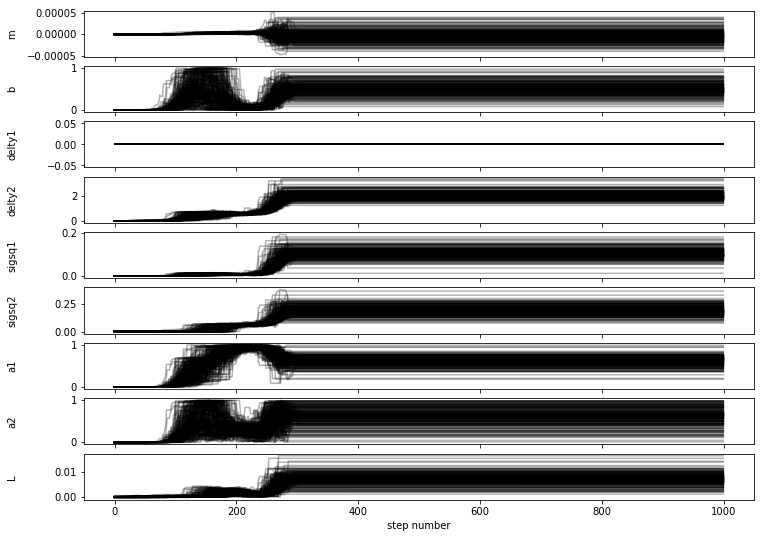

In [42]:
plt.figure(1)
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples = sampler.chain
labels = ["m", "b", "delty1", "delty2", "sigsq1", "sigsq2", "a1", "a2", "L"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
fig.savefig("mcmc_fakedata.png")
plt.show()

In [43]:
flat_samples = sampler.chain[:, 400:, :].reshape((-1, ndim))

In [44]:
m_true = 0.0
b_true = .6

delty1_true = 0.0
delty2_true = 0.3
sigsq1_true = .01
sigsq2_true = .04
a1_true = .5
a2_true = .5
L_true = 1.0

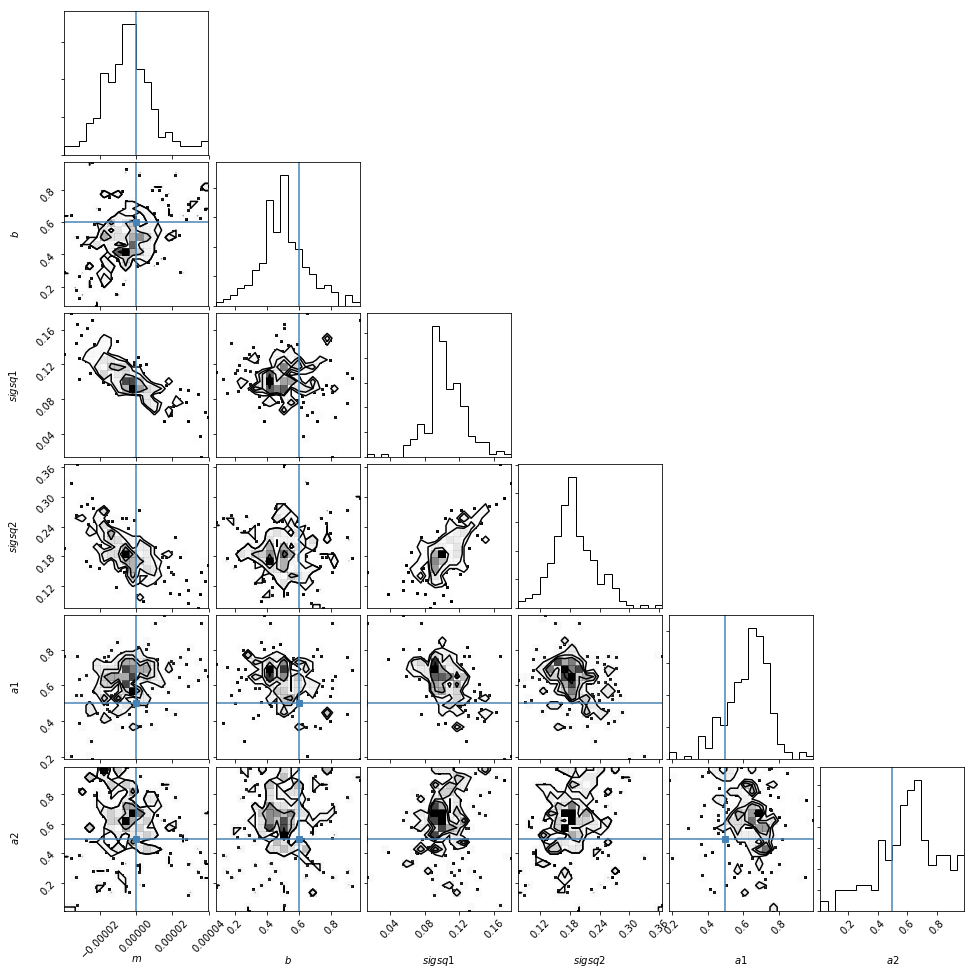

In [45]:
fig = corner.corner(flat_samples[:,[0,1,4,5,6,7]], labels=["$m$", "$b$", "$sigsq1$", "$sigsq2$", "$a1$", "$a2$"],
                      truths=[m_true, b_true, sigsq1_true, sigsq2_true, a1_true, a2_true])
fig.savefig("mcmc_fakedata.png")

In [46]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>